# Optimizing Locations for a Shop between Boroughs in NYC

In [95]:
import sqlite3
import requests
import json
import pandas as pd
import folium
import matplotlib.pyplot as plt
from  keys  import  client_id, api_key

In [2]:
conn = sqlite3.connect('coffee_places.db') # Creating a new DB
cursor = conn.cursor()                       # cursor allows us to process individual rows

In [151]:
#Creating a dictionary for both of the tables we create to be setup in. 
TABLES = {}
TABLES['business'] = (
    """CREATE TABLE IF NOT EXISTS business (
        business_id VARCHAR(30) NOT NULL,
        name TEXT,
        review_count INTEGER,
        rating DECIMAL,
        address TEXT,
        city TEXT,
        zip_code INTEGER NOT NULL,
        price TEXT,
        coordinate_latitude DECIMAL,
        coordinate_longtitude DECIMAL,
        PRIMARY KEY (business_id)
        );
    """)
TABLES['reviews'] = (
    """CREATE TABLE IF NOT EXISTS reviews (
        review_id VARCHAR(30) PRIMARY KEY,
        buisness_id VARCHAR(30) NOT NULL,
        rating DECIMAL,
        text TEXT,
        date_created TEXT,
        FOREIGN KEY (business_id)
            REFERENCES business (business_id)
        );
    """)

We are iterating over the dictionary we just made. We are pulling the keys of each
of the dictionaries (they are strings) 
we now want to execute the cursor and have it remove an existing named table 
and replace with the new named table

In [4]:
for table_name in TABLES:
    table_description = TABLES[table_name]
    #cursor.execute('DROP TABLE IF EXISTS {};'.format(table_name))
    cursor.execute(table_description)

We are establishing variables to eventually be used to pull the API information

In [5]:
#We need url, headers, and params for our request.get later. 

url =  'https://api.yelp.com/v3/businesses/search'
headers = {'Authorization': 'Bearer {}'.format(api_key)}
term = 'Coffee Shop'
locations = ['Brooklyn','Queens']
categories = 'Coffee & tea'
price = [1,2,3,4]
limit = 50
cur = 0

We are filling our url_params with our variables

In [6]:
#Here in our variable we can be specific about the way our data is returned to us.

url_params = {
                "term": term.replace(' ', '+'),
                "location": locations, #.replace(' ', '+'),
                "categories" : categories,
                "price" : price,
                "limit" : limit,
                "offset" : cur
            }

In [163]:
zip_queens = [11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357, 11358,
          11359, 11360, 11365, 11366, 11367, 11412, 11423, 11432, 11433,
          11434, 11435, 11436, 11101, 11102, 11103, 11104, 11105, 11106,
          11374, 11375, 11379, 11385, 11691, 11692, 11693, 11694, 11695,
          11697, 11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428,
          11429, 11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421,
          11368, 11369, 11370, 11372, 11373, 11377, 11378]
zip_bklyn = [11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228, 11204, 11218,
          11219, 11230, 11234, 11236, 11239, 11223, 11224, 11229, 11235, 11201,
          11205, 11215, 11217, 11231, 11203, 11210, 11225, 11226, 11207, 11208,
          11211, 11222, 11220, 11232, 11206, 11221, 11237]

Here we are creating the yelp_call function. It has the parameters that will need to be passed 
through when executed. 

It is here we will do our request to the Yelp API for the data. 


We look at the data and see that it is a dictionary and the key we want is "businesses".


json is used here to translate that data from the web into a better format for us.


We put it into a variable and make sure that when the functioon is called it returns the
key "businesses" of the data.

In [8]:
#we don't have to but we can put those points for the request.get within the function such that
#they can be iterated through with any url_params or api_key. 

def yelp_call(url_params, api_key):
    response = requests.get(url=url, headers=headers, params=url_params)
    data = response.json()
    return data['businesses']

Now that we have our data, we need to parse it into things that matter to us.

We are going to be parsing the data by the keys we know are in the dictionary that we want.

We are creating a loop that will create a list of tuples with 10 elements each.

We have the if statement to make sure that the information is matched against the zip codes lists we created.

In [9]:
#building a function that will iterate through the input dictionary and specfically filter the 
#zip codes in the boroughs of interest

def parse_results(list_of_data):
    """
    parsing data by the keys.
    params : list_of_data - list of dict.
    return : list of tuples with 10 elements in each
    """
    parsed_results = []
    for business in list_of_data:
        if int(business['location']['zip_code']) in zip_queens + zip_bklyn:
            bus_tup = (business['id'],
               business['name'],
               business['review_count'],
               business['rating'],
               ','.join(business['location']['display_address']),
               business['location']['city'],
               int(business['location']['zip_code']),
               business['price'],
               business['coordinates']['latitude'],
               business['coordinates']['longitude']
              )
            parsed_results.append(bus_tup)
    return parsed_results

So we have our data, and then we parsed it, putting it into a list of tuples. 
We are now taking a function to take those parsed results.


a SQL result is like a bag, you get to hold a whole bunch of rows at once, but not any of them individually; whereas, a cursor is like a pair of tweezers.  With it, you can reach into the bag and grab a row, and then move onto the next.


conn = is the sql connection to the DB we made at the beginning
cursor - conn.cursor() = this allows us to grab a row and then move onto the next


we supply titles for the columns of the business table we create in the 'insert_statement'

we match the number of elements with a similar number of values with the ?


We then execute the cursor, using the insert_statement and the parsed_results provided


In [10]:
#this is the function that will allow use to put the results of the parsed_results 
#into a table setup earlier in 'cursor'

def db_insert(cursor, parsed_results):
    #Here we are establishing the column titles of the table and filling with their tuple
        insert_statement = '''INSERT INTO business (
            business_id,
            name,
            review_count,
            rating,
            address,
            city,
            zip_code,
            price,
            coordinate_latitude,
            coordinate_longtitude) VALUES ( ?, ?, ?, ?, ?, ?, ?, ?, ?, ? )'''
        cursor.executemany(insert_statement, parsed_results)

Locations = ['Brooklyn', 'Queens']


We want to run all the results in the query such that only ones where the string Brooklyn or Queens are matched. If it is True, then the second for loop proceeds. 


We could use a 'while' loop but in this instance we are running a for loop with a range, and it runs starting at 0 to 1000 going in increments of 50.


We would have our interator match up against the 'cur' variable and grab the 50 results. 


Then we will pull the data from the Yelp  API with the yell_call function and plied it to 'results'


We then took those results and parsed them and put those parsed results in another variable.


We then add those results to a list with extend, rather than append, since we want to add information to the end of a list rather than just adding lists inside of other lists.


We then set and listed the results and populate or insert the information into the database.


In [11]:
all_results =[]
# locations = [Brooklyn, Queens]
for location in locations:
    url_params['location'] = location
    for cur in range(0,1000,50):
        url_params['offset'] = cur
        results = yelp_call(url_params, api_key)
        parsed_results = parse_results(results)
        all_results.extend(parsed_results)
db_insert(cursor, list(set(all_results)))

In [ ]:
""" PRACTICE """
all_results_set = list(set(all_results))
db_insert(cursor, all_results_set)
all_results_set

So we want to make a dataframe. 

We use pandas DataFrame and take the data from the business table that we just populated to a variable.

cursor.description is a read-only property that returns a list of tuples describing the columns in a result set. Each tuple in the list contains values as follows. We then use a list comprehension to fill a list that will be our column titles.

In [166]:
df = pd.DataFrame(cursor.execute("SELECT * FROM business").fetchall())
df.columns = [x[0] for x in cursor.description]
df

business_id                        name  review_count  rating  \
0    u-l6Fh681iQds5NGUyyq-w              D'Amico Coffee           122     4.0   
1    XKDHsS8PevoEdFLNtt05FA         Shuya Cafe de Ramen           294     4.5   
2    WkFRexZCg0nCSlGtRDyyTQ         Charter Coffeehouse            92     4.5   
3    ZYq4ixKvVuNAL-NwOdjxiQ                  Baby Skips            43     4.0   
4    AHB-e8F_dipajUaz_PJgDA               Krupa Grocery           309     4.5   
..                      ...                         ...           ...     ...   
681  gyYMq04u0O7nS9SHgnioIw        The Brooklyn Commons            36     3.5   
682  u9mm7AXbqyM2p4Aa5Ufx4g                     Pegasus           359     4.0   
683  Z0vgO-JoBL5bZ5U_8DfMfQ  Firefly Petite Café Bistro           132     4.0   
684  rQp8ve1NiDted89b_sIq8g              Paris Baguette            62     3.5   
685  i-0RO1FyX5sJddjMJZdHsw                  Caffe Cafe           158     3.0   

                                           address          city  zip_code  \
0                  309 Court St,Brooklyn, NY 11231      Brooklyn     11231   
1                 42-13 Broadway,Astoria, NY 11103       Astoria     11103   
2                309 Graham Ave,Brooklyn, NY 11211      Brooklyn     11211   
3               1158 Myrtle Ave,Brooklyn, NY 11221      Brooklyn     11221   
4           231 Prospect Park W,Brooklyn, NY 11215      Brooklyn     11215   
..                                             ...           ...       ...   
681            388 Atlantic Ave,Brooklyn, NY 11217      Brooklyn     11217   
682                8610 3rd Ave,Brooklyn, NY 11209      Brooklyn     11209   
683              4512 43rd Ave,Sunnyside, NY 11104     Sunnyside     11104   
684  107-08 Continental Ave,Forest Hills, NY 11375  Forest Hills     11375   
685                8401 3rd Ave,Brooklyn, NY 11209      Brooklyn     11209   

    price  coordinate_latitude  coordinate_longtitude  
0       $            40.683516             -73.995181  
1      $$            40.758007             -73.916794  
2       $            40.713329             -73.944478  
3       $            40.696980             -73.933710  
4      $$            40.659824             -73.980508  
..    ...                  ...                    ...  
681     $            40.687030             -73.985520  
682    $$            40.623215             -74.031464  
683    $$            40.744795             -73.918792  
684     $            40.720311             -73.844388  
685     $            40.624839             -74.030197  

[686 rows x 10 columns]

Review Section

Setting up a variable to hold the SELECT statement of business_ids FROM business.

In [13]:
query = """SELECT business_id FROM business"""

Now we are going to execute that statement and put all of the results into a list

list_of_tuple_biz_id = a list of tuples 

In [14]:
#we need to execute
list_of_tuple_biz_id = cursor.execute(query).fetchall()

Now we are going to check that the list works

In [ ]:
""" PRACTICE """
list_of_tuple_biz_id[:3]

Now we are going to iterate through that list of tuples, and pull out the first element which is 
the business_id for all of the stores. We also have a list comprehension.

business_ids = list of tuples of all the ids

In [ ]:
""" PRACTICE """
biz_id_list = []
for t in list_of_tuple_biz_id:
    biz_id_list.append(t[0])

In [15]:
business_ids = [t[0] for t in cursor.execute("""SELECT business_id FROM business;""").fetchall()]

Now we are going to test that it works and return the first element in the list we just made

bi = the first business_id (string)

In [ ]:
""" PRACTICE """
bi = business_ids[0]
bi

In [16]:
business_ids

['-68EJ6yIbtfPUdWXwUnlEw',
 '-8HsKILlFcC8ieznte56eg',
 '-C8nTvGcFWWX90vfn5zUoA',
 '-JXnU5QdCHBc6oPHXKwz_w',
 '-K-EeQodfnxc1dlTaaAlrA',
 '-ZXuigrnHtaNHjyQukOAQg',
 '-ic13XJ9ekpEfshQFPKL4A',
 '-jlqWTfGwSF6O-9th_3kBw',
 '-qRbyycImrGQ8HMwoU4wNg',
 '-zzMDQkhZzrnBUdrfpG3Ng',
 '05E35lYOpo0yD5Bcd_rC0g',
 '0S4MwamlsiHD8g2KZNPtIA',
 '0Wc7kKBfXO-DRTMLbF4ong',
 '0aFI9JyBCNB3pZLGngjjmw',
 '0lMLRsJZSh2Uh1Eo0YrMPA',
 '0tTv7zhaXi_T9053mHXzxg',
 '0vuzpq5d_KdFHDmBblKuVg',
 '0ywipQa5m1CD_wJFMUTRCA',
 '0zcgBHXbaJn0ZxgpcTJ1aQ',
 '1Bv7VqxnnfJs8o9NUzGB1g',
 '1Q3oaJahyGRogDWgpo7PIw',
 '1RRD6Ub4QEW9ZeyaBMx5jQ',
 '1TWe-XyitlZDPeAoBHa6oQ',
 '1U2ToXtKThkauQ4lQoK3pQ',
 '1VBeb3BF8R8cwuCYGeMrVg',
 '1VulIvaA95_ZjBIs1O0sxQ',
 '1YIwVc2Djh6FFFBbmtdUHw',
 '1Zxt8jFj1ZnGTHlOgNbZIQ',
 '1fDtQij01Mk92ZTGn6WHjg',
 '1go9HCgJQ-Ndk7_Kxi-x8g',
 '1uj4-rdYAQF6Amc0LVaeXg',
 '20ugkDBhcN3-FgsPztOuxg',
 '25UVMrpxCoo5dN7K8mM0Cw',
 '2D7orDrXzflLL1TRmWGPMw',
 '2HfGxBjtBE2ksxWoHAfNFQ',
 '2NXw5fPYxXx5-kOa6YWeRA',
 '2VCZ1W7NvefVlW6-mO-OTA',
 

We are creating a function called 'yelp_review_call'. It has the parameters that will need to be passed through when executed.

It is here we will do our request to the Yelp API for the data.

We look at the data and see that it is a dictionary and the key we want is "reviews".

we will input the url parameters, the api_key, and the business_id 
we will do 'request.get()' for the data to be called from the api and put it into review_response.  

json is used here to translate that data from the web into a better format for us.

then we will do a json and put that into a variable.

We put it into a variable and make sure that when the function is called it returns the key "review" of the data.

review_data is a dictionary. 


we will return the results from the ['reviews'] key










In [17]:
#We are putting in one business_id into the url and it returns list of 3 reivews from this business_id
#and each review represents a dictionary
#function that pulls list of 3 dict. Each dictrepresents 1 review

def yelp_review_call(url_params, api_key, business_id): 
    review_response = requests.get(url = 'https://api.yelp.com/v3/businesses/{}/reviews'.format(business_id), headers=headers ,params = url_params)
    review_data = review_response.json()
    return review_data['reviews']

Here is a practise of the function we have just built and pulling out a single review 
of the three reviews. We are only pulling one set, because we are using ['bi'] instead of 
['business_ids']

rev_3 = list of dictionaries, of the 3 reviews per business.

rev_1 = dictionary of the first element of the review data

In [ ]:
""" PRACTICE """
rev_3 = yelp_review_call(url_params, api_key, bi)
rev_1 = rev_3[0]
rev_1

We want to practice wrapping our data up in a tuple

tup = tuple

In [ ]:
""" PRACTICE """
tup =  (rev_1['id'], bi, rev_1['rating'], rev_1['text'], rev_1['time_created'])
tup

Now we are going to iterate through those conditions and put these tuples into a list

llot = list of tuples

In [ ]:
""" PRACTICE """
llot = []
for dic in rev_3:
    llot.append((dic['id'], bi, dic['rating'], dic['text'], dic['time_created']))
llot

We create a function that will take the list of dictionaries (in our case it is 'business_ids') and return a list of tuples with each of the datapoints


In [ ]:
""" PRACTICE """
Q_7J5E-cYCQfHNCkCyMdLA

In [ ]:
""" PRACTICE """
apple = yelp_review_call(url_params, api_key, 'Q_7J5E-cYCQfHNCkCyMdLA')
apple


In [ ]:
""" PRACTICE """
review_parser(apple ,'Q_7J5E-cYCQfHNCkCyMdLA')

Now that we have our data, we need to parse it into things that matter to us.

We are going to be parsing the data by the keys we know are in the dictionary that we want.

We are creating a loop that will create a list of tuples with 5 elements each.

We need to also make sure in this case that we can add the business_id that is the foreign key here from the other table. 

We do this by putting the business_id in the parameters of the function.


In [18]:
def review_parser(list_of_dicts, business_id):
    lot = []
    for dic in list_of_dicts:
        lot.append((dic['id'], business_id, dic['rating'], dic['text'], dic['time_created']))
    return lot

This runs through the business_ids and pulls the yelp_review_call information and then checks 
if there is more than 0 reviews. 

If there are then it will parse the list of reviews along with the business_id and put those
tuples into a list

In [19]:
all_reviews_parsed = []
for business_id in business_ids:
    print(business_id)
    lst_rviews = yelp_review_call(url_params, api_key, business_id)
    print(lst_rviews)
    if len(lst_rviews) > 0 :
        tuple_reviews = review_parser(lst_rviews, business_id)
        print(tuple_reviews)
        all_reviews_parsed.extend(tuple_reviews)

-68EJ6yIbtfPUdWXwUnlEw
[{'id': 'PPdiUhDxYMGjCinsoCTL-g', 'url': 'https://www.yelp.com/biz/bread-and-joe-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=PPdiUhDxYMGjCinsoCTL-g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great coffee shop with delicious baked goods! Been going here for a year now, since I moved to the neighborhood. They were shut down for a while during peak...', 'rating': 5, 'time_created': '2020-09-07 05:53:29', 'user': {'id': 'VcE64WRw9hvttomg79qSNg', 'profile_url': 'https://www.yelp.com/user_details?userid=VcE64WRw9hvttomg79qSNg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/Pzxi5IYn_S3VDiSDgin53g/o.jpg', 'name': 'Ryan S.'}}, {'id': '0JUPXty-ly73_7k9peqdSA', 'url': 'https://www.yelp.com/biz/bread-and-joe-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0JUPXty-ly73_7k9peqdSA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': '- extrem

[{'id': 'eTIY0FM9Tu-NAmNZLsB6HQ', 'url': 'https://www.yelp.com/biz/yedang-bayside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=eTIY0FM9Tu-NAmNZLsB6HQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I really liked the chestnut patbingsoo (shaved ice), it was definitely different. Yum.', 'rating': 5, 'time_created': '2020-08-10 14:50:21', 'user': {'id': 'as_NhB-HuUoU05-lpfj1bw', 'profile_url': 'https://www.yelp.com/user_details?userid=as_NhB-HuUoU05-lpfj1bw', 'image_url': None, 'name': 'Rose G.'}}, {'id': '0voj2XSwk6gP8WmIY3VZ7A', 'url': 'https://www.yelp.com/biz/yedang-bayside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0voj2XSwk6gP8WmIY3VZ7A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'My family and I have been purchasing their rice cakes for a long time because Yedang is one of the only legitimate and fresh korean rice cake stores in the...', 'rating': 1, 'time_created':

[{'id': 'R_yECGgVgPYWFF9Z1960Xw', 'url': 'https://www.yelp.com/biz/grandchamps-kitchen-and-market-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=R_yECGgVgPYWFF9Z1960Xw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I will start by saying I love Haitian food and I love Grandchamps! This is probably some of the best griot I've ever had! It is always the perfect texture...", 'rating': 5, 'time_created': '2020-11-08 06:05:25', 'user': {'id': '9SzSlEGovHa7py8fkOvrWQ', 'profile_url': 'https://www.yelp.com/user_details?userid=9SzSlEGovHa7py8fkOvrWQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/66p6ejfDw1bkqwomfZLGWw/o.jpg', 'name': 'Xenia M.'}}, {'id': 'Ohbsk6aiSswKe1RUWFykuw', 'url': 'https://www.yelp.com/biz/grandchamps-kitchen-and-market-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Ohbsk6aiSswKe1RUWFykuw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Ve

[{'id': '1GW2C9MZZX8dckaInGQ-WQ', 'url': 'https://www.yelp.com/biz/ange-noir-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=1GW2C9MZZX8dckaInGQ-WQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Ordered from here via Spread to minimize delivery app fees for small businesses, I understand times are tough right now and want to do what I can to support...', 'rating': 5, 'time_created': '2020-12-14 12:55:58', 'user': {'id': 'kY2IvXTFgam-vNCRTOj-yg', 'profile_url': 'https://www.yelp.com/user_details?userid=kY2IvXTFgam-vNCRTOj-yg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/VXbBlwmFULgC9JtNaoVZ4w/o.jpg', 'name': 'Hana S.'}}, {'id': 'uiDMknDsQ3U8KR2RbSqIjQ', 'url': 'https://www.yelp.com/biz/ange-noir-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=uiDMknDsQ3U8KR2RbSqIjQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I love ange noir! The little shop

[{'id': 'MFBxQog5ccGD1nkIozQ_sw', 'url': 'https://www.yelp.com/biz/ladybird-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=MFBxQog5ccGD1nkIozQ_sw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Ladybird is where all the wonderful cakes reside. It's a cute neighborhood bakery with a lot to choose from! \n\nI do not believe that I have ever had a...", 'rating': 5, 'time_created': '2020-12-01 08:44:27', 'user': {'id': 'r9IA-AY2d1sqxdzAy4JA-w', 'profile_url': 'https://www.yelp.com/user_details?userid=r9IA-AY2d1sqxdzAy4JA-w', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/ZbJgNX3qoliDLwiL6HolIw/o.jpg', 'name': 'Alexia G.'}}, {'id': 'BbopEexbIDDny9iJH4nwmw', 'url': 'https://www.yelp.com/biz/ladybird-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BbopEexbIDDny9iJH4nwmw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I love this place! I got my daugh

[{'id': '3Sg9Q96DLPT4yGJijNpzfw', 'url': 'https://www.yelp.com/biz/glow-joe-cafe-bayside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=3Sg9Q96DLPT4yGJijNpzfw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Quiet, small and delicious place. Very clean and COVID friendly. Great space to do work and have some great food. I got the lemon chicken sandwich and it...', 'rating': 5, 'time_created': '2020-12-10 10:58:52', 'user': {'id': 'l91TAa21p_OKC9wOMWG5pw', 'profile_url': 'https://www.yelp.com/user_details?userid=l91TAa21p_OKC9wOMWG5pw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/qZMnnqDtsTgdHeGAtr5VPQ/o.jpg', 'name': 'Debbie G.'}}, {'id': 'jKmR5090CpIz6h4G0ELXjA', 'url': 'https://www.yelp.com/biz/glow-joe-cafe-bayside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=jKmR5090CpIz6h4G0ELXjA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Fresh smoothies, juices, breakfast/bru

[{'id': 'Rw0aY5YcIKxYdk0gsMSUCw', 'url': 'https://www.yelp.com/biz/nostrand-cafe-bedford-stuyvesant?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Rw0aY5YcIKxYdk0gsMSUCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': '#ThankYouThursday \n\nNostrand Cafe is a super cute staple for a cup of quality latte / coffee / mocha plus some freshly baked pastries. You can also pick up...', 'rating': 5, 'time_created': '2020-11-19 18:18:06', 'user': {'id': 'fs6g_s-TmdrtjVPueaezAg', 'profile_url': 'https://www.yelp.com/user_details?userid=fs6g_s-TmdrtjVPueaezAg', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/IUy2_O4FzqvHRmAcyVDY1Q/o.jpg', 'name': 'Alice C.'}}, {'id': 'QpYp2oNrS9lHaghZx6tytQ', 'url': 'https://www.yelp.com/biz/nostrand-cafe-bedford-stuyvesant?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=QpYp2oNrS9lHaghZx6tytQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Nostrand Cafe

[{'id': 'yITebcb8PzHD_M9S_cfIdA', 'url': 'https://www.yelp.com/biz/mountain-province-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=yITebcb8PzHD_M9S_cfIdA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "A gem near the Hewes Station! Brooklyn has a lot of good coffee but this place has the best coffee (most caffeinated) I've tasted in Brooklyn. There...", 'rating': 5, 'time_created': '2020-09-10 20:40:24', 'user': {'id': 'KnxHcoSWj37yA1PDIzgZHg', 'profile_url': 'https://www.yelp.com/user_details?userid=KnxHcoSWj37yA1PDIzgZHg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/3Ua35OIVeX7s5x195emC7Q/o.jpg', 'name': 'Emily H.'}}, {'id': 'VoBovDpu9mPIIfZn6bCqXg', 'url': 'https://www.yelp.com/biz/mountain-province-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=VoBovDpu9mPIIfZn6bCqXg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Came here for a much needed aftern

[{'id': 'Oqu4R8YHhveeWrK6jEO6Yg', 'url': 'https://www.yelp.com/biz/zaca-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Oqu4R8YHhveeWrK6jEO6Yg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I ordered delivery through Uber eats: \n\nShrimp and Grits with a side of beets, goat cheese, and walnuts.\n-shrimp had great flavor, only issue is that there...', 'rating': 5, 'time_created': '2020-09-21 11:52:38', 'user': {'id': 'z5xrx4M2XT6wNAe2t9Hj0A', 'profile_url': 'https://www.yelp.com/user_details?userid=z5xrx4M2XT6wNAe2t9Hj0A', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/PpJMX71HaJJdrNfzaxc-gw/o.jpg', 'name': 'Charlene M.'}}, {'id': 'n9mcpXCulZnNAmCPd3wTUQ', 'url': 'https://www.yelp.com/biz/zaca-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=n9mcpXCulZnNAmCPd3wTUQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This is one of my favorite breakfast 

[{'id': 'N7caOXxhbPJOJsB2intcBw', 'url': 'https://www.yelp.com/biz/cocoa-grinder-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=N7caOXxhbPJOJsB2intcBw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I love their overnight oats, however when I got it for delivery it was watery I was so upset. I had to put it in the fridge so I can eat it the next day. My...', 'rating': 4, 'time_created': '2020-05-21 14:42:15', 'user': {'id': 'BvRUwN5QUWOdWaYLMEKY2g', 'profile_url': 'https://www.yelp.com/user_details?userid=BvRUwN5QUWOdWaYLMEKY2g', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/9B3wGFsm5oRFjBsY2qR0xA/o.jpg', 'name': 'Rosalia X.'}}, {'id': '0HO-bLmlU54-gThB7p92hw', 'url': 'https://www.yelp.com/biz/cocoa-grinder-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0HO-bLmlU54-gThB7p92hw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Love their coffee, love supp

[{'id': 'r5VNoJQ4XhNNRVpdvIxDtg', 'url': 'https://www.yelp.com/biz/the-black-flamingo-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=r5VNoJQ4XhNNRVpdvIxDtg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Gorgeous cafe in the heart of Redhook. Their oat milk lattes are dreamy, and the black flamingo takes serious pride in their craft. You can choose your...', 'rating': 5, 'time_created': '2020-04-24 19:05:09', 'user': {'id': 'Y-647YDPWZ_zyRMJe_QIxQ', 'profile_url': 'https://www.yelp.com/user_details?userid=Y-647YDPWZ_zyRMJe_QIxQ', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/Be8Zx_IL2Zm28IgAPvBaHg/o.jpg', 'name': 'Charlotte C.'}}, {'id': 'z83BgB0nvrDF02F6yIGGpQ', 'url': 'https://www.yelp.com/biz/the-black-flamingo-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=z83BgB0nvrDF02F6yIGGpQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Such a cute, cozy atmosph

[{'id': 'x-yYnWY7FGpKS22hi1E44A', 'url': 'https://www.yelp.com/biz/utopia-bagels-whitestone-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=x-yYnWY7FGpKS22hi1E44A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Came here for breakfast about a month ago. I don't think I've had a bagel during the entire pandemic, so I figured I'd treat myself to one at long last. The...", 'rating': 5, 'time_created': '2020-12-21 16:03:55', 'user': {'id': 'B8REbpM6KwNizD-TW1zQFw', 'profile_url': 'https://www.yelp.com/user_details?userid=B8REbpM6KwNizD-TW1zQFw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/fyWDoYDcJPVkIeKVt1l-ew/o.jpg', 'name': 'Cinthia K.'}}, {'id': 'chOzXE9jm2wGGIfIe9fBCw', 'url': 'https://www.yelp.com/biz/utopia-bagels-whitestone-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=chOzXE9jm2wGGIfIe9fBCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'My go to is the pumperni

[{'id': '0QWWK_BNMPBrMIsOvzMmUQ', 'url': 'https://www.yelp.com/biz/red-hook-coffee-shop-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0QWWK_BNMPBrMIsOvzMmUQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Inventing prices as they go along and left bacon off of an order in which it was one of 3 ingredients. Overcharged by $5 and terrible service to boot. Oh...', 'rating': 1, 'time_created': '2018-05-05 05:00:19', 'user': {'id': 'AniOH5v2THWcKsV8EvQXkw', 'profile_url': 'https://www.yelp.com/user_details?userid=AniOH5v2THWcKsV8EvQXkw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/EPVUtzclc68WppASHQdn2g/o.jpg', 'name': 'Paul W.'}}, {'id': 'FOjEImeq2JcIVjoy4hKreg', 'url': 'https://www.yelp.com/biz/red-hook-coffee-shop-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=FOjEImeq2JcIVjoy4hKreg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'A great and inexpens

[{'id': 'ItkZgysFhhvrbYwWcP-0rw', 'url': 'https://www.yelp.com/biz/henrys-local-new-york?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ItkZgysFhhvrbYwWcP-0rw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Such a sweet little find. It feels like a treasure for the locals here.\nGreat coffee, excellent service and menu. Lots of cookies, pastries and treats sold...', 'rating': 5, 'time_created': '2020-09-30 07:52:30', 'user': {'id': 'AdnL1ZEYB3S2a8iWzQJSyA', 'profile_url': 'https://www.yelp.com/user_details?userid=AdnL1ZEYB3S2a8iWzQJSyA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/5pYUYqtPBsI0tnEGXWTTNw/o.jpg', 'name': 'Anisa A.'}}, {'id': 'wYAj0lWas3GrbLz9X7rQ5Q', 'url': 'https://www.yelp.com/biz/henrys-local-new-york?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wYAj0lWas3GrbLz9X7rQ5Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "We stayed at the owner's sweet B and

[{'id': '7hQof7RsS66_38kI1qL-sA', 'url': 'https://www.yelp.com/biz/starbucks-rego-park-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=7hQof7RsS66_38kI1qL-sA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm not a Starbucks regular but when I do go this is usually the location. I really like it here! No comment on any smells or seating issues because the...", 'rating': 4, 'time_created': '2020-09-02 13:42:53', 'user': {'id': 'x8SE81comQk5Ao0fALWI1w', 'profile_url': 'https://www.yelp.com/user_details?userid=x8SE81comQk5Ao0fALWI1w', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/zXnfWZyGF8Gd0-0DhO7BWw/o.jpg', 'name': 'Ashlee S.'}}, {'id': 'pleMxO3Cxznv9pe-ouLJpQ', 'url': 'https://www.yelp.com/biz/starbucks-rego-park-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=pleMxO3Cxznv9pe-ouLJpQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Amazing customer service! \n\nNot just 

[{'id': 'KQTTwFZun_cSbWkq8nitmQ', 'url': 'https://www.yelp.com/biz/house-party-cafe-and-lounge-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=KQTTwFZun_cSbWkq8nitmQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Really good place to hang out. Nice, calm atmosphere, good coffee, sangría, really good breakfast sandwiches. Service is great and personal. The sheltered...', 'rating': 5, 'time_created': '2020-12-06 13:40:41', 'user': {'id': 'YsY9n1EciTfEl-tXEHnyqw', 'profile_url': 'https://www.yelp.com/user_details?userid=YsY9n1EciTfEl-tXEHnyqw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/_Yc8J3vZbs6pYB6GZRzoIA/o.jpg', 'name': 'Juan M.'}}, {'id': 'rUIyjDAYL7OVCU0zwpU1rg', 'url': 'https://www.yelp.com/biz/house-party-cafe-and-lounge-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rUIyjDAYL7OVCU0zwpU1rg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute 

[{'id': 'HkQWRw219eP7yszGhrYu-Q', 'url': 'https://www.yelp.com/biz/foster-sundry-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=HkQWRw219eP7yszGhrYu-Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Thanks for staying open during this time and providing great service and food for the community. It's made this horrible quarantine situation that much...", 'rating': 5, 'time_created': '2020-04-01 12:39:51', 'user': {'id': 'pbtRi2cCgrSU17mX8nUCVw', 'profile_url': 'https://www.yelp.com/user_details?userid=pbtRi2cCgrSU17mX8nUCVw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/B0g32tY9_5WbWQFJ_12dOA/o.jpg', 'name': 'Kat M.'}}, {'id': 'x4RVWbkp4DGTUCZjoVUw1A', 'url': 'https://www.yelp.com/biz/foster-sundry-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=x4RVWbkp4DGTUCZjoVUw1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Has been a neighborhood staple for high q

[{'id': 'ChVOPBEQsFGa468Y1SiDeA', 'url': 'https://www.yelp.com/biz/think-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ChVOPBEQsFGa468Y1SiDeA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Love to stop here in the morning to get my dog the vegan dog treats and an iced latte for myself. Also loving the outdoor dining sitch for COVID', 'rating': 5, 'time_created': '2020-10-26 19:19:10', 'user': {'id': 'fo76km5cncZuS4uBcxPZJQ', 'profile_url': 'https://www.yelp.com/user_details?userid=fo76km5cncZuS4uBcxPZJQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/OGGkbQU9kFaNQBOup81_EQ/o.jpg', 'name': 'Terri B.'}}, {'id': 'LW72b3hqVAvIWxaKeWWC7Q', 'url': 'https://www.yelp.com/biz/think-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=LW72b3hqVAvIWxaKeWWC7Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'A Christian Coffee Date this afternoon and this pla

[{'id': 'QdP95x7o8xgTWJm3Fidz3g', 'url': 'https://www.yelp.com/biz/marquet-patisserie-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=QdP95x7o8xgTWJm3Fidz3g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I live practically above this spot, so I am probably bias. Whenever it's cold out, or I am hopping in an Uber, this is my go-to to grab coffee and a quick...", 'rating': 4, 'time_created': '2017-12-31 09:25:26', 'user': {'id': 'RQwpmmfmR8chA6g6d_UXnw', 'profile_url': 'https://www.yelp.com/user_details?userid=RQwpmmfmR8chA6g6d_UXnw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/wYndkOx1P39lQ6ZUlyAN8Q/o.jpg', 'name': 'Angelique L.'}}, {'id': 'ZjJnLlyenJSDJKF1bWYq6A', 'url': 'https://www.yelp.com/biz/marquet-patisserie-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ZjJnLlyenJSDJKF1bWYq6A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Not sure why peopl

[{'id': '7c--XcPv2pQS-wT3RZ44sA', 'url': 'https://www.yelp.com/biz/little-house-cafe-elmhurst-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=7c--XcPv2pQS-wT3RZ44sA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "There aren't many Malaysian restaurants, good ones are even fewer, this is a good place to go to if you want something a little more home style. It's not...", 'rating': 4, 'time_created': '2020-10-07 12:01:49', 'user': {'id': '1ZYLQYMoCvZbiNz3IgNccQ', 'profile_url': 'https://www.yelp.com/user_details?userid=1ZYLQYMoCvZbiNz3IgNccQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/uj0OMDoVgJlwEytgnN60rw/o.jpg', 'name': 'Kelda C.'}}, {'id': 'SbEpbo8J2f0JYvU_1n3QUw', 'url': 'https://www.yelp.com/biz/little-house-cafe-elmhurst-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=SbEpbo8J2f0JYvU_1n3QUw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "They're open now (May 202

[{'id': 'YA1p08IYBKQZh5_dU-HZAQ', 'url': 'https://www.yelp.com/biz/la-boulangerie-de-fran%C3%A7ois-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YA1p08IYBKQZh5_dU-HZAQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Great little hidden gem\n\nFood: I've been here twice now and enjoyed the baked goods both times. This time I ordered matcha coffee which was just okay (very...", 'rating': 4, 'time_created': '2021-01-03 18:26:20', 'user': {'id': 'IxlGycX5KMNnQBPjBW7sug', 'profile_url': 'https://www.yelp.com/user_details?userid=IxlGycX5KMNnQBPjBW7sug', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/LiocAuMnZdKBqJqxlwlJ3A/o.jpg', 'name': 'P R.'}}, {'id': 'Rnm55BrwfRpc-ILUlpNi2A', 'url': 'https://www.yelp.com/biz/la-boulangerie-de-fran%C3%A7ois-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Rnm55BrwfRpc-ILUlpNi2A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 't

[{'id': 'Qi1xAQhJw6NUlsZ0jCycHg', 'url': 'https://www.yelp.com/biz/swick-2-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Qi1xAQhJw6NUlsZ0jCycHg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm a huge fan of Swick 2. The Sunswick, Swick2's parent restaurant, did not have great food when we tried them, however I am so pleased that Swick2 meets...", 'rating': 5, 'time_created': '2020-07-08 05:13:47', 'user': {'id': 'hus-yaPZsUfv9FZFev9Z5g', 'profile_url': 'https://www.yelp.com/user_details?userid=hus-yaPZsUfv9FZFev9Z5g', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/ZQ3yQrICCRCS3XC2hmRCzQ/o.jpg', 'name': 'Victoria S.'}}, {'id': 'bupkiCtM-LWvU75FdktCxw', 'url': 'https://www.yelp.com/biz/swick-2-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=bupkiCtM-LWvU75FdktCxw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I was staying at an AirBnB in Astoria, Quee

[{'id': 'biNlmlE_Eb-jAYLXKk5JeQ', 'url': 'https://www.yelp.com/biz/brooklyn-kolache-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=biNlmlE_Eb-jAYLXKk5JeQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I recently visited for the first time and was excited they were open for contactless pickup during COVID-19.\n\nI have always been interested in trying a...', 'rating': 5, 'time_created': '2020-06-28 07:16:15', 'user': {'id': 'YEA0Nqf_-AREAu1n905wCQ', 'profile_url': 'https://www.yelp.com/user_details?userid=YEA0Nqf_-AREAu1n905wCQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/2Fzy4s579I7AMtu-TLPNHA/o.jpg', 'name': 'Lauren R.'}}, {'id': 'BYU4zUUFCCVWgMw9HYunKQ', 'url': 'https://www.yelp.com/biz/brooklyn-kolache-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BYU4zUUFCCVWgMw9HYunKQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "One of my favorite neighborhoo

[{'id': 'occjp6F3JAA5t6jkaGzChA', 'url': 'https://www.yelp.com/biz/doc-ds-southern-desserts-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=occjp6F3JAA5t6jkaGzChA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great hospitality... quick service.. but very busy... social distancing practiced during Covid. While on the line.. you know us folk like to about food when...', 'rating': 5, 'time_created': '2020-08-16 08:56:22', 'user': {'id': 'rhg7FR4Vm1yPOPX6vmVXIQ', 'profile_url': 'https://www.yelp.com/user_details?userid=rhg7FR4Vm1yPOPX6vmVXIQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/cpCD9Uq9WL2pbnhO292-uQ/o.jpg', 'name': 'Intrigue L.'}}, {'id': 'ull7EPvBvKEkHisqyjNUFg', 'url': 'https://www.yelp.com/biz/doc-ds-southern-desserts-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ull7EPvBvKEkHisqyjNUFg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Ok so whe

[{'id': 'bkWYA30v0hgldoAXbMXy4Q', 'url': 'https://www.yelp.com/biz/bricktown-bagel-and-cafe-long-island-city-16?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=bkWYA30v0hgldoAXbMXy4Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Called in for pick up and my order was ready when it was expected to be.. ordered two bagels both were delicious! One was with ham and cream cheese ( was...', 'rating': 5, 'time_created': '2020-08-19 14:00:45', 'user': {'id': '3v-sZO-ShOod6H1ZVM-6bA', 'profile_url': 'https://www.yelp.com/user_details?userid=3v-sZO-ShOod6H1ZVM-6bA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/gfr49d89gd8234GLI1Ivng/o.jpg', 'name': 'Alexandra R.'}}, {'id': '1LlPef7e033iLWAG2jwsGw', 'url': 'https://www.yelp.com/biz/bricktown-bagel-and-cafe-long-island-city-16?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=1LlPef7e033iLWAG2jwsGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g'

[{'id': 'tFbMdlSP3gVHYVmMMHvVTQ', 'url': 'https://www.yelp.com/biz/the-buren-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=tFbMdlSP3gVHYVmMMHvVTQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Nice little neighborhood coffee (and actual) bar to grab a quick drink before heading out. At the moment, their COVID setup is ordering at the counter and...', 'rating': 4, 'time_created': '2020-12-28 05:52:44', 'user': {'id': 'XJuBP5ttHUEdL2zPVJZJHg', 'profile_url': 'https://www.yelp.com/user_details?userid=XJuBP5ttHUEdL2zPVJZJHg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/o56Az_KNiaeMvBvlJYl3FQ/o.jpg', 'name': 'Abby E.'}}, {'id': 'OhcJGK7gs6jg3kJvN8SSmw', 'url': 'https://www.yelp.com/biz/the-buren-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OhcJGK7gs6jg3kJvN8SSmw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place is perfect for a neighborhood 

[{'id': 'IjuZWvvoKcZKlHFbXwklKg', 'url': 'https://www.yelp.com/biz/milk-and-pull-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=IjuZWvvoKcZKlHFbXwklKg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Milk & Pull has become a staple in my life due to covid. Ordering online is super easy and they have alternative milks for those of us that are sensitive to...', 'rating': 5, 'time_created': '2020-09-17 14:24:59', 'user': {'id': 'RVl4wNUwiOHN79rzvld5XA', 'profile_url': 'https://www.yelp.com/user_details?userid=RVl4wNUwiOHN79rzvld5XA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/y1EMnKqmTvaJMuBBZQLf9w/o.jpg', 'name': 'Amara R.'}}, {'id': 'kd4LU0N9tB_LoLVML_AFlQ', 'url': 'https://www.yelp.com/biz/milk-and-pull-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=kd4LU0N9tB_LoLVML_AFlQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I can honestly say that spot i

[{'id': 'ToIlSaM0KsBhzaPMSPaETA', 'url': 'https://www.yelp.com/biz/cocoa-grinder-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ToIlSaM0KsBhzaPMSPaETA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cocoa Grinder is spacious and allows folks to linger in true coffeehouse style. They serve fresh hot food, including omelettes (Mexican omelette is delish)...', 'rating': 5, 'time_created': '2019-02-17 07:02:27', 'user': {'id': 'hFTmklCA5CIXZbhnMtsHZw', 'profile_url': 'https://www.yelp.com/user_details?userid=hFTmklCA5CIXZbhnMtsHZw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/_YQh7WmdWdF4HrPYKqsfyQ/o.jpg', 'name': 'Fran H.'}}, {'id': '0ono-4vewdtYF57-MbSWug', 'url': 'https://www.yelp.com/biz/cocoa-grinder-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0ono-4vewdtYF57-MbSWug&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Coffee review. Place is spacious

[{'id': 'SwzJ_PS4ruRyP_ONW4uaxQ', 'url': 'https://www.yelp.com/biz/gather-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=SwzJ_PS4ruRyP_ONW4uaxQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I preface it's rare I give a 5 on my first stop to a place, especially when it's just one item and not a full meal - but often update my reviews with time....", 'rating': 4, 'time_created': '2020-12-03 14:12:14', 'user': {'id': 'D-EKxJMdoUq2Q4yoiRz3nQ', 'profile_url': 'https://www.yelp.com/user_details?userid=D-EKxJMdoUq2Q4yoiRz3nQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/AKlpSeWOKQoieVIGRYMzvQ/o.jpg', 'name': 'Lindsey O.'}}, {'id': 'd9cQE5HM1DTREban1Q-RxA', 'url': 'https://www.yelp.com/biz/gather-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=d9cQE5HM1DTREban1Q-RxA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I love the crunchy chicken cutlet at Gather. Th

[{'id': 'ZvYJ63pTBec4ov_JHXnP3Q', 'url': 'https://www.yelp.com/biz/coffee-pot-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ZvYJ63pTBec4ov_JHXnP3Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I've been deciding on coming here for a while now after seeing people in long lines sometimes for coffee here.  I finally came this weekend and it did not...", 'rating': 5, 'time_created': '2020-10-04 11:07:45', 'user': {'id': 'vn_MbtVBAPZsz9N4zgKA-A', 'profile_url': 'https://www.yelp.com/user_details?userid=vn_MbtVBAPZsz9N4zgKA-A', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/z-p5_QvEDxnHXn8_07Aj4w/o.jpg', 'name': 'Roop K.'}}, {'id': 'OSWQ8PRG-dB3PoN5ELnMkw', 'url': 'https://www.yelp.com/biz/coffee-pot-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OSWQ8PRG-dB3PoN5ELnMkw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Oh hello to my new coffee spot! Don't let the

[{'id': 'kZn2ZBbIEln45oH_FSr3TA', 'url': 'https://www.yelp.com/biz/tim-hortons-jamaica?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=kZn2ZBbIEln45oH_FSr3TA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I can't say enough good things about Tim Horton's. Delightful menu items at great prices, amazing mood to unwind at. Every thing I've tried so far has been...", 'rating': 5, 'time_created': '2020-12-07 00:48:10', 'user': {'id': 'Re4DeXea8TGCcoopehsSEA', 'profile_url': 'https://www.yelp.com/user_details?userid=Re4DeXea8TGCcoopehsSEA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/sr-cP3GJsK2MdNHyAmhP5w/o.jpg', 'name': 'Janie G.'}}, {'id': 'yoVz3ePP9hrlkd8dt_NItA', 'url': 'https://www.yelp.com/biz/tim-hortons-jamaica?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=yoVz3ePP9hrlkd8dt_NItA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Bad representation of this brand \nThere 

[{'id': 'yCAHy4kTBwe7ZDP9D1o8hA', 'url': 'https://www.yelp.com/biz/caffe-vita-bushwick-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=yCAHy4kTBwe7ZDP9D1o8hA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I used to work down the block from caffe vita I really miss the coffee and the energy from that place unfortunately covid has changed the world for now I am...', 'rating': 5, 'time_created': '2020-10-08 09:22:16', 'user': {'id': 'wyg9WbDMfFH53dKxzXE83Q', 'profile_url': 'https://www.yelp.com/user_details?userid=wyg9WbDMfFH53dKxzXE83Q', 'image_url': None, 'name': 'Spencer C.'}}, {'id': 'm-Qu34hC29Dt7jY5L1lHYw', 'url': 'https://www.yelp.com/biz/caffe-vita-bushwick-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=m-Qu34hC29Dt7jY5L1lHYw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "If you're looking for a friendly atmosphere with good drinks, DO NOT go to caffe vita

[{'id': '3YOoVVsPcLNk4vj99RPvkg', 'url': 'https://www.yelp.com/biz/rudys-bakery-and-cafe-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=3YOoVVsPcLNk4vj99RPvkg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Two words... Rainbow Cake. \n\nI am a rainbow cookie and cake expert and the cake offered at Rudy's is one of the best I've ever had. A thin layer of...", 'rating': 5, 'time_created': '2020-12-30 13:17:59', 'user': {'id': '_Q_q46VyUvPgOwWZs5ebuw', 'profile_url': 'https://www.yelp.com/user_details?userid=_Q_q46VyUvPgOwWZs5ebuw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/rtUAINoLz4eLRkTs350Ytw/o.jpg', 'name': 'Jackson S.'}}, {'id': 'F-wqj-N2JFrBGDI_zfbwWw', 'url': 'https://www.yelp.com/biz/rudys-bakery-and-cafe-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=F-wqj-N2JFrBGDI_zfbwWw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "4 MINUTES AGO\nOrdere

[{'id': 'BecXEe3h2zfViBDogP45fg', 'url': 'https://www.yelp.com/biz/fay-da-bakery-woodside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BecXEe3h2zfViBDogP45fg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'My go-to bakery in the local neighborhood. I was so happy when Fayda opened up in Woodside- they sell fresh bread and delicious cakes. \n\nNeed a quick...', 'rating': 5, 'time_created': '2020-11-09 08:42:15', 'user': {'id': 'tUg8KgP-DTmIcNNUoEjkPA', 'profile_url': 'https://www.yelp.com/user_details?userid=tUg8KgP-DTmIcNNUoEjkPA', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/TgEBklniauW8lztKmN3Zfw/o.jpg', 'name': 'Shirley Z.'}}, {'id': '-_ibIXKZeotJD9ATTFXPdQ', 'url': 'https://www.yelp.com/biz/fay-da-bakery-woodside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=-_ibIXKZeotJD9ATTFXPdQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I was really pleased with this place.

[{'id': 'voW66YpklrNa0GwKXrzvmw', 'url': 'https://www.yelp.com/biz/adams-bagels-and-deli-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=voW66YpklrNa0GwKXrzvmw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Ordered from them this morning because I was craving some good bagels and all stores near me are out of bagels (pandemic got people stalk up on them). You...', 'rating': 5, 'time_created': '2020-05-06 08:54:40', 'user': {'id': 'CK21ry_-ah4vWitUd40xJA', 'profile_url': 'https://www.yelp.com/user_details?userid=CK21ry_-ah4vWitUd40xJA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/-6D_kc3EKGiJOIpRoULPqA/o.jpg', 'name': 'Leyla A.'}}, {'id': 'W8_stnKHtX4gA_cioYbejg', 'url': 'https://www.yelp.com/biz/adams-bagels-and-deli-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=W8_stnKHtX4gA_cioYbejg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Very delicious foo

[{'id': 'OPLbvxGJ2fCWUVA5o7GMLA', 'url': 'https://www.yelp.com/biz/oslo-coffee-roasters-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OPLbvxGJ2fCWUVA5o7GMLA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Our favorite coffee experience in Brooklyn. They used a piston machine which absolutely fascinated me as a coffee connoisseur, so we asked and he was kind...', 'rating': 5, 'time_created': '2019-03-21 05:42:33', 'user': {'id': 'xgX-b91krgTAXQ-UL567Hw', 'profile_url': 'https://www.yelp.com/user_details?userid=xgX-b91krgTAXQ-UL567Hw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/5wPSdjX5ivDsi2NLfN6Tdg/o.jpg', 'name': 'Lacey S.'}}, {'id': 'nYo60AISoow1doZ84L1niA', 'url': 'https://www.yelp.com/biz/oslo-coffee-roasters-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=nYo60AISoow1doZ84L1niA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "It's crazy how a s

[{'id': '-qgQD0b3ZEM00A9w-yO1Ug', 'url': 'https://www.yelp.com/biz/tea-shop-168-and-bakery-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=-qgQD0b3ZEM00A9w-yO1Ug&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Like that they changed to foil container. It is still Hot Hot after 30 mins from my pick up time.', 'rating': 5, 'time_created': '2020-10-26 13:39:03', 'user': {'id': 'D33eo75LKOG3TXDiTeQ2uA', 'profile_url': 'https://www.yelp.com/user_details?userid=D33eo75LKOG3TXDiTeQ2uA', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/TiHKwnUEgw4ZwlUUia3ppA/o.jpg', 'name': 'Miao K.'}}, {'id': '5YI_S3tbJ21ImpuKc7f24A', 'url': 'https://www.yelp.com/biz/tea-shop-168-and-bakery-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=5YI_S3tbJ21ImpuKc7f24A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "They are open for take out during covid times, and food is just as good as it

[{'id': 'Uoh61zgimsvSU9UUQWG4-g', 'url': 'https://www.yelp.com/biz/bonelle-pastry-shop-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Uoh61zgimsvSU9UUQWG4-g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "It's so nice to have a bakery in the neighborhood with delectable treats and sweets. One of my favorites are the lemon bars, they are out of this world!...", 'rating': 5, 'time_created': '2020-12-20 12:13:10', 'user': {'id': 'S2yyTo_R2aCTrmUjEhe9BQ', 'profile_url': 'https://www.yelp.com/user_details?userid=S2yyTo_R2aCTrmUjEhe9BQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/5X8D0IaJlEmnpq0YezpR_g/o.jpg', 'name': 'Zoila N.'}}, {'id': 'cBWQdi4d9_K4N6wnqUkz9w', 'url': 'https://www.yelp.com/biz/bonelle-pastry-shop-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=cBWQdi4d9_K4N6wnqUkz9w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Delicious cookies 

[{'id': 'q4cXcVV8lYt4O3pLy7hAwA', 'url': 'https://www.yelp.com/biz/getaway-new-york-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=q4cXcVV8lYt4O3pLy7hAwA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Just wanted to say that you really put a smile on my face. The best pumpkin spice latte in the neighborhood! And always served with kindness. Thank you! :-)', 'rating': 5, 'time_created': '2020-10-31 19:04:25', 'user': {'id': 'rCdvo5pqwT_qMKy6N3UY9w', 'profile_url': 'https://www.yelp.com/user_details?userid=rCdvo5pqwT_qMKy6N3UY9w', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/iQkEtgzll3vxC8Lkj9uqNQ/o.jpg', 'name': 'Jenn H.'}}, {'id': 'Hn7oy3M7klrCOQ9DROPzuQ', 'url': 'https://www.yelp.com/biz/getaway-new-york-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Hn7oy3M7klrCOQ9DROPzuQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Hidden little joint in Greenpoint, a convenien

[{'id': 'dp8HcTMFouL4TtByYKXgJA', 'url': 'https://www.yelp.com/biz/krupa-grocery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=dp8HcTMFouL4TtByYKXgJA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I did a takeout order from here during the COVID pandemic and had a great experience. They have around 2 tables outside, but I did takeout since I wanted to...', 'rating': 5, 'time_created': '2020-08-14 07:30:04', 'user': {'id': 'fsaquFN9gBoDemnzKJ-kgg', 'profile_url': 'https://www.yelp.com/user_details?userid=fsaquFN9gBoDemnzKJ-kgg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/NjY6kx4zaU37363dw6FVTQ/o.jpg', 'name': 'Sarah X.'}}, {'id': '2snO8LJktL6rd4-MNSLWCA', 'url': 'https://www.yelp.com/biz/krupa-grocery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=2snO8LJktL6rd4-MNSLWCA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place, like many others, has 

[{'id': '07-RdL-uEi3W3byVnxq0Lw', 'url': 'https://www.yelp.com/biz/blue-marble-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=07-RdL-uEi3W3byVnxq0Lw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I am often singing the praises of shiny new small batch ice cream stores that tout international ingredients but I overlook tried and true old favorites...', 'rating': 5, 'time_created': '2020-05-28 14:16:24', 'user': {'id': 'VLTBPUrbNRR-f84h-altQw', 'profile_url': 'https://www.yelp.com/user_details?userid=VLTBPUrbNRR-f84h-altQw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/5KCViiaoj9zKiBcStwt-eA/o.jpg', 'name': 'Morlene C.'}}, {'id': 'ljrWJ3Zmd2cqsElRcnu4fA', 'url': 'https://www.yelp.com/biz/blue-marble-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ljrWJ3Zmd2cqsElRcnu4fA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Organic ice cream with great flavor.

[{'id': 'fc0jXenGhoAXB4y1zdIjAg', 'url': 'https://www.yelp.com/biz/cafe-to-go-astoria-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=fc0jXenGhoAXB4y1zdIjAg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place was always amazing because they make coffee right and very quickly  best to go coffee in Astoria! After the lockdown they started giving free...', 'rating': 5, 'time_created': '2020-05-16 10:49:29', 'user': {'id': 'R0Yli3ZNG69TEVNvXxOEHg', 'profile_url': 'https://www.yelp.com/user_details?userid=R0Yli3ZNG69TEVNvXxOEHg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/tF8DZNaoOWp92YXWiZg1mw/o.jpg', 'name': 'Alexia L.'}}, {'id': 'OW2r3_9x7-W6jUecWEIeqw', 'url': 'https://www.yelp.com/biz/cafe-to-go-astoria-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OW2r3_9x7-W6jUecWEIeqw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Very good coffee.  It's that simple. Can'

[{'id': 'e2Fo9di7hxgsA_woE3epmA', 'url': 'https://www.yelp.com/biz/starbucks-kew-gardens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=e2Fo9di7hxgsA_woE3epmA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Best customer service in town baristas make welcome you every time you come in even if you're not a regular", 'rating': 5, 'time_created': '2020-07-02 08:13:04', 'user': {'id': 'hY3uDoxiaGh_VPO2iQ_OSQ', 'profile_url': 'https://www.yelp.com/user_details?userid=hY3uDoxiaGh_VPO2iQ_OSQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/5nDpvKKswIrrY1nXA-O95A/o.jpg', 'name': 'Vanessa O.'}}, {'id': 'nGPW1nIQoBKCsCLPSVug5A', 'url': 'https://www.yelp.com/biz/starbucks-kew-gardens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=nGPW1nIQoBKCsCLPSVug5A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Although this Starbucks  is close to me, I do not come here all that often as I am

[{'id': '9pDQCqCNMC0ujR1F8pvZVw', 'url': 'https://www.yelp.com/biz/hungry-ghost-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=9pDQCqCNMC0ujR1F8pvZVw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Perfect outdoor seating and great for people watching! \n- chocolate croissant is flaky and delicious \n- cappuccino- strong and just what I needed', 'rating': 5, 'time_created': '2020-11-19 08:54:55', 'user': {'id': 'kjlL0LPNI4FlkRbdtB4Y5A', 'profile_url': 'https://www.yelp.com/user_details?userid=kjlL0LPNI4FlkRbdtB4Y5A', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/WOTXqhZxOyMxEYJK95la5g/o.jpg', 'name': 'Garima G.'}}, {'id': 'dbg3dMDFWw974ottWvu2QQ', 'url': 'https://www.yelp.com/biz/hungry-ghost-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=dbg3dMDFWw974ottWvu2QQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great alternative from the shops on a Satur

[{'id': 'WYuISMBOjbdvMzaTduWEvg', 'url': 'https://www.yelp.com/biz/doughnut-plant-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=WYuISMBOjbdvMzaTduWEvg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Our favorite doughnuts by far!!!  Each one is a dessert masterpiece.  You will never eat Dunkin again!\n\nWe've ordered for pick up twice during the pandemic,...", 'rating': 5, 'time_created': '2021-01-05 17:33:13', 'user': {'id': 'gerZCOGJ6CbdUnR22zjWPg', 'profile_url': 'https://www.yelp.com/user_details?userid=gerZCOGJ6CbdUnR22zjWPg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/D1CLvKOFDEOoj0CfYTUNZw/o.jpg', 'name': 'Cheryl C.'}}, {'id': 'HntEl5rSzRvmGXNM7wnsog', 'url': 'https://www.yelp.com/biz/doughnut-plant-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=HntEl5rSzRvmGXNM7wnsog&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I finally mad

[{'id': 'zdJ9rnLiIpabphIa89SaVg', 'url': 'https://www.yelp.com/biz/skal-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=zdJ9rnLiIpabphIa89SaVg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "New to the neighborhood, so tried Skal for the first time today. They're open for outdoor dining only, and were only taking electronic payments (Zelle,...", 'rating': 4, 'time_created': '2020-10-10 12:56:50', 'user': {'id': 'Ai-qTk8mIjIwQDj8VGtevA', 'profile_url': 'https://www.yelp.com/user_details?userid=Ai-qTk8mIjIwQDj8VGtevA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/oxqtNXCljbMbZCTKpQzBHg/o.jpg', 'name': 'Liza S.'}}, {'id': 'l9DY3Y888GkICubhdJ-t5Q', 'url': 'https://www.yelp.com/biz/skal-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=l9DY3Y888GkICubhdJ-t5Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I was hosting a HBCU College Fair in a nearby middle schoo

[{'id': 'WFZmCMTQV8sZ1yNkw8ysWw', 'url': 'https://www.yelp.com/biz/milk-bar-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=WFZmCMTQV8sZ1yNkw8ysWw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Although I have not actually BEEN to Milk Bar, this year, for my son's birthday, I wanted to get him an extra special cake because... COVID. I researched &...", 'rating': 5, 'time_created': '2020-10-04 11:20:34', 'user': {'id': 'JYJ5HmDJ5AeQhzAh7A9JHg', 'profile_url': 'https://www.yelp.com/user_details?userid=JYJ5HmDJ5AeQhzAh7A9JHg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/35CAbXmQdvMV8AUXwpVViA/o.jpg', 'name': 'Cristina O.'}}, {'id': 'J5kZBaCCPKshQTdRyNsGWg', 'url': 'https://www.yelp.com/biz/milk-bar-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=J5kZBaCCPKshQTdRyNsGWg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'One of those cute fast casual places, with

[{'id': '0h_eMH22jjrHooc2YOJZyw', 'url': 'https://www.yelp.com/biz/breukelen-coffee-house-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0h_eMH22jjrHooc2YOJZyw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "The coffee is great! I love Stumptown coffee, so it's an easy choice. Also try the chai lattes and their sandwiches. And I met one of the co-owners - very nice!", 'rating': 5, 'time_created': '2020-12-12 19:30:11', 'user': {'id': 'rgH7W0qqifEj9t2JJsa4Yw', 'profile_url': 'https://www.yelp.com/user_details?userid=rgH7W0qqifEj9t2JJsa4Yw', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/2xwHAa-lHJOnsnr9SKWBog/o.jpg', 'name': 'Alana G.'}}, {'id': 'C-ya8dmiq5Rp7aTm7ZmUlQ', 'url': 'https://www.yelp.com/biz/breukelen-coffee-house-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=C-ya8dmiq5Rp7aTm7ZmUlQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I am impressed,

[{'id': 'MbE5aX5c_AwuohSI5Gs6kQ', 'url': 'https://www.yelp.com/biz/bb-cafe-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=MbE5aX5c_AwuohSI5Gs6kQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place is awesome. The food is fresh and organic (They make everything there.)but  also super welcoming. These ladies are always smiling and sweet....', 'rating': 5, 'time_created': '2019-12-23 12:03:07', 'user': {'id': 'eqskGfKhiZw3q3gDw6eUGA', 'profile_url': 'https://www.yelp.com/user_details?userid=eqskGfKhiZw3q3gDw6eUGA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/bgXJUU2RdjHTHGSNxnpbvQ/o.jpg', 'name': 'Ana María P.'}}, {'id': 'WOasWSAfigs9V20vlAK2oA', 'url': 'https://www.yelp.com/biz/bb-cafe-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=WOasWSAfigs9V20vlAK2oA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Awesome place. Delicious espres

[{'id': 'YGbM8B0Vt1g2z-DP2hOXmg', 'url': 'https://www.yelp.com/biz/cafe-morning-of-new-york-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YGbM8B0Vt1g2z-DP2hOXmg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place used to be a Cafe Benne, they had the chocolate patbingsoo with the brownies, chocolate cereal, chocolate icecream, chocolate drizzle. It was so...', 'rating': 4, 'time_created': '2020-08-10 15:12:55', 'user': {'id': 'as_NhB-HuUoU05-lpfj1bw', 'profile_url': 'https://www.yelp.com/user_details?userid=as_NhB-HuUoU05-lpfj1bw', 'image_url': None, 'name': 'Rose G.'}}, {'id': 'aWs_tSnpafSPaEiNUdgKww', 'url': 'https://www.yelp.com/biz/cafe-morning-of-new-york-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=aWs_tSnpafSPaEiNUdgKww&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm not sure why the ratings are so low for this cafe with free wifi and parkin

[{'id': '17oh7FwihhPlXL0-T61KMw', 'url': 'https://www.yelp.com/biz/pitanga-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=17oh7FwihhPlXL0-T61KMw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "OH MY GOOOOOOOD. THIS PLACE IS SO GOOD!!! There's a pandemic happening right now and they are still open serving people for pickup. My sister and I got a...", 'rating': 5, 'time_created': '2020-03-20 10:52:37', 'user': {'id': 'WzggvIq5aecYzRdaeLqmfg', 'profile_url': 'https://www.yelp.com/user_details?userid=WzggvIq5aecYzRdaeLqmfg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/s5Mc5rlPKgQqJLTdJjCF6g/o.jpg', 'name': 'Natalie N.'}}, {'id': '21cjhZnUoQ-GOpYaDz73Ig', 'url': 'https://www.yelp.com/biz/pitanga-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=21cjhZnUoQ-GOpYaDz73Ig&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Lthis place is amazing. The food is incredible 

[{'id': 'yVM5t7EqtSiYy9ejfvVmaA', 'url': 'https://www.yelp.com/biz/pecks-new-york?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=yVM5t7EqtSiYy9ejfvVmaA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I have to admit, Peck's was definitely astonishing. I don't want to leave because of the atmosphere. Every single thing I've tried so far is solid. The...", 'rating': 5, 'time_created': '2020-12-25 13:07:38', 'user': {'id': 'TL1JQJI-qOabdoahyvOPiQ', 'profile_url': 'https://www.yelp.com/user_details?userid=TL1JQJI-qOabdoahyvOPiQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/gO9F56-EfDuv4BG9zWlQEg/o.jpg', 'name': 'Arthur S.'}}, {'id': 'FFaJQT1PoYiaYOpx_h7yhg', 'url': 'https://www.yelp.com/biz/pecks-new-york?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=FFaJQT1PoYiaYOpx_h7yhg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I debated what rating I was going to give this place b

[{'id': 'N3B0Sw0Y-f4uDrM3BM-pVg', 'url': 'https://www.yelp.com/biz/the-west-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=N3B0Sw0Y-f4uDrM3BM-pVg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I actually never came here prior to COVID even though I'm from the neighborhood but since the beginning of COVID, they were one of the few places serving...", 'rating': 5, 'time_created': '2020-09-24 17:28:36', 'user': {'id': 'o7v4JU_W4_TdkiFXJ0_KuA', 'profile_url': 'https://www.yelp.com/user_details?userid=o7v4JU_W4_TdkiFXJ0_KuA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/-naTikUQVqev82jNCuR-Gw/o.jpg', 'name': 'Dee G.'}}, {'id': 'uNYGNTFRlQIBUa-Cj9rRVQ', 'url': 'https://www.yelp.com/biz/the-west-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=uNYGNTFRlQIBUa-Cj9rRVQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'While I did not partake in the food, bar and cock

[{'id': '1ujHHQVuGLUZ1zC1xbQXDw', 'url': 'https://www.yelp.com/biz/judys-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=1ujHHQVuGLUZ1zC1xbQXDw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Coming back to update my review to note that Judy's is currently operating as a bottle shop given COVID-19. There is a wide range of wine, very reasonably...", 'rating': 5, 'time_created': '2020-05-18 05:32:01', 'user': {'id': 'ksSFhwnMIMLI96Mezz9PrA', 'profile_url': 'https://www.yelp.com/user_details?userid=ksSFhwnMIMLI96Mezz9PrA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/Hhx9-50Ay1Qxjq5fUGScaw/o.jpg', 'name': 'Gabby G.'}}, {'id': 'ygCEo1hdcbZAkcPKuufkVA', 'url': 'https://www.yelp.com/biz/judys-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ygCEo1hdcbZAkcPKuufkVA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Sam is the man!\n\nLove my neighborhood and this pla

[{'id': 'LhD0ef5FVOX7QSQaHOacXg', 'url': 'https://www.yelp.com/biz/baruirs-coffee-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=LhD0ef5FVOX7QSQaHOacXg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "In hood with as many diverse offerings as Sunnyside, few get better than Baruir's, which serves some of the best coffee in the neighborhood. It took me...", 'rating': 5, 'time_created': '2020-07-23 23:57:06', 'user': {'id': 'ysCBsXWPB-LAiewVS3jZfQ', 'profile_url': 'https://www.yelp.com/user_details?userid=ysCBsXWPB-LAiewVS3jZfQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/WLv0aCUwp4Winhn2iTWcTg/o.jpg', 'name': 'Jando S.'}}, {'id': 'elGlExAV95nY3r1LP5hAjw', 'url': 'https://www.yelp.com/biz/baruirs-coffee-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=elGlExAV95nY3r1LP5hAjw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Old man Baruir not wearing a mask? 

[{'id': 'Ap_clOjScze1crg3LbQR7g', 'url': 'https://www.yelp.com/biz/s-t-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Ap_clOjScze1crg3LbQR7g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Okay nothing usually gets a 5 star rating from me but this place is possibly the nicest, friendliest, coolest chill-est cafe around.  \n\nThe coffee and...', 'rating': 5, 'time_created': '2019-04-14 14:00:04', 'user': {'id': 'vHzgK-NDUo9vfsNMLAFI2Q', 'profile_url': 'https://www.yelp.com/user_details?userid=vHzgK-NDUo9vfsNMLAFI2Q', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/soO0kP9HTkd1cwYDK1ascg/o.jpg', 'name': 'Richard C.'}}, {'id': 'ZqQ2cQoA_LMEobWbqCeaMQ', 'url': 'https://www.yelp.com/biz/s-t-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ZqQ2cQoA_LMEobWbqCeaMQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Barista is kind of a dick. Setup is nice a

[{'id': 'OpjrorLsjCTMJhBmuIVlAg', 'url': 'https://www.yelp.com/biz/furmans-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OpjrorLsjCTMJhBmuIVlAg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This was one of the first coffee shops I explored when I newly moved into the neighborhood.\n\nI'm glad I did: strong coffee. Affordable. Friendly staff!...", 'rating': 5, 'time_created': '2020-07-17 19:29:53', 'user': {'id': 'x_aBr6utOrK1wBQvPfdhaw', 'profile_url': 'https://www.yelp.com/user_details?userid=x_aBr6utOrK1wBQvPfdhaw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/4bXh_5ZMS3AYfX415ZQhCg/o.jpg', 'name': 'Chary S.'}}, {'id': '3jGae66u9Qimcao6RS821Q', 'url': 'https://www.yelp.com/biz/furmans-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=3jGae66u9Qimcao6RS821Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Wow, Furman's Coffee was incredible

[{'id': '1yZKM_SlH_YOUZq3zhxOvQ', 'url': 'https://www.yelp.com/biz/pata-cafe-elmhurst?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=1yZKM_SlH_YOUZq3zhxOvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "By far one of the best Thai food restaurants I've been to. I think what makes this place special is that grandma is throwing down in the kitchen. Her and...", 'rating': 5, 'time_created': '2020-12-31 16:03:02', 'user': {'id': 'hILA4QDA5PvQS8bwjVvKbg', 'profile_url': 'https://www.yelp.com/user_details?userid=hILA4QDA5PvQS8bwjVvKbg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/9lFFxZY7VlTZwPs1s4AEZA/o.jpg', 'name': 'Pamella D.'}}, {'id': 'oAjV286M8JT00Jd7BTvyvw', 'url': 'https://www.yelp.com/biz/pata-cafe-elmhurst?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=oAjV286M8JT00Jd7BTvyvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I wish I like this place but unfortunately 

[{'id': 'bUkTrQkvanp6y1Nq-0gRiA', 'url': 'https://www.yelp.com/biz/cannelle-lic-long-island-city-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=bUkTrQkvanp6y1Nq-0gRiA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "French bakery is a must have in my neighborhood, and I'm so thankful Cannelle exists. All their pastries look amazing and are so reasonably priced unlike...", 'rating': 4, 'time_created': '2020-05-12 12:23:16', 'user': {'id': 'qxpW_-_Z6wzi8Qa55zhmEg', 'profile_url': 'https://www.yelp.com/user_details?userid=qxpW_-_Z6wzi8Qa55zhmEg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/unHE0Z3g6DaVjzir5lnH5Q/o.jpg', 'name': 'Shirley S.'}}, {'id': 'djNcQFJndBx73xBQcJ4JAA', 'url': 'https://www.yelp.com/biz/cannelle-lic-long-island-city-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=djNcQFJndBx73xBQcJ4JAA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I have tried thei

[{'id': 'QQOkdxaRckraLl-9X66-ZQ', 'url': 'https://www.yelp.com/biz/bread-and-spread-dumbo?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=QQOkdxaRckraLl-9X66-ZQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm not a big breakfast person, but on terrible and/or slightly hungover workdays, my favorite mid-morning indulgence was always Bread and Spread's...", 'rating': 5, 'time_created': '2020-05-14 20:28:16', 'user': {'id': 'v1wOhhRrjsQw6ppkkvk_Bg', 'profile_url': 'https://www.yelp.com/user_details?userid=v1wOhhRrjsQw6ppkkvk_Bg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/ThMXCDPEbcl9l3Yy60goHQ/o.jpg', 'name': 'Vickie W.'}}, {'id': 'iCKGy59_JUcG8QDfQ-aC9g', 'url': 'https://www.yelp.com/biz/bread-and-spread-dumbo?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=iCKGy59_JUcG8QDfQ-aC9g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place has the best sandwiches in the 

[{'id': 'oOrSEK6RtaNXHeLLjfytiw', 'url': 'https://www.yelp.com/biz/court-street-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=oOrSEK6RtaNXHeLLjfytiw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Best bagels in the neighborhood. But PLEASE stop with the cash-only. Nobody has cash and especially with COVID nobody wants to have cash - it's such a pain...", 'rating': 5, 'time_created': '2020-11-14 14:37:26', 'user': {'id': 'U9QdWTuxSq1KxSATfNONCw', 'profile_url': 'https://www.yelp.com/user_details?userid=U9QdWTuxSq1KxSATfNONCw', 'image_url': None, 'name': 'Katy J.'}}, {'id': 'yur8iaiOHYjcBugBTSDzsw', 'url': 'https://www.yelp.com/biz/court-street-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=yur8iaiOHYjcBugBTSDzsw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Amazing service even in the middle of a pandemic!! The guy working on Sunday couldn't hav

[{'id': 'sgMjqnPFBR9EOxSFwnxFIA', 'url': 'https://www.yelp.com/biz/la-dolce-italia-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=sgMjqnPFBR9EOxSFwnxFIA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Amazing cake, extremely speedy delivery, and very friendly staff; we requested a complex graduation cake and in 24 hours it was ready, tasted great and...', 'rating': 5, 'time_created': '2020-09-13 11:30:56', 'user': {'id': 'SOiP6jX5WDaHIpwcnVTLqg', 'profile_url': 'https://www.yelp.com/user_details?userid=SOiP6jX5WDaHIpwcnVTLqg', 'image_url': None, 'name': 'Ahmed S.'}}, {'id': 'R2OuzV_161WDt-LRdoKJOQ', 'url': 'https://www.yelp.com/biz/la-dolce-italia-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=R2OuzV_161WDt-LRdoKJOQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'So happy I decided to use this bakery for my wedding cake. They did not disappoint!  Not onl

[{'id': 'vrBvzA4YNMJPRKQeDDLmOA', 'url': 'https://www.yelp.com/biz/bagel-pub-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=vrBvzA4YNMJPRKQeDDLmOA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The bagels here are always delicious and the employees are very kind and efficient. They have a plethora of cream cheese, delicious hot sandwich options, a...', 'rating': 4, 'time_created': '2020-10-02 08:16:22', 'user': {'id': '8DKyPEY0q1cX6j_ISskLAQ', 'profile_url': 'https://www.yelp.com/user_details?userid=8DKyPEY0q1cX6j_ISskLAQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/gHmUx1OSYiDCxfnDTdT5xA/o.jpg', 'name': 'Gabriella N.'}}, {'id': 'BtVGxhezcG3IdVTL10l-wg', 'url': 'https://www.yelp.com/biz/bagel-pub-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BtVGxhezcG3IdVTL10l-wg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Fast paced, fairly spacious bagel s

[{'id': '2JOFvo4vXcaBE8Zlcagllw', 'url': 'https://www.yelp.com/biz/gombos-heimishe-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=2JOFvo4vXcaBE8Zlcagllw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "For weeks, I've stared longingly through this storefront. For weeks, I've walked in and perused the shelves filled with decadent looking treats.\n\nFinally, I...", 'rating': 5, 'time_created': '2020-02-05 13:45:54', 'user': {'id': '02XIFrNGIGga2ot7guZe3A', 'profile_url': 'https://www.yelp.com/user_details?userid=02XIFrNGIGga2ot7guZe3A', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/UKkdW8SX0JNDR5TfhHIrXg/o.jpg', 'name': 'Katie B.'}}, {'id': 'GOshWGaJ4tQcryWGhiJahA', 'url': 'https://www.yelp.com/biz/gombos-heimishe-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=GOshWGaJ4tQcryWGhiJahA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "No one wears m

[{'id': 'KURJ_Fo1CFMPo8qe8q4GFQ', 'url': 'https://www.yelp.com/biz/choice-market-brooklyn-7?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=KURJ_Fo1CFMPo8qe8q4GFQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I absolutely luuuuuurve Choice Market!!!\n\nI got into them while that franchised coffee shop opposite was closed due to the pandemic. \nI apologize Choice. I...', 'rating': 5, 'time_created': '2020-09-04 06:25:54', 'user': {'id': '_yOvMEAE7xErdpHrk_sG5Q', 'profile_url': 'https://www.yelp.com/user_details?userid=_yOvMEAE7xErdpHrk_sG5Q', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/HQAyf1vk3mf20nlByCc4WA/o.jpg', 'name': 'Freeyah-Knycky C.'}}, {'id': 'bqlF_un5ECegOzGyTToRNA', 'url': 'https://www.yelp.com/biz/choice-market-brooklyn-7?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=bqlF_un5ECegOzGyTToRNA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place is a nei

[{'id': '2LuimytDQ8aKmrDIcobFkQ', 'url': 'https://www.yelp.com/biz/le-petit-caf%C3%A9-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=2LuimytDQ8aKmrDIcobFkQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'One of my favorite local treasures! Excellent brunch menu, and wifi to work on projects or hold a business meeting if necessary. Very friendly and helpful...', 'rating': 5, 'time_created': '2020-10-19 09:12:44', 'user': {'id': 'ZIduPb_uV2xts9pN3rTMHA', 'profile_url': 'https://www.yelp.com/user_details?userid=ZIduPb_uV2xts9pN3rTMHA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/u-kNqz2qck-sZYBdmdZ33g/o.jpg', 'name': 'Emmanuelle A.'}}, {'id': 'wji4NT6GXQLr5v028HrJ8w', 'url': 'https://www.yelp.com/biz/le-petit-caf%C3%A9-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wji4NT6GXQLr5v028HrJ8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Good meal with fr

[{'id': '42-Syfp7sNuME33XOfLVsw', 'url': 'https://www.yelp.com/biz/nyc-love-street-coffee-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=42-Syfp7sNuME33XOfLVsw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The thing I have probably missed the most during this pandemic has been coffee shops. The simple joy of reading a book, tackling that last minute project on...', 'rating': 5, 'time_created': '2020-06-09 08:35:44', 'user': {'id': '36Bgdv6NOM_L2zU9Q1lEDQ', 'profile_url': 'https://www.yelp.com/user_details?userid=36Bgdv6NOM_L2zU9Q1lEDQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/QU4DWVl1F_kNu780tAyi5Q/o.jpg', 'name': 'Alina H.'}}, {'id': 'A3-3RosbeheLo5nwa5DLlg', 'url': 'https://www.yelp.com/biz/nyc-love-street-coffee-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=A3-3RosbeheLo5nwa5DLlg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute truck, gr

[{'id': 'U9YEl6eLFbX2j8A3ZSfRDg', 'url': 'https://www.yelp.com/biz/parisi-bakery-astoria-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=U9YEl6eLFbX2j8A3ZSfRDg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Came here to grab some goods for a BBQ.\nI ended up getting half a pound of rainbow cookies and some mini cannolis.\nThe desserts were great and super fresh!...', 'rating': 4, 'time_created': '2020-09-03 19:01:29', 'user': {'id': 'y4xF0F9wKfarJVJ-f3MhZg', 'profile_url': 'https://www.yelp.com/user_details?userid=y4xF0F9wKfarJVJ-f3MhZg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/laYMMnW-gWR8bOSUIK6XZA/o.jpg', 'name': 'Shaima C.'}}, {'id': '01qQi61tG24Cw35pPGhdhg', 'url': 'https://www.yelp.com/biz/parisi-bakery-astoria-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=01qQi61tG24Cw35pPGhdhg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute takeout with 

[{'id': 'qabMB5fbjimWRys-puPHpg', 'url': 'https://www.yelp.com/biz/joju-elmhurst?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=qabMB5fbjimWRys-puPHpg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "***Pre-Covid Review***\n\nOverall (4.75/5): Exquisite sandwiches that will keep you coming back for more. A lunch must if you're in the area. Take an extra...", 'rating': 5, 'time_created': '2020-12-27 19:14:49', 'user': {'id': 'Y4GaJAPT7z3NH3Egdqe0KQ', 'profile_url': 'https://www.yelp.com/user_details?userid=Y4GaJAPT7z3NH3Egdqe0KQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/dv9K7xPLsv0uiTNLHU1BVg/o.jpg', 'name': 'Matt L.'}}, {'id': 'sL2SL6U9XhBsU5W_bAYLTA', 'url': 'https://www.yelp.com/biz/joju-elmhurst?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=sL2SL6U9XhBsU5W_bAYLTA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'We arrived around 6:30 pm on Sunday and found that the

[{'id': '0XyC_BfKe3acjnH8gMQrYQ', 'url': 'https://www.yelp.com/biz/friends-coffee-shop-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0XyC_BfKe3acjnH8gMQrYQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Love their eggs.  Taste great\nChicken BLT in Wheat wrap with mustard!\nThe meatloaf is great too', 'rating': 4, 'time_created': '2019-07-19 08:15:10', 'user': {'id': '438OGay2TBwZqCyoA3nHqA', 'profile_url': 'https://www.yelp.com/user_details?userid=438OGay2TBwZqCyoA3nHqA', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/D6U65_XfMZpj96RaMlKPZQ/o.jpg', 'name': 'John M.'}}, {'id': '6h5byZvt71fwEvI-fYptNw', 'url': 'https://www.yelp.com/biz/friends-coffee-shop-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=6h5byZvt71fwEvI-fYptNw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'An excellent choice for needing to grab a breakfast sandwich or formal egg an

[{'id': '0vMddiA52N8qCy994kan7g', 'url': 'https://www.yelp.com/biz/brooklyn-standard-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0vMddiA52N8qCy994kan7g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Cool spot with nice selections of vegan burgers, sandwiches, burritos, and plenty more. Prices are a bit high but it's nice to grab something from here once...", 'rating': 4, 'time_created': '2020-11-11 18:25:59', 'user': {'id': 'Z50qVUlWSAyu4nzpmwYKqg', 'profile_url': 'https://www.yelp.com/user_details?userid=Z50qVUlWSAyu4nzpmwYKqg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/saiwUX087m3mX30QqWcLSg/o.jpg', 'name': 'Dro B.'}}, {'id': 'Rm8aSJzsfQVsH8Spl8WDOA', 'url': 'https://www.yelp.com/biz/brooklyn-standard-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Rm8aSJzsfQVsH8Spl8WDOA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Asked for a toasted bage

[{'id': 'HbGkRRBsCiT7lX2XIBNTYA', 'url': 'https://www.yelp.com/biz/f-and-m-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=HbGkRRBsCiT7lX2XIBNTYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This restaurant gets a 4th star specifically for delivering promptly during the worst of Winter Storm Stella.  \n\nIt was my first time to try the Red Hook...', 'rating': 4, 'time_created': '2017-03-15 09:35:01', 'user': {'id': 'fGa2U9PDK2S32LcGsJNAyQ', 'profile_url': 'https://www.yelp.com/user_details?userid=fGa2U9PDK2S32LcGsJNAyQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/26qRoTaVFlkdPIgUKa50Ig/o.jpg', 'name': 'Carol S.'}}, {'id': 'x9w4WCaydEi096MK-CB1bw', 'url': 'https://www.yelp.com/biz/f-and-m-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=x9w4WCaydEi096MK-CB1bw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Really craved a bacon egg and che

[{'id': 'EpXniZ-6UtxIcjYMTrP0uA', 'url': 'https://www.yelp.com/biz/coffee-factory-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=EpXniZ-6UtxIcjYMTrP0uA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I knew the spot had a great location. What I didn't expect was how helpful and helpful the crew would be.. Relaxing, classy, quiet, warm, inviting and high...", 'rating': 5, 'time_created': '2020-10-17 07:57:38', 'user': {'id': 'y6XhtFGNhBS5vdH1Os7I6Q', 'profile_url': 'https://www.yelp.com/user_details?userid=y6XhtFGNhBS5vdH1Os7I6Q', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/MANwXxS3G1sF_Bg65A4RWw/o.jpg', 'name': 'Sandra M.'}}, {'id': 'kZp751ltV1DMt2vAmOQLDQ', 'url': 'https://www.yelp.com/biz/coffee-factory-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=kZp751ltV1DMt2vAmOQLDQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I used to always come to this sp

[{'id': 'nqORd1qSf-3WHo3_Ym6QPA', 'url': 'https://www.yelp.com/biz/regina-bakery-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=nqORd1qSf-3WHo3_Ym6QPA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'TL;DR Version:\n- Delicious Breads\xa0\n-\xa0Delicious Cakes & Cookies\n-\xa0Delicious Customer Service ... Yum. \n\nLong Winded Version:\nBaked Good: 5/5\n- Prosciutto...', 'rating': 5, 'time_created': '2020-06-16 15:39:21', 'user': {'id': 'UWK3mKjnsVOA6sGim6zfgg', 'profile_url': 'https://www.yelp.com/user_details?userid=UWK3mKjnsVOA6sGim6zfgg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/TEJQdwRclBVXFUYE9a0kxw/o.jpg', 'name': 'Barney C.'}}, {'id': '6GNmhfbK1K8YCUuVy_daiw', 'url': 'https://www.yelp.com/biz/regina-bakery-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=6GNmhfbK1K8YCUuVy_daiw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Regina is one of 

[{'id': 'FxaXGIX7qyRT0apfsZNuBw', 'url': 'https://www.yelp.com/biz/ch%C3%A2teau-le-woof-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=FxaXGIX7qyRT0apfsZNuBw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place was always great, and even more now during the pandemic.\n\nGreat food.\n\nGreat coffee.\n\nGreat dogs.\n\nBeautiful place to be on a sunny day.\n\nGo...', 'rating': 5, 'time_created': '2020-11-14 14:10:30', 'user': {'id': 'u_7CK1Fc6C9F9fjmjfno-Q', 'profile_url': 'https://www.yelp.com/user_details?userid=u_7CK1Fc6C9F9fjmjfno-Q', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/OeK8NTIoDOoYs1OvJZuTjw/o.jpg', 'name': 'Bradley E.'}}, {'id': 'WYD-wxJbud-t-QAc0ySzuA', 'url': 'https://www.yelp.com/biz/ch%C3%A2teau-le-woof-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=WYD-wxJbud-t-QAc0ySzuA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': '$5 cold bre

[{'id': 'VgliS-a1ShNeJJujDA-ohg', 'url': 'https://www.yelp.com/biz/blue-cups-woodside-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=VgliS-a1ShNeJJujDA-ohg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Experience \n1. Blk Coffee (El Dorado Sumatra Mandheling)\n- fresh cup, smooth, good all around flavor.\n2. Mexican Brownie \n- one of the few sweet brownies...', 'rating': 5, 'time_created': '2019-08-14 10:30:49', 'user': {'id': 'jLd79NTjGW1qFKK7I3ABWw', 'profile_url': 'https://www.yelp.com/user_details?userid=jLd79NTjGW1qFKK7I3ABWw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/mdMBwalXojRHM9NJampMDA/o.jpg', 'name': 'Andres O.'}}, {'id': 'YOn-QA1OpzgdcEeVkZi7Kw', 'url': 'https://www.yelp.com/biz/blue-cups-woodside-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YOn-QA1OpzgdcEeVkZi7Kw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Up until Saturday morning, I would h

[{'id': 'eodhdnw4DOEXNHM_xL2MiQ', 'url': 'https://www.yelp.com/biz/coffee-land-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=eodhdnw4DOEXNHM_xL2MiQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'An amazing local shop that has stopped me from going to Starbucks. They serve La Colombe coffee, which is rich and flavorful. My drinks always taste robust,...', 'rating': 5, 'time_created': '2020-08-09 10:18:24', 'user': {'id': 'q3REJnRgidfOushLTm83Kw', 'profile_url': 'https://www.yelp.com/user_details?userid=q3REJnRgidfOushLTm83Kw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/rheXaviekK-dQfM7TOs9bw/o.jpg', 'name': 'Kristi L.'}}, {'id': 'uQEgKv9AwjCuh5je9BN0kQ', 'url': 'https://www.yelp.com/biz/coffee-land-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=uQEgKv9AwjCuh5je9BN0kQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I stopped here for a late lunch. 

[{'id': 'dazdP6BR0YauLIiTyYC5bA', 'url': 'https://www.yelp.com/biz/naidres-cafe-and-bakery-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=dazdP6BR0YauLIiTyYC5bA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I generally wait until I form an opinion and don't do a lot of review updates, but...Naidre's has really won me over beyond my initial experience. Their...", 'rating': 4, 'time_created': '2019-04-26 08:17:17', 'user': {'id': 'stIgmVcLEouAPa-lQyTFzg', 'profile_url': 'https://www.yelp.com/user_details?userid=stIgmVcLEouAPa-lQyTFzg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/2MU1TRb8gAgMqMUBG6rDlw/o.jpg', 'name': 'Rob W.'}}, {'id': 'hPiCSjHcfmv_7Ma9i2wCMA', 'url': 'https://www.yelp.com/biz/naidres-cafe-and-bakery-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=hPiCSjHcfmv_7Ma9i2wCMA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I feel as if the

[{'id': 'KEr0HZaTzEYFkhABJ-3QXw', 'url': 'https://www.yelp.com/biz/variety-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=KEr0HZaTzEYFkhABJ-3QXw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Best expresso in NY! Must have for any kitchen pantry. \n\nRich and creamy without the bitter. Try a latte with oat milk - life changing.', 'rating': 5, 'time_created': '2020-07-07 08:30:22', 'user': {'id': '0auqluusTrYQ0mEVUWbFvQ', 'profile_url': 'https://www.yelp.com/user_details?userid=0auqluusTrYQ0mEVUWbFvQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/xFK7roqTvh3KREb8wvjrfg/o.jpg', 'name': 'John T.'}}, {'id': 'jZsP33iImV35bm_BsRDpgA', 'url': 'https://www.yelp.com/biz/variety-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=jZsP33iImV35bm_BsRDpgA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This is one of those places that serves super acidic and tangy co

[{'id': '-2AX_9NaCmhEJWRa7HqlGw', 'url': 'https://www.yelp.com/biz/bakery-la-brioche-caf%C3%A9-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=-2AX_9NaCmhEJWRa7HqlGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This bakery was on the news several years ago and I'm sooooo glad I saved the address. \n\nThey have a nice variety of baked goods and was super hard to...", 'rating': 5, 'time_created': '2017-12-05 19:54:45', 'user': {'id': 'IyVtH4oGwf11h8fFiZc20w', 'profile_url': 'https://www.yelp.com/user_details?userid=IyVtH4oGwf11h8fFiZc20w', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/C4y7yayUFtrCse2j_0P4Vw/o.jpg', 'name': 'Claudia R.'}}, {'id': 'v2chT8V0vyOxaboKOj8GqA', 'url': 'https://www.yelp.com/biz/bakery-la-brioche-caf%C3%A9-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=v2chT8V0vyOxaboKOj8GqA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I al

[{'id': 'DXl_AuxbZGesiYvRygDLJA', 'url': 'https://www.yelp.com/biz/the-alcove-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=DXl_AuxbZGesiYvRygDLJA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Never bad, always amazing-- even in the midst of covid, and notoriously long wait times. \n\nThe food and flights always makes it all better.', 'rating': 5, 'time_created': '2020-10-06 17:23:24', 'user': {'id': 'kit0BnEpQrdPz7lhJnJYWg', 'profile_url': 'https://www.yelp.com/user_details?userid=kit0BnEpQrdPz7lhJnJYWg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/lRG8cjtBUBPrKZ1UBWfvNQ/o.jpg', 'name': 'Susan K.'}}, {'id': 'CXoJHZZp-GBfSr5vtYPXoA', 'url': 'https://www.yelp.com/biz/the-alcove-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=CXoJHZZp-GBfSr5vtYPXoA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place feels familiar and familial at the same time.

[{'id': 'A2gv8r2jBQ_Jd7MfHOGDnQ', 'url': 'https://www.yelp.com/biz/bunch-o-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=A2gv8r2jBQ_Jd7MfHOGDnQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This is my new go to bagel spot. The bagels are really good. I usually get 7 for $6. They're $1 each outside of that special. I've tried the plain,...", 'rating': 4, 'time_created': '2019-05-07 09:58:59', 'user': {'id': 'sbeVov5ukFsG9VR904Qt-Q', 'profile_url': 'https://www.yelp.com/user_details?userid=sbeVov5ukFsG9VR904Qt-Q', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/PvmSUDx-5syyzXn34U8j7w/o.jpg', 'name': 'Seon B.'}}, {'id': 'fu1EbB0iRYRaA3RvZdBgkA', 'url': 'https://www.yelp.com/biz/bunch-o-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=fu1EbB0iRYRaA3RvZdBgkA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Food is still great, even though the price

[{'id': 'tvsYJ51XAWf63zZ9d_-giA', 'url': 'https://www.yelp.com/biz/bittersweet-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=tvsYJ51XAWf63zZ9d_-giA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm lucky that this is the closest coffee shop to my house. I come by here after run club, during park walks, or just on my way to the train before work....", 'rating': 5, 'time_created': '2020-06-24 09:13:37', 'user': {'id': 'tuqRUFYBVeg0B72WhzKRPQ', 'profile_url': 'https://www.yelp.com/user_details?userid=tuqRUFYBVeg0B72WhzKRPQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/kGDzXN9RZLWH6VA33_e07w/o.jpg', 'name': 'Casandra S.'}}, {'id': 'nTWWzXLFkbxii5qHtAU97g', 'url': 'https://www.yelp.com/biz/bittersweet-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=nTWWzXLFkbxii5qHtAU97g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place rocks. I truly hope they su

[{'id': 'SdoTyLUoA0d10pz4McmWYw', 'url': 'https://www.yelp.com/biz/ateaz-kew-gardens-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=SdoTyLUoA0d10pz4McmWYw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I've come here a few times to grab a latte before work, and sometimes in the evenings for some chocolate cake with my son after dinner. Currently there's no...", 'rating': 5, 'time_created': '2020-08-12 20:30:10', 'user': {'id': 'q9UoU2yXr58YTcbNpAH8nQ', 'profile_url': 'https://www.yelp.com/user_details?userid=q9UoU2yXr58YTcbNpAH8nQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/AaLIZlUeRsyp-dGNXz7d3A/o.jpg', 'name': 'Lubov B.'}}, {'id': '5I_vOrHY8Zi6w60wPIlsGw', 'url': 'https://www.yelp.com/biz/ateaz-kew-gardens-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=5I_vOrHY8Zi6w60wPIlsGw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The best sorbet. Pistachio is my favorit

[{'id': 'gjliWEBUTWFPoFMrvkl6Tg', 'url': 'https://www.yelp.com/biz/valerio-bakery-caf%C3%A9-college-point-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=gjliWEBUTWFPoFMrvkl6Tg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "My first time at this place and tried a whole bunch of cakes for takeouts and they were all delicious! I'm definitely going back to try the other half....", 'rating': 4, 'time_created': '2020-09-04 20:24:56', 'user': {'id': 'Ak0aRfLlJ4qazIB1FPmGcQ', 'profile_url': 'https://www.yelp.com/user_details?userid=Ak0aRfLlJ4qazIB1FPmGcQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/MgRGdIMeBstb01D6DYK_PQ/o.jpg', 'name': 'Julia K.'}}, {'id': 'N3mZsFxKL7dBaM22rWor9g', 'url': 'https://www.yelp.com/biz/valerio-bakery-caf%C3%A9-college-point-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=N3mZsFxKL7dBaM22rWor9g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I a

[{'id': 'rlxl1iaHHqPgW0iBOUcHww', 'url': 'https://www.yelp.com/biz/yafa-cafe-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rlxl1iaHHqPgW0iBOUcHww&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Nice little charming place in Sunset park. I am glad I gave this place a shot after checking out so many positive Yelp reviews. Due to the Covid pandemic...', 'rating': 5, 'time_created': '2020-10-31 12:10:18', 'user': {'id': 'ieyXXsGVyKvcpTlJQVSnEw', 'profile_url': 'https://www.yelp.com/user_details?userid=ieyXXsGVyKvcpTlJQVSnEw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/WNUcyhQvJsbVvmuGd-5R_g/o.jpg', 'name': 'Sungeun J.'}}, {'id': 'lFIgBMTHHsMs1Sa65-J44g', 'url': 'https://www.yelp.com/biz/yafa-cafe-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=lFIgBMTHHsMs1Sa65-J44g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I LOVED IT! Stopped by for a quick bite

[{'id': 'iULEgoaw8MCkCQpAS8Eitw', 'url': 'https://www.yelp.com/biz/madame-sousou-cafe-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=iULEgoaw8MCkCQpAS8Eitw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I walked in to get a coffee and walked out with two giant slices of cake instead-- because covid-19 pounds, right? GET THEIR LEMON BUTTERCREAM CAKE. It's so...", 'rating': 5, 'time_created': '2020-05-18 08:37:02', 'user': {'id': 'mdWsPW1uHodNNhheKjBEOg', 'profile_url': 'https://www.yelp.com/user_details?userid=mdWsPW1uHodNNhheKjBEOg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/AHqOSjsYSPqfS_ACzKyOpA/o.jpg', 'name': 'Em L.'}}, {'id': '_-_BlWQ5Ma-JEzTGY8uawQ', 'url': 'https://www.yelp.com/biz/madame-sousou-cafe-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_-_BlWQ5Ma-JEzTGY8uawQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Delicious sweets and great dr

[{'id': 'Z__Qm3V0VYkeWZHJT8n2tA', 'url': 'https://www.yelp.com/biz/parlay-sunset-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Z__Qm3V0VYkeWZHJT8n2tA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Charming cafe located just outside the busier Chinese dominated commercial 8th Avenue strip.  It is currently operating with a smaller menu and reduced...', 'rating': 5, 'time_created': '2020-08-29 17:56:41', 'user': {'id': '7SmEWHH-f7tYmRAwEBSceA', 'profile_url': 'https://www.yelp.com/user_details?userid=7SmEWHH-f7tYmRAwEBSceA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/6CSw0Rru2WnwE-YAfCElMQ/o.jpg', 'name': 'Valery C.'}}, {'id': 'ga4Vzv6Eeu_gK_C86JN_Hw', 'url': 'https://www.yelp.com/biz/parlay-sunset-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ga4Vzv6Eeu_gK_C86JN_Hw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Parlay was my mine and my boyfriend's go to br

[{'id': 'QfnTcSq8VJdx5p8U1D5tvw', 'url': 'https://www.yelp.com/biz/loud-baby-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=QfnTcSq8VJdx5p8U1D5tvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Ordered mocha latte with oat milk, best I've had in all my life so far. Shocker, small place, big taste and you can hear your order-taker's smile behind the...", 'rating': 5, 'time_created': '2020-09-30 06:44:49', 'user': {'id': '9LYIKeI7_M3AoQ5jTrW6rA', 'profile_url': 'https://www.yelp.com/user_details?userid=9LYIKeI7_M3AoQ5jTrW6rA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/apVLmpjKcIwb_6_zqe1nKA/o.jpg', 'name': 'Lady L.'}}, {'id': 'iOPy_W3PRB0Jm9BNzSax5g', 'url': 'https://www.yelp.com/biz/loud-baby-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=iOPy_W3PRB0Jm9BNzSax5g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I really wanted to like this place, sin

[{'id': 'BmZC-tFt_kO-as7Etk-IUg', 'url': 'https://www.yelp.com/biz/hungry-ghost-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BmZC-tFt_kO-as7Etk-IUg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Good coffee. Wish ur large was a little larger though. Also lose the bendy straws maybe. I flipped mine upside down so we lit xo', 'rating': 4, 'time_created': '2020-07-18 10:43:19', 'user': {'id': '1w6PBdJx34hoeL_NbZb71w', 'profile_url': 'https://www.yelp.com/user_details?userid=1w6PBdJx34hoeL_NbZb71w', 'image_url': None, 'name': 'Sam A.'}}, {'id': 'oRqWadorPPQXkYZz9VVLxw', 'url': 'https://www.yelp.com/biz/hungry-ghost-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=oRqWadorPPQXkYZz9VVLxw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This is a very nice trendy upscale coffee bar I have a cappuccino very good I like the leaf affect from the froth milk, I didn't o

[{'id': '4ZietW2BOCdLi5Yed31Sxg', 'url': 'https://www.yelp.com/biz/plaza-king-coffee-shop-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4ZietW2BOCdLi5Yed31Sxg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Old Man finally wears Gloves  now! too bad he never changes them so you can see him touch everything, raw eggs, raw meat, cooked meat, salads... bread, his...', 'rating': 1, 'time_created': '2020-03-28 06:55:36', 'user': {'id': 'XTfX7xY7vvf2qRf3VYY05Q', 'profile_url': 'https://www.yelp.com/user_details?userid=XTfX7xY7vvf2qRf3VYY05Q', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/86sQjTQahTMhyHQA_oJWHg/o.jpg', 'name': 'Brooklyn B.'}}, {'id': 'd47hDXDmI7pthkzTce8OWQ', 'url': 'https://www.yelp.com/biz/plaza-king-coffee-shop-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=d47hDXDmI7pthkzTce8OWQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place usu

[{'id': 'jIL68n45om85-ACxTYKg5Q', 'url': 'https://www.yelp.com/biz/luckybird-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=jIL68n45om85-ACxTYKg5Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Very happy to report that Luckybird has opened to the public for the first time since March! They now have a takeout window that is open on Saturdays! \nGet...', 'rating': 5, 'time_created': '2020-09-20 11:07:29', 'user': {'id': 'fys0X9T65lRMT0SCK4GWbg', 'profile_url': 'https://www.yelp.com/user_details?userid=fys0X9T65lRMT0SCK4GWbg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/WWsUKdn7qH4RZM-lBpnN0Q/o.jpg', 'name': 'Cathy D.'}}, {'id': 'TUlPjaJ0voXfzE0fJ41iaQ', 'url': 'https://www.yelp.com/biz/luckybird-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=TUlPjaJ0voXfzE0fJ41iaQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Luckybird cakes are beautifu

[{'id': 'tHhzkhImqu0xZSbo2ZmSXg', 'url': 'https://www.yelp.com/biz/girasol-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=tHhzkhImqu0xZSbo2ZmSXg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "You have to go check out this place! Wow! I ended up stepping inside because I could smell the bakery from the sidewalk! I'm hooked! Breakfast, lunch,...", 'rating': 5, 'time_created': '2020-12-18 14:02:22', 'user': {'id': 'RNMxJIg3G76SgxSO6Fry0g', 'profile_url': 'https://www.yelp.com/user_details?userid=RNMxJIg3G76SgxSO6Fry0g', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/LeJjaPjlOYk7MMJ6bJ-teg/o.jpg', 'name': 'Chrissy C.'}}, {'id': 'qTZm7sdNxugvgRE1BM8BcA', 'url': 'https://www.yelp.com/biz/girasol-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=qTZm7sdNxugvgRE1BM8BcA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Went for a torta taste expedition to

[{'id': 'Jnq4xbjRRe7rPJQhBv0how', 'url': 'https://www.yelp.com/biz/cafe-on-ralph-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Jnq4xbjRRe7rPJQhBv0how&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Oh by the way, in case you thought we forgot: JUSTICE FOR BREONNA TAYLOR!!\n\nLive at Cafe on Ralph, Located in the Bed-Stuy section of Brooklyn (or to the...', 'rating': 5, 'time_created': '2020-12-12 06:41:57', 'user': {'id': 'c2ojlGmOEtGijeanCoIN2g', 'profile_url': 'https://www.yelp.com/user_details?userid=c2ojlGmOEtGijeanCoIN2g', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/feOeEV3j_LMnXqruk0AijA/o.jpg', 'name': 'Lesly L.'}}, {'id': 'dr4gMMsaAfxPm5koSEB-7Q', 'url': 'https://www.yelp.com/biz/cafe-on-ralph-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=dr4gMMsaAfxPm5koSEB-7Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Wanted to check this out as soo

[{'id': 'ZqqE4VfqXz8ztG1xlrDvDQ', 'url': 'https://www.yelp.com/biz/city-of-saints-coffee-roasters-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ZqqE4VfqXz8ztG1xlrDvDQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "My favorite coffee shop to chill and get some work done. \nI especially love it when it's warmer out and the garage door is open; you're kinda shielded from...", 'rating': 5, 'time_created': '2019-09-16 19:50:06', 'user': {'id': 'jdKADIXkvJFwQfQZVUt1yg', 'profile_url': 'https://www.yelp.com/user_details?userid=jdKADIXkvJFwQfQZVUt1yg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/wf8R3vXL8cUwa4zVCP7msA/o.jpg', 'name': 'Masha B.'}}, {'id': 'YudkL0MmQ3LtB6s4KvZAKA', 'url': 'https://www.yelp.com/biz/city-of-saints-coffee-roasters-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YudkL0MmQ3LtB6s4KvZAKA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': '

[{'id': 'rAZ_QCP8wVMizCR7ymx2RQ', 'url': 'https://www.yelp.com/biz/the-cobra-club-bushwick?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rAZ_QCP8wVMizCR7ymx2RQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Great location, great vibes, and GREAT drinks! The service at this bar is one of the biggest draws, IMO. Everyone is so nice and they're going out of their...", 'rating': 5, 'time_created': '2020-11-18 12:35:31', 'user': {'id': 'wHXR-YLUFS8ICsABRn_n_A', 'profile_url': 'https://www.yelp.com/user_details?userid=wHXR-YLUFS8ICsABRn_n_A', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/BXBvAe1oi6WmX-JJw5v7Uw/o.jpg', 'name': 'Taylor W.'}}, {'id': '37VyjvijiJ-JIPiDUizfNg', 'url': 'https://www.yelp.com/biz/the-cobra-club-bushwick?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=37VyjvijiJ-JIPiDUizfNg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "The ABC's of bars: A Bar, B Side

[{'id': 'BJtNCA3kUlRsbu0k4IsjAA', 'url': 'https://www.yelp.com/biz/cup-of-brooklyn-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BJtNCA3kUlRsbu0k4IsjAA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I really appreciate how easy this places for coffee. Simple steps from the subway and bus, or an easy walk if you're in the neighborhood. They're doing...", 'rating': 5, 'time_created': '2020-12-06 15:29:43', 'user': {'id': 'b2tsUonUriOLRrIdVUp3SQ', 'profile_url': 'https://www.yelp.com/user_details?userid=b2tsUonUriOLRrIdVUp3SQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/vmHLdWNcQtWhppQ40nF6ig/o.jpg', 'name': 'Sarah B.'}}, {'id': 'Xq5Mmv5PcdqkNpyccm87UQ', 'url': 'https://www.yelp.com/biz/cup-of-brooklyn-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Xq5Mmv5PcdqkNpyccm87UQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I can't believe I haven't given lov

[{'id': '5xnEOCTHB00cO2aescR8vw', 'url': 'https://www.yelp.com/biz/os-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=5xnEOCTHB00cO2aescR8vw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm a huge fan of OS! Cold brew is delish and every day the delicious scent of butter tempts you into breaking your diet for a pastry. Owners are so sweet!...", 'rating': 5, 'time_created': '2020-08-22 06:00:15', 'user': {'id': 'w5F0HzJUCAq_PmwltL4gKg', 'profile_url': 'https://www.yelp.com/user_details?userid=w5F0HzJUCAq_PmwltL4gKg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/YrrYiiK1ZatQ1HBiT6hxZA/o.jpg', 'name': 'Elizabeth K.'}}, {'id': '41Oke5vQ8Cy_NQ0qMNALZw', 'url': 'https://www.yelp.com/biz/os-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=41Oke5vQ8Cy_NQ0qMNALZw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Small and cute little cafe but not much sea

[{'id': 'syJvZhvQuTGLBeYIdrPZqw', 'url': 'https://www.yelp.com/biz/penny-house-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=syJvZhvQuTGLBeYIdrPZqw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I\'ve been coming here for almost two years and feel so lucky that they\'re in this neighborhood. My go-to is usually their "Russian" lox bagel, but their...', 'rating': 5, 'time_created': '2020-10-04 17:56:50', 'user': {'id': '_cOgBEVD6xvaVTAykd52Lg', 'profile_url': 'https://www.yelp.com/user_details?userid=_cOgBEVD6xvaVTAykd52Lg', 'image_url': None, 'name': 'Denise A.'}}, {'id': 'oI8OpXSSf7FY3gDvDa-W_Q', 'url': 'https://www.yelp.com/biz/penny-house-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=oI8OpXSSf7FY3gDvDa-W_Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Love the Penny House Cafe! I'd highly recommend it, the owner is super friendly and the food i

[{'id': 'uauz6VOzanlWtEQT2FJl_w', 'url': 'https://www.yelp.com/biz/marthas-country-bakery-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=uauz6VOzanlWtEQT2FJl_w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I am beyond thrilled to have found this bakery! It happened to be opened on New Years Eve (not many places are) - I had contemplated ordering carry out but...', 'rating': 5, 'time_created': '2021-01-04 21:00:00', 'user': {'id': 'Vi5ER8kThHK_YckNVYo6AQ', 'profile_url': 'https://www.yelp.com/user_details?userid=Vi5ER8kThHK_YckNVYo6AQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/gCk-3y2L2sbaVuMEWYJeZw/o.jpg', 'name': 'Maryam A.'}}, {'id': '-NnDW06xFeYZzt7yfqdIRQ', 'url': 'https://www.yelp.com/biz/marthas-country-bakery-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=-NnDW06xFeYZzt7yfqdIRQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Love this place. T

[{'id': 'Zaj1Qd5f9-0HO-JCVc0gMg', 'url': 'https://www.yelp.com/biz/gabbys-coffee-shop-and-restaurant-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Zaj1Qd5f9-0HO-JCVc0gMg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Came in for a salsalito turkey egg and cheese breakfast sandwich and a muffin. No fresh muffins, and was charged 6$ for my sandwich on a roll when the same...', 'rating': 1, 'time_created': '2020-08-12 05:53:31', 'user': {'id': 'UsWTy_xSSLn3Rg7jVsBuiQ', 'profile_url': 'https://www.yelp.com/user_details?userid=UsWTy_xSSLn3Rg7jVsBuiQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/8heSyEpd5zn_xzbX2XjmRg/o.jpg', 'name': 'Eli M.'}}, {'id': 'J41t3yYUlTDmpRE-JQpV9A', 'url': 'https://www.yelp.com/biz/gabbys-coffee-shop-and-restaurant-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=J41t3yYUlTDmpRE-JQpV9A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text'

[{'id': 'ZS244SwdDf0585izwp7gCw', 'url': 'https://www.yelp.com/biz/washington-avenue-cafe-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ZS244SwdDf0585izwp7gCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I used to live on the block and I really miss this place. The owner, Manny, is a huge sweetheart and always makes sure that you're pleased with your order....", 'rating': 5, 'time_created': '2011-03-31 12:34:30', 'user': {'id': 'SyEebXJKL0OEZrbu7aqUGw', 'profile_url': 'https://www.yelp.com/user_details?userid=SyEebXJKL0OEZrbu7aqUGw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/sL9B1Dtw02zKE5lxfTmtMg/o.jpg', 'name': 'Travis D.'}}, {'id': 'V4J2q0WstM-oClzvx76TFQ', 'url': 'https://www.yelp.com/biz/washington-avenue-cafe-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=V4J2q0WstM-oClzvx76TFQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The photo I 

[{'id': 'Czh9egO8bHxaPtn_vG8ArQ', 'url': 'https://www.yelp.com/biz/bk-bagels-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Czh9egO8bHxaPtn_vG8ArQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Bagel was a little smaller than what I'm used to, but the sandwich I got w lox was tasty and the bagels tasted high quality.\n\nThey're doing delivery during...", 'rating': 4, 'time_created': '2020-04-05 05:47:20', 'user': {'id': 'kY2IvXTFgam-vNCRTOj-yg', 'profile_url': 'https://www.yelp.com/user_details?userid=kY2IvXTFgam-vNCRTOj-yg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/VXbBlwmFULgC9JtNaoVZ4w/o.jpg', 'name': 'Hana S.'}}, {'id': 'fzpm0_H9swnqpPZVrwlJAg', 'url': 'https://www.yelp.com/biz/bk-bagels-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=fzpm0_H9swnqpPZVrwlJAg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I ordered takeout at BK Bagels for Fri

[{'id': 'yWbPqhvzQJnd8IBVDTuHZA', 'url': 'https://www.yelp.com/biz/neighbors-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=yWbPqhvzQJnd8IBVDTuHZA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Reading these terrible reviews are slightly shocking but somewhat understandable.\n\nThe decor: lovely. The staff: nice. The coffee: okay the bagel: decent....', 'rating': 4, 'time_created': '2019-07-15 06:28:09', 'user': {'id': '0kUIEzQyiqo56kpBrCUXmg', 'profile_url': 'https://www.yelp.com/user_details?userid=0kUIEzQyiqo56kpBrCUXmg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/JgtskXsEdTb0WxLDMfG0LA/o.jpg', 'name': 'Sheynelle S.'}}, {'id': '_o9eTyM8hbXIt6uZ-NpK7A', 'url': 'https://www.yelp.com/biz/neighbors-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_o9eTyM8hbXIt6uZ-NpK7A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Not sure if Covid has completely crush

[{'id': 'VXDk37PjNFi8TMSof7-LBw', 'url': 'https://www.yelp.com/biz/marcy-and-myrtle-cafe-bedford-stuyvesant?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=VXDk37PjNFi8TMSof7-LBw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "The coffee cake is off the charts. The egg sandwiches are really good as well. I'm not much of a coffee person but I have found myself becoming hooked on...", 'rating': 5, 'time_created': '2020-09-15 06:15:42', 'user': {'id': 'yUuegp77WXRovSRAtwpTGw', 'profile_url': 'https://www.yelp.com/user_details?userid=yUuegp77WXRovSRAtwpTGw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/cqdckThLgug_eYjf5mvyWg/o.jpg', 'name': 'EJ S.'}}, {'id': 'WJBqzz2y315jAIQoIY7fUw', 'url': 'https://www.yelp.com/biz/marcy-and-myrtle-cafe-bedford-stuyvesant?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=WJBqzz2y315jAIQoIY7fUw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Went

[{'id': '3zsgmB6pFm3y7RVPtRe9hw', 'url': 'https://www.yelp.com/biz/marthas-country-bakery-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=3zsgmB6pFm3y7RVPtRe9hw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Hitting them with with 5-piece! Went here two days in a row - that's how much I liked it. As you can see from the photos, their selection is quite vast. I...", 'rating': 5, 'time_created': '2020-12-20 13:47:51', 'user': {'id': 'cbxJaFxdB-GEbTrBCMDkmA', 'profile_url': 'https://www.yelp.com/user_details?userid=cbxJaFxdB-GEbTrBCMDkmA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/QdG6Ur8hNhYPyoTf6NbTMQ/o.jpg', 'name': 'Mark B.'}}, {'id': 'pLZdLWtUGul6wjucobkpwg', 'url': 'https://www.yelp.com/biz/marthas-country-bakery-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=pLZdLWtUGul6wjucobkpwg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I have been to 

[{'id': 'ox4fbeg6T3TewtdTGHAmYw', 'url': 'https://www.yelp.com/biz/muchmores-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ox4fbeg6T3TewtdTGHAmYw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Good coffee, adequate wifi and plenty of outlets. Decent for getting a little work done. \nThey also have a side room with a stage. Upon which stand up...', 'rating': 5, 'time_created': '2017-06-04 20:07:26', 'user': {'id': 'OS12sFo1AblMq6qYagXqvA', 'profile_url': 'https://www.yelp.com/user_details?userid=OS12sFo1AblMq6qYagXqvA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/CTX4j7lN_sVW7QBpBo8h3w/o.jpg', 'name': 'Russ N.'}}, {'id': 't9yi4w0lrQJOlq0CaEzKew', 'url': 'https://www.yelp.com/biz/muchmores-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=t9yi4w0lrQJOlq0CaEzKew&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I went to a music gig here and besides the incre

[{'id': 'zmUbCJSqPLWFzempHe_FmQ', 'url': 'https://www.yelp.com/biz/bakers-dozen-bagels-kew-gardens?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=zmUbCJSqPLWFzempHe_FmQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'First time trying this place out; I ordered delivery on a Thursday morning. I ordered a bacon, egg, and cheese on a bialy, a 32oz hazelnut iced coffee, and...', 'rating': 5, 'time_created': '2020-10-15 08:07:52', 'user': {'id': 'A-ed1j8lfnUpdlglwmfUnQ', 'profile_url': 'https://www.yelp.com/user_details?userid=A-ed1j8lfnUpdlglwmfUnQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/8k_Oxp3MszqeKcYPENYPNg/o.jpg', 'name': 'Bre Y.'}}, {'id': '4DkSEv9o9G-qgWfK1bM0uA', 'url': 'https://www.yelp.com/biz/bakers-dozen-bagels-kew-gardens?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4DkSEv9o9G-qgWfK1bM0uA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place was good

[{'id': '_Pjs4RWphQJ0tTuW5vySpA', 'url': 'https://www.yelp.com/biz/caf%C3%A9-grumpy-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_Pjs4RWphQJ0tTuW5vySpA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I came here with my mom to pick up a coffee while we ran some errands. The coffee at cafe grumpy always tastes delicious! I had almond milk in my coffee and...', 'rating': 4, 'time_created': '2020-07-31 10:08:06', 'user': {'id': '015c4-KpobF2agv93jtoXA', 'profile_url': 'https://www.yelp.com/user_details?userid=015c4-KpobF2agv93jtoXA', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/qwUrlmOiQJU0zrBdhSHHvw/o.jpg', 'name': 'Kiriaki T.'}}, {'id': 'XwtyigCUPrZuW19Qp2rFtg', 'url': 'https://www.yelp.com/biz/caf%C3%A9-grumpy-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=XwtyigCUPrZuW19Qp2rFtg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Nice solid coffee shop

[{'id': 'JKsA4U97DuOveN5EaNnzIQ', 'url': 'https://www.yelp.com/biz/rego-bagels-rego-park-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=JKsA4U97DuOveN5EaNnzIQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Fresh bagel sandwiches and spreads. Quick and safe delivery. Delivery person always wears a mask. Great for cold cuts!', 'rating': 5, 'time_created': '2020-11-21 08:14:20', 'user': {'id': 'qf18nd-Ht2Dc3gy4HEWAqw', 'profile_url': 'https://www.yelp.com/user_details?userid=qf18nd-Ht2Dc3gy4HEWAqw', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/Q2gexRyq49op-3YxpzTn6w/o.jpg', 'name': 'Eriam F.'}}, {'id': 'rXn9PrHl45gjaliY3Wam7Q', 'url': 'https://www.yelp.com/biz/rego-bagels-rego-park-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rXn9PrHl45gjaliY3Wam7Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Holy crap I just ordered uber eats from here and I am in heaven! I have n

[{'id': '0q8M8S-_Wpj7f7lRin5TNg', 'url': 'https://www.yelp.com/biz/rosas-cafe-long-island-city-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0q8M8S-_Wpj7f7lRin5TNg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Food was delish it was over priced for what I recieved and came out very fast the lady that took my order was obviously the owner but she was very nice and...', 'rating': 4, 'time_created': '2020-12-03 05:57:57', 'user': {'id': 'uPug0gRsEx7Hq8vXuX4NvA', 'profile_url': 'https://www.yelp.com/user_details?userid=uPug0gRsEx7Hq8vXuX4NvA', 'image_url': None, 'name': 'Amiracle F.'}}, {'id': 'JWDv_qAvA5NJ1NmXkNSuyg', 'url': 'https://www.yelp.com/biz/rosas-cafe-long-island-city-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=JWDv_qAvA5NJ1NmXkNSuyg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Wonderful find!   We had the stew chicken and rice and beans. We also ordered fresh

[{'id': 'dejN_F5EdcnlBy-x0jaaTQ', 'url': 'https://www.yelp.com/biz/look-by-plant-love-house-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=dejN_F5EdcnlBy-x0jaaTQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I am a sucker for Thai food. And I'm also a sucker for actual spicy food.\n\nI felt quite indulgent and semi guilty for partaking on a solo outdoor dining...", 'rating': 5, 'time_created': '2020-07-17 19:50:10', 'user': {'id': 'x_aBr6utOrK1wBQvPfdhaw', 'profile_url': 'https://www.yelp.com/user_details?userid=x_aBr6utOrK1wBQvPfdhaw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/4bXh_5ZMS3AYfX415ZQhCg/o.jpg', 'name': 'Chary S.'}}, {'id': 'OVccOdoCjOhwOworR8okbA', 'url': 'https://www.yelp.com/biz/look-by-plant-love-house-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OVccOdoCjOhwOworR8okbA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'We stopped

[{'id': 'nLpBCrzA4p_bdPesNu00qw', 'url': 'https://www.yelp.com/biz/vintage-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=nLpBCrzA4p_bdPesNu00qw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place hit the spot! Currently adorned with a giant pink flamingo pool toy, the Frozé and tacos were exactly what we were looking for. We ordered their...', 'rating': 5, 'time_created': '2020-06-18 06:46:03', 'user': {'id': 'PO-l3myrQrrCbU-ccGe_VQ', 'profile_url': 'https://www.yelp.com/user_details?userid=PO-l3myrQrrCbU-ccGe_VQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/K4j19CSRL64Vu0m34ybX5g/o.jpg', 'name': 'Emily T.'}}, {'id': 'mnRm_R-QZtuCsiUgqspv_Q', 'url': 'https://www.yelp.com/biz/vintage-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=mnRm_R-QZtuCsiUgqspv_Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I don't know what's with the negative reviews bel

[{'id': 'TNANSpqhtxCslYyNumnWRw', 'url': 'https://www.yelp.com/biz/masal-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=TNANSpqhtxCslYyNumnWRw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Thank you for being open during COVID-19. Went here for breakfast back in early September and had a lovely time! I ordered one of their toasts and it was...', 'rating': 4, 'time_created': '2020-11-10 08:50:49', 'user': {'id': '3qtfT38sWfTAGQcHgYk3Sg', 'profile_url': 'https://www.yelp.com/user_details?userid=3qtfT38sWfTAGQcHgYk3Sg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/rKcC9pPtBCMMTVPx9QvUUw/o.jpg', 'name': 'Ciara M.'}}, {'id': 'RhniIQ9d1-KPZIpjStg5LA', 'url': 'https://www.yelp.com/biz/masal-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=RhniIQ9d1-KPZIpjStg5LA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Place was good, loved the bubble tent, they

[{'id': 'gacrvDLXonBTxCyYtJ9PkQ', 'url': 'https://www.yelp.com/biz/brooklyn-bagel-and-coffee-company-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=gacrvDLXonBTxCyYtJ9PkQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Best bagels in NYC in my humble opinion : )\nSuper easy to order online for pick up or delivery.\nI recommend buying a dozen and some fresh cream cheese :...', 'rating': 5, 'time_created': '2021-01-03 07:35:16', 'user': {'id': '66aQlAX0nWEdJRks53pa-w', 'profile_url': 'https://www.yelp.com/user_details?userid=66aQlAX0nWEdJRks53pa-w', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/tLMYppWC2Tgib45uZoPdEg/o.jpg', 'name': 'Allana D.'}}, {'id': '4HuyaSFivxZBINMtrChyXw', 'url': 'https://www.yelp.com/biz/brooklyn-bagel-and-coffee-company-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4HuyaSFivxZBINMtrChyXw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text'

[{'id': 'L_E0EtxbMB7nML7asXBQfA', 'url': 'https://www.yelp.com/biz/jacups-maspeth?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=L_E0EtxbMB7nML7asXBQfA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Really good coffee espresso and the mini arepas with meat so good!!! The nachos breakfast comes with oj and coffee!!', 'rating': 5, 'time_created': '2020-12-01 16:35:49', 'user': {'id': 'QcTcAMxTUeq1yEtMixRXNQ', 'profile_url': 'https://www.yelp.com/user_details?userid=QcTcAMxTUeq1yEtMixRXNQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/sYuio4j027Gri6b2vx6CKQ/o.jpg', 'name': 'Michelle Anne G.'}}, {'id': '3Nc-q_xloe6iqYPa1T9z1w', 'url': 'https://www.yelp.com/biz/jacups-maspeth?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=3Nc-q_xloe6iqYPa1T9z1w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This is a small business, privately owned and run. I say this because it is nice to h

[{'id': '9r-RYZ0ZErecYhroDGWrcg', 'url': 'https://www.yelp.com/biz/hunky-dory-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=9r-RYZ0ZErecYhroDGWrcg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "COVID-19 review: a caveat that this is not a food/bev review, although I've wanted to come eat here forever (I have a deep love for all day cafes). I...", 'rating': 5, 'time_created': '2020-12-24 12:56:24', 'user': {'id': 'v1wOhhRrjsQw6ppkkvk_Bg', 'profile_url': 'https://www.yelp.com/user_details?userid=v1wOhhRrjsQw6ppkkvk_Bg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/ThMXCDPEbcl9l3Yy60goHQ/o.jpg', 'name': 'Vickie W.'}}, {'id': 'JspzPQOM2ewui-Hm8TXqKg', 'url': 'https://www.yelp.com/biz/hunky-dory-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=JspzPQOM2ewui-Hm8TXqKg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place figured out how to run a restaurant

[{'id': 'a5ZoV89WHVVztxbm8mPiPw', 'url': 'https://www.yelp.com/biz/buongiorno-bagel-cafe-glendale?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=a5ZoV89WHVVztxbm8mPiPw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I have been going here since they open and they never disappoint ! The place is always spot less and the food is always fresh and delicious. I recently went...', 'rating': 5, 'time_created': '2020-08-19 08:53:46', 'user': {'id': '6_Sjp4HHpFQ7ku1GCqjLDA', 'profile_url': 'https://www.yelp.com/user_details?userid=6_Sjp4HHpFQ7ku1GCqjLDA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/AxpF3QnhGIN7n1tzrNJ0_A/o.jpg', 'name': 'Marianna B.'}}, {'id': 'Ekx0iRImnVnZIm4PID_mdA', 'url': 'https://www.yelp.com/biz/buongiorno-bagel-cafe-glendale?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Ekx0iRImnVnZIm4PID_mdA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Favorite new br

[{'id': 'fC9UaUaktKpJ_859oae6Jg', 'url': 'https://www.yelp.com/biz/iris-tea-and-bakery-queens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=fC9UaUaktKpJ_859oae6Jg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Came here today looking for a last minute birthday cake for my dad. The lady at the counter was very polite, and showed me the book of options. A 6-inch...', 'rating': 5, 'time_created': '2019-07-07 16:00:53', 'user': {'id': 'zzJaAO8tthdaPJIvkza2UA', 'profile_url': 'https://www.yelp.com/user_details?userid=zzJaAO8tthdaPJIvkza2UA', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/I-Mm-Rw7t1hWEorXVWyfcA/o.jpg', 'name': 'Jo I.'}}, {'id': 'pAw7estNR6yLEKktDyov2g', 'url': 'https://www.yelp.com/biz/iris-tea-and-bakery-queens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=pAw7estNR6yLEKktDyov2g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Good bakery, it's very clean,

[{'id': 'M5pZRUunQxn8-VH7605PCw', 'url': 'https://www.yelp.com/biz/charter-coffeehouse-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=M5pZRUunQxn8-VH7605PCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Charter makes the best Matcha lattes! This is my go coffee shop in Brooklyn. They made picking up orders super easy and safe while Covid-19 is a risk', 'rating': 5, 'time_created': '2020-09-23 12:00:38', 'user': {'id': 'TyubThU1q5fBug7UdqR-Sw', 'profile_url': 'https://www.yelp.com/user_details?userid=TyubThU1q5fBug7UdqR-Sw', 'image_url': None, 'name': 'Jess H.'}}, {'id': 'p7GLEZdL4RfLwur56XGyvQ', 'url': 'https://www.yelp.com/biz/charter-coffeehouse-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=p7GLEZdL4RfLwur56XGyvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place is fracking phenomenal. When you get serious about drinking coffee you chase down the k

[{'id': 'iYtYOTDQH_uGlNg2_J7WSA', 'url': 'https://www.yelp.com/biz/muse-cafe-and-tea-park-slope?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=iYtYOTDQH_uGlNg2_J7WSA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Excellent cold brew and homemade apple fritters! The apple fritter filling is closer to applesauce than baked apples and the pastry is so buttery and flaky....', 'rating': 5, 'time_created': '2020-10-24 15:43:22', 'user': {'id': 'y7HHkNMSHYUJUBrjGIRfJA', 'profile_url': 'https://www.yelp.com/user_details?userid=y7HHkNMSHYUJUBrjGIRfJA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/r9e7n6dPJ9NF0zBC8hAKlA/o.jpg', 'name': 'Nicole R.'}}, {'id': 'PTX-YkGYmL2BAKiqS_Hr2Q', 'url': 'https://www.yelp.com/biz/muse-cafe-and-tea-park-slope?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=PTX-YkGYmL2BAKiqS_Hr2Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'the cashier in white 

[{'id': 'PvT8SXgLWqEqVbXWgM1KPw', 'url': 'https://www.yelp.com/biz/cafe-auburndale-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=PvT8SXgLWqEqVbXWgM1KPw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "BS +++\nLocation is so cute.  It's in Northern BLVD.  Definitely a teen/college student hangout.  Free wifi.  The decor is so cute.  BUT THE SHAVED ICE!!...", 'rating': 5, 'time_created': '2020-12-22 08:46:28', 'user': {'id': 'q5CiUsm3yxW0laQ1bmeMyQ', 'profile_url': 'https://www.yelp.com/user_details?userid=q5CiUsm3yxW0laQ1bmeMyQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/TY5a40lMpA5QRRPz3LFwaQ/o.jpg', 'name': 'Mickel E.'}}, {'id': 'oulLEMMRJEtgBupQaKGDpw', 'url': 'https://www.yelp.com/biz/cafe-auburndale-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=oulLEMMRJEtgBupQaKGDpw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Although I didn't opt in to sit 

[{'id': 'epMeLUWGWxQ5tstxp-Db2g', 'url': 'https://www.yelp.com/biz/lazy-suzy-cafe-and-shop-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=epMeLUWGWxQ5tstxp-Db2g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'We love coming here before COVID to work. This is our go-to cafe in Bushwick. Very spacious, bright and clean. Love their cold brews. So glad we have Lazy...', 'rating': 5, 'time_created': '2020-11-22 17:55:57', 'user': {'id': 'K21w8edgWOkLf85EaMtMDw', 'profile_url': 'https://www.yelp.com/user_details?userid=K21w8edgWOkLf85EaMtMDw', 'image_url': None, 'name': 'JE C.'}}, {'id': 'wXt7Jsu2ZZmpSEPAGm_JWA', 'url': 'https://www.yelp.com/biz/lazy-suzy-cafe-and-shop-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wXt7Jsu2ZZmpSEPAGm_JWA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This is my go to coffee shop whenever I'm in the Bushwick area. The service is v

[{'id': 'li0RNDYyJ5FyKKNEZeVMnQ', 'url': 'https://www.yelp.com/biz/coffee-monster-whitestone-whitestone?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=li0RNDYyJ5FyKKNEZeVMnQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "They're being super safe during the pandemic!! Also the Nutella latte iced is amazingggggggg~!", 'rating': 5, 'time_created': '2020-11-03 20:44:07', 'user': {'id': '72xW6CKm1ofpGIMaBbbNVQ', 'profile_url': 'https://www.yelp.com/user_details?userid=72xW6CKm1ofpGIMaBbbNVQ', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/naMKARs3aOS_DLmuW83SSg/o.jpg', 'name': 'Steph P.'}}, {'id': '6rx_1MujBhGhLH3SvTPP6Q', 'url': 'https://www.yelp.com/biz/coffee-monster-whitestone-whitestone?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=6rx_1MujBhGhLH3SvTPP6Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Oh my goodness, they finally opened back up. They've been closed since 

[{'id': 'uHwmQwKJZW-LwZeiUZ1zLQ', 'url': 'https://www.yelp.com/biz/aldi-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=uHwmQwKJZW-LwZeiUZ1zLQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I normally make a list of what to replenish in terms of groceries and supplies on a weekly basis. In the covid-19 circumstance, I stock up just a tad bit...', 'rating': 4, 'time_created': '2020-04-04 22:07:18', 'user': {'id': 'BibzA2yOZw6kckE3erprcg', 'profile_url': 'https://www.yelp.com/user_details?userid=BibzA2yOZw6kckE3erprcg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/CEEehT-O6eK-T2e1apc8Jg/o.jpg', 'name': 'Linda W.'}}, {'id': 'TZARC7rJzW-B9j5_w_HV_A', 'url': 'https://www.yelp.com/biz/aldi-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=TZARC7rJzW-B9j5_w_HV_A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "A typical Aldi's in NYC. Unfortunately, it's hard to 

[{'id': 'I2bl6pcKzk9L0jptWEsEQQ', 'url': 'https://www.yelp.com/biz/daily-press-coffee-brooklyn-8?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=I2bl6pcKzk9L0jptWEsEQQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute little coffee shops with back patio right next to Franklin station off the C and S line. \n\nPlenty of seating both indoors and outdoors. Friendly staff...', 'rating': 4, 'time_created': '2019-05-08 05:15:18', 'user': {'id': 'lfDyc35BgXDi0DSPjFlt2g', 'profile_url': 'https://www.yelp.com/user_details?userid=lfDyc35BgXDi0DSPjFlt2g', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/1_ESSHp2rtbURaqXAXNVaQ/o.jpg', 'name': 'Tracy S.'}}, {'id': '7kLqcK86dPdr55SF_hLGAw', 'url': 'https://www.yelp.com/biz/daily-press-coffee-brooklyn-8?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=7kLqcK86dPdr55SF_hLGAw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "First timer, and it

[{'id': 'f4FON22N3bNiaahu12xZhw', 'url': 'https://www.yelp.com/biz/prince-tea-house-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=f4FON22N3bNiaahu12xZhw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I love, love, love this place so much and the proximity doesn't hurt. Everything I've had here, both savory and sweet have always been amazing. I've had the...", 'rating': 5, 'time_created': '2020-12-12 14:17:16', 'user': {'id': 'xS9B6pifNBYGPp6ujoWAKg', 'profile_url': 'https://www.yelp.com/user_details?userid=xS9B6pifNBYGPp6ujoWAKg', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/XmrQZqV8Hd4ZeeBsf5Gl6w/o.jpg', 'name': 'Stephanie C.'}}, {'id': 'CPTN3N1WMm9DJ9MhHHLbQQ', 'url': 'https://www.yelp.com/biz/prince-tea-house-astoria-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=CPTN3N1WMm9DJ9MhHHLbQQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The service was incred

[{'id': 'N1HOpyci_kby3dCsfMGi8w', 'url': 'https://www.yelp.com/biz/tin-cup-cafe-greenwood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=N1HOpyci_kby3dCsfMGi8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Lovely local cafe with a nice food menu and sweet owners. It's easy to support your local coffee shop when it's this cute.", 'rating': 5, 'time_created': '2020-10-29 15:24:27', 'user': {'id': '-0mDO_fFntMIpXmWmxSWzw', 'profile_url': 'https://www.yelp.com/user_details?userid=-0mDO_fFntMIpXmWmxSWzw', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/ci99Cgrnr1UzW0WL410Q3A/o.jpg', 'name': 'Em H.'}}, {'id': 'L6v_xPI99c1qK4sAhQUi_g', 'url': 'https://www.yelp.com/biz/tin-cup-cafe-greenwood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=L6v_xPI99c1qK4sAhQUi_g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "A small, cute coffee shop with wifi, a restroom, and outlets. I didn't get

[{'id': '7pyUp8UE6uJILkLbC_zcvg', 'url': 'https://www.yelp.com/biz/firefly-petite-caf%C3%A9-bistro-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=7pyUp8UE6uJILkLbC_zcvg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Firefly Petit Cafe Bistro where do I start. They have done beautiful job with their outside seating area. It feels welcoming and cozy staff make things even...', 'rating': 5, 'time_created': '2020-12-05 08:50:50', 'user': {'id': 'zlyzn27ly4YhivDVyJaxxA', 'profile_url': 'https://www.yelp.com/user_details?userid=zlyzn27ly4YhivDVyJaxxA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/E00nAtxwF33TRCzHvIQMyQ/o.jpg', 'name': 'Meline V.'}}, {'id': 'TBrKmD2GzNaDvq1i2gSsCg', 'url': 'https://www.yelp.com/biz/firefly-petite-caf%C3%A9-bistro-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=TBrKmD2GzNaDvq1i2gSsCg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'tex

[{'id': 'YhovvK4sezoVogcG6MYKtA', 'url': 'https://www.yelp.com/biz/coffee-rx-brooklyn-7?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YhovvK4sezoVogcG6MYKtA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I live about two miles away from this Coffee RX location, and I come because it's the best coffee shop in the Bensonhurst/Dyker Heights neighborhood. I went...", 'rating': 5, 'time_created': '2020-11-14 14:26:17', 'user': {'id': '4C1fSXuAL2FWMWviPFVpkA', 'profile_url': 'https://www.yelp.com/user_details?userid=4C1fSXuAL2FWMWviPFVpkA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/rA41Rrw9HH3M0ptDYorErg/o.jpg', 'name': 'Judy L.'}}, {'id': 'HLcRISXY0y3lBlrDGRNUWA', 'url': 'https://www.yelp.com/biz/coffee-rx-brooklyn-7?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=HLcRISXY0y3lBlrDGRNUWA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I went to Coffee RX during the pandemic

[{'id': 'e2_y2Ci9z9sPwWiS23ziCw', 'url': 'https://www.yelp.com/biz/konditori-new-york-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=e2_y2Ci9z9sPwWiS23ziCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Tai is the man! \n\nI visited this coffee shop, first in dire need of anything that would wake me up. Making smart choices that would prevent me from falling...', 'rating': 5, 'time_created': '2019-12-31 10:58:36', 'user': {'id': 'XffdlZWCrzkfiFanMUUvww', 'profile_url': 'https://www.yelp.com/user_details?userid=XffdlZWCrzkfiFanMUUvww', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/aMQcefp2bXGtSTruj3IYlQ/o.jpg', 'name': 'Ven S.'}}, {'id': 'zWzJH4halA-fFZergT6U0w', 'url': 'https://www.yelp.com/biz/konditori-new-york-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=zWzJH4halA-fFZergT6U0w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I only started coming here recently. Ma

[{'id': 'wE82NMf8K9Hjktoo7yzGZg', 'url': 'https://www.yelp.com/biz/cute-cat-cafe-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wE82NMf8K9Hjktoo7yzGZg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute Cat Cafe you are absolutely exceptional, I had a spectacular experience here today. Clean and cute mood. The staff is really friendly also. Every thing...', 'rating': 5, 'time_created': '2020-10-28 17:37:21', 'user': {'id': 'pHW0VXxbHVE0RAfT9kLtGg', 'profile_url': 'https://www.yelp.com/user_details?userid=pHW0VXxbHVE0RAfT9kLtGg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/5Asn-1i762oHAthjj71dGg/o.jpg', 'name': 'Peter B.'}}, {'id': 'lgk-U8P1Qgam5gO6WryCSA', 'url': 'https://www.yelp.com/biz/cute-cat-cafe-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=lgk-U8P1Qgam5gO6WryCSA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Worst coffee place I've ever bee

[{'id': 'JSu9A1i05McS8GzMqf48Qw', 'url': 'https://www.yelp.com/biz/island-pops-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=JSu9A1i05McS8GzMqf48Qw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I really like this place. It's a family operated...Black-Owned....Caribbean Ice Cream Shop. *Takes a breath*\n\nThe frozen treats are quality. They have...", 'rating': 5, 'time_created': '2020-08-13 13:32:16', 'user': {'id': 'x4P6MgNHDwvlnZjqaasbAQ', 'profile_url': 'https://www.yelp.com/user_details?userid=x4P6MgNHDwvlnZjqaasbAQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/zp8R70EJYCe8GvLEpKGG7g/o.jpg', 'name': 'Anya T.'}}, {'id': 'gy9xzpI58h_3Jgroo8vbtA', 'url': 'https://www.yelp.com/biz/island-pops-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=gy9xzpI58h_3Jgroo8vbtA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Visited this business during the beginning 

[{'id': '4HE0rUr8yzZCLVOg7oUSTg', 'url': 'https://www.yelp.com/biz/omonia-cafe-astoria-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4HE0rUr8yzZCLVOg7oUSTg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'One of my favorite cafés in Astoria.\n\nOmonia serves high quality coffees and authentic Mediterranean specialty desserts.\n\nThe staff is always prompt and...', 'rating': 5, 'time_created': '2020-10-27 16:13:55', 'user': {'id': 'Y0O2r8apu397yFlflA7TQA', 'profile_url': 'https://www.yelp.com/user_details?userid=Y0O2r8apu397yFlflA7TQA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/QAzIRnK3UyEqf1va3qSnVw/o.jpg', 'name': 'Christos A.'}}, {'id': 'U0GpPaqZ1UK4GxH3RkcJtA', 'url': 'https://www.yelp.com/biz/omonia-cafe-astoria-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=U0GpPaqZ1UK4GxH3RkcJtA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I really like their o

[{'id': 'Vs8GHnVRzVo2sQmnHWYcEQ', 'url': 'https://www.yelp.com/biz/butch-and-coco-cafe-bedford-stuyvesant-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Vs8GHnVRzVo2sQmnHWYcEQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Black owned restaurant in a beautifully renovated space. Food is consistent delicious. Grits are cooked to perfection. Wings and sliders are also excellent,...', 'rating': 5, 'time_created': '2020-07-12 09:34:50', 'user': {'id': 'MrAo5W78WEfn9P5KmexKjQ', 'profile_url': 'https://www.yelp.com/user_details?userid=MrAo5W78WEfn9P5KmexKjQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/aBDv-Yl04ECjML_qkDULcw/o.jpg', 'name': 'Chinyere E.'}}, {'id': 'Ti5SgXHhkPM310cVx_rN0g', 'url': 'https://www.yelp.com/biz/butch-and-coco-cafe-bedford-stuyvesant-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Ti5SgXHhkPM310cVx_rN0g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'tex

[{'id': '1OKUQj3l_Img_CLUpSekBA', 'url': 'https://www.yelp.com/biz/bean-square-bayside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=1OKUQj3l_Img_CLUpSekBA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Comfortable and cozy spot to study. It is great during the warm weathers because there is a lot of outdoor seating under a tent. Majority of the seats...', 'rating': 4, 'time_created': '2020-12-25 09:03:50', 'user': {'id': 'vx-UQcAKtEEImILmJbkxIw', 'profile_url': 'https://www.yelp.com/user_details?userid=vx-UQcAKtEEImILmJbkxIw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/7-XiFxPO8mJgu_5KVYaohA/o.jpg', 'name': 'Frenda Y.'}}, {'id': 'SgGIipvMCn6tGf6wtXyXTw', 'url': 'https://www.yelp.com/biz/bean-square-bayside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=SgGIipvMCn6tGf6wtXyXTw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Not a huge fan of their drinks and especially

[{'id': 'A4FPEQtfMyMtL-8f0HGnkA', 'url': 'https://www.yelp.com/biz/manhattanville-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=A4FPEQtfMyMtL-8f0HGnkA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I popped in here on a whim since I was in the area and wanted some tea. I ordered a chai latte and a chocolate croissant and both were delicious. The...', 'rating': 4, 'time_created': '2020-11-14 19:00:45', 'user': {'id': 'ZEXrbj2qPFnwpSM7FeuzDg', 'profile_url': 'https://www.yelp.com/user_details?userid=ZEXrbj2qPFnwpSM7FeuzDg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/vDTE3pmI8B3gyX-eqAjVww/o.jpg', 'name': 'Alexis S.'}}, {'id': 'WvTVQkEfrLGenNV7Lsf9RA', 'url': 'https://www.yelp.com/biz/manhattanville-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=WvTVQkEfrLGenNV7Lsf9RA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Manhattanville Coffee pr

[{'id': 'tuSNDrquqErdVjpyhUpQaQ', 'url': 'https://www.yelp.com/biz/fitrition-bayside-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=tuSNDrquqErdVjpyhUpQaQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Wow! Tried this place for the first time this morning for a Cayenne Cleanse juice and a fresh ginger shot and I was in love!\n\nSo fresh and delicious, very...', 'rating': 5, 'time_created': '2020-12-01 10:15:33', 'user': {'id': 'wQqzRnyL4cnV14FCfSxFpg', 'profile_url': 'https://www.yelp.com/user_details?userid=wQqzRnyL4cnV14FCfSxFpg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/0wepzjJLaFiaeA3pffoXdQ/o.jpg', 'name': 'Jaclyn M.'}}, {'id': 'BJfs_XEspr2YJfd5xJL_TQ', 'url': 'https://www.yelp.com/biz/fitrition-bayside-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BJfs_XEspr2YJfd5xJL_TQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Loved the Bayside bowl! I ordered for d

[{'id': '6FYhMPKeKuGwIchosxGJKw', 'url': 'https://www.yelp.com/biz/eagle-trading-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=6FYhMPKeKuGwIchosxGJKw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This is my favorite local coffee shop for breakfast lunch! I've been coming here for years and the egg/avocado/cheddar/pico de Gallo breakfast sandwiches is...", 'rating': 5, 'time_created': '2020-10-16 10:41:49', 'user': {'id': 'jdjwL0zK86W3UvSRv3THcw', 'profile_url': 'https://www.yelp.com/user_details?userid=jdjwL0zK86W3UvSRv3THcw', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/RfPo5lXxm4eo4BoZlHBisQ/o.jpg', 'name': 'Jenna M.'}}, {'id': 'YR59x81Tq3JMjbK8MCrWWQ', 'url': 'https://www.yelp.com/biz/eagle-trading-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YR59x81Tq3JMjbK8MCrWWQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place is great. They donated 

[{'id': 'KvjInFtGS2GXuHuNmZIOLQ', 'url': 'https://www.yelp.com/biz/efes-cafe-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=KvjInFtGS2GXuHuNmZIOLQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Not bad! Not bad!! The falafel met the minimum standards although they could have used more tahini. I'll take the other half of the wrap home and make my...", 'rating': 3, 'time_created': '2017-12-14 11:57:02', 'user': {'id': 'un_lVoDxTW1X8ZF646MEqg', 'profile_url': 'https://www.yelp.com/user_details?userid=un_lVoDxTW1X8ZF646MEqg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/Fy0IK81lbYoTwn-o146U6w/o.jpg', 'name': 'Kateria N.'}}, {'id': 'wZC3NChpu2BfgVMOSBaAEg', 'url': 'https://www.yelp.com/biz/efes-cafe-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wZC3NChpu2BfgVMOSBaAEg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I have been coming to this pl

[{'id': 'NLbIu3HQ33VILLgYE3S7hw', 'url': 'https://www.yelp.com/biz/ava-brew-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=NLbIu3HQ33VILLgYE3S7hw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Open again after being delivery only due to covid - nice baristas and yummy pastries+ lattes!', 'rating': 5, 'time_created': '2020-11-08 08:58:18', 'user': {'id': '6bxI3OAKy1RTYqg1b7ZO7A', 'profile_url': 'https://www.yelp.com/user_details?userid=6bxI3OAKy1RTYqg1b7ZO7A', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/9ajCRal7ZhVVkd0Gpenl3A/o.jpg', 'name': 'Michelle C.'}}, {'id': 'Vn3WpWE-lxexE1OYYDYLDg', 'url': 'https://www.yelp.com/biz/ava-brew-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Vn3WpWE-lxexE1OYYDYLDg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Come here often when I am out and about doing chores.\n\nAs you enter the coffee shop you are greeted by th

[{'id': '_ztnQ-cZ23vsB4WIsYizaw', 'url': 'https://www.yelp.com/biz/969-nyc-coffee-jackson-heights-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_ztnQ-cZ23vsB4WIsYizaw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This is a small takeout place that has the best rice sandwiches! Looking at the pictures on yelp, I didn't know if it was going to be a long wait. When I...", 'rating': 5, 'time_created': '2020-10-17 07:28:15', 'user': {'id': '9Y2NmfyJpmxBz-IHSkkjIA', 'profile_url': 'https://www.yelp.com/user_details?userid=9Y2NmfyJpmxBz-IHSkkjIA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/Y9mFg2Z_7sSsOXpdwjNQxA/o.jpg', 'name': 'Jennifer Y.'}}, {'id': '0AwgQqbrbJKiQ14xUpyGRA', 'url': 'https://www.yelp.com/biz/969-nyc-coffee-jackson-heights-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0AwgQqbrbJKiQ14xUpyGRA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I miss this pl

[{'id': 'vFRnP4F5nlPlGVVKpVDBWw', 'url': 'https://www.yelp.com/biz/cousin-johns-cafe-and-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=vFRnP4F5nlPlGVVKpVDBWw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I ordered a coconut cream cheesecake for my husband's birthday. It was delicious! Due to an embarrassing blunder on my part, we didn't actually pick up the...", 'rating': 5, 'time_created': '2020-09-08 19:54:30', 'user': {'id': 'Fs-QbTIxrUKQzLpfL5YS5g', 'profile_url': 'https://www.yelp.com/user_details?userid=Fs-QbTIxrUKQzLpfL5YS5g', 'image_url': None, 'name': 'Rebecca R.'}}, {'id': 'J5B-1Rmfz8Jw-iM4glIS3A', 'url': 'https://www.yelp.com/biz/cousin-johns-cafe-and-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=J5B-1Rmfz8Jw-iM4glIS3A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'A small shop that does really well with maintaining physical distanc

[{'id': 'sPmorLyPLYWsIZtiO7lH6Q', 'url': 'https://www.yelp.com/biz/caffe-bene-jackson-heights-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=sPmorLyPLYWsIZtiO7lH6Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Ordered via my brother's Seamless account today. When the order was taking longer to arrive (30 minutes longer than estimated time) I decided to call. The...", 'rating': 5, 'time_created': '2020-10-20 20:01:20', 'user': {'id': 'J0RKiQEzQEiALlLoiJVm8A', 'profile_url': 'https://www.yelp.com/user_details?userid=J0RKiQEzQEiALlLoiJVm8A', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/uTtQYNopfU3iBpagy6CAeA/o.jpg', 'name': 'Aylin R.'}}, {'id': 'bPIjF30HJG8X-qMju9Bf4A', 'url': 'https://www.yelp.com/biz/caffe-bene-jackson-heights-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=bPIjF30HJG8X-qMju9Bf4A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm not a coffee drinker

[{'id': 'U4_HnEP8ETWDIiNYMoQmiQ', 'url': 'https://www.yelp.com/biz/to-laiko-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=U4_HnEP8ETWDIiNYMoQmiQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Nothing beats a 4 dollar Spanakopita for lunch.  Flaky and lots of amazing tasty filling', 'rating': 5, 'time_created': '2020-10-01 13:44:43', 'user': {'id': 'V-lM2z0NWMCc16yyzt7oXA', 'profile_url': 'https://www.yelp.com/user_details?userid=V-lM2z0NWMCc16yyzt7oXA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/tKfsVarWOLw-3TqVBIeqQA/o.jpg', 'name': 'Alex K.'}}, {'id': 'CHQ51Vm9JLBZWo4I8UwrBw', 'url': 'https://www.yelp.com/biz/to-laiko-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=CHQ51Vm9JLBZWo4I8UwrBw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place was cute. The people working there were very nice and polite. Got a tiropita and coffee and it was the perf

[{'id': '9tSPTBl3XXcAsRRQ9gKLZA', 'url': 'https://www.yelp.com/biz/the-corner-spot-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=9tSPTBl3XXcAsRRQ9gKLZA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Best coffee - any kind you try they make it tasting Superb !!! They are not as pricey as generic Starbucks burnt coffee taste - this is where we get our...', 'rating': 5, 'time_created': '2020-11-25 12:50:38', 'user': {'id': 'TRR-2eKc27dn-EkA9Pod3A', 'profile_url': 'https://www.yelp.com/user_details?userid=TRR-2eKc27dn-EkA9Pod3A', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/uSW1CpafL9hX_-xkiydN_w/o.jpg', 'name': 'MaChel M.'}}, {'id': 'WsH7Y6gbXwrxU84oee_xXg', 'url': 'https://www.yelp.com/biz/the-corner-spot-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=WsH7Y6gbXwrxU84oee_xXg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute little cafe with a very local 

[{'id': 'Un1GM0nVRiEuXkpSzslMLQ', 'url': 'https://www.yelp.com/biz/zaim-coffee-shop-crown-heights?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Un1GM0nVRiEuXkpSzslMLQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great place for a fast cup of coffee and a croissant for as low as $2 and you make it the way you like it,\nAnd also their drinks and sodas is so damn cold.', 'rating': 5, 'time_created': '2015-06-13 08:26:17', 'user': {'id': 'oRe-Ih_ggFj0RDs1YBuQWg', 'profile_url': 'https://www.yelp.com/user_details?userid=oRe-Ih_ggFj0RDs1YBuQWg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/fI3uWzepnSfjC5mbg2RQjQ/o.jpg', 'name': 'Ghamdan A.'}}]
[('Un1GM0nVRiEuXkpSzslMLQ', 'eDdFqUNVAmsUYXl0Pwc6SA', 5, 'Great place for a fast cup of coffee and a croissant for as low as $2 and you make it the way you like it,\nAnd also their drinks and sodas is so damn cold.', '2015-06-13 08:26:17')]
eEw6xPXkmVtsQiJ7QDUmGQ
[{'id': 'Vof00m11bP21i46

[{'id': 'Y3T6AI312mhUl_p3ywai6Q', 'url': 'https://www.yelp.com/biz/gong-cha-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Y3T6AI312mhUl_p3ywai6Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'So so happy Gong Cha has reopened during the COVID crisis. I patiently checked almost every day on Door Dash to see if they were taking orders. And when I...', 'rating': 4, 'time_created': '2020-05-13 10:03:02', 'user': {'id': 'JpqpWvBQnJREquIQKvLfHQ', 'profile_url': 'https://www.yelp.com/user_details?userid=JpqpWvBQnJREquIQKvLfHQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/4mjYET13asg6q_E9horVQg/o.jpg', 'name': 'Kimmy U.'}}, {'id': 'wr2ZaXkfVzkrrEWD0IA4eA', 'url': 'https://www.yelp.com/biz/gong-cha-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wr2ZaXkfVzkrrEWD0IA4eA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great service and friendly environment . Perfe

[{'id': 'PrWic4rPPL6seoi9ECfpNA', 'url': 'https://www.yelp.com/biz/hops-hill-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=PrWic4rPPL6seoi9ECfpNA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Really good beer bar on Fulton. They've really stepped up their beer inventory since the whole Covid thang. They have tons of cans along with draft Togo....", 'rating': 5, 'time_created': '2020-07-27 17:20:52', 'user': {'id': 'lzfuDkuzoa5u0Ri2QI3S6Q', 'profile_url': 'https://www.yelp.com/user_details?userid=lzfuDkuzoa5u0Ri2QI3S6Q', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/KgDMuJjR0w_6_s3piaaa3Q/o.jpg', 'name': 'John C.'}}, {'id': '3hdjHS953FRfJ1DtlKh7xQ', 'url': 'https://www.yelp.com/biz/hops-hill-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=3hdjHS953FRfJ1DtlKh7xQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Delivery is quick, but the mark-up is high.  I

[{'id': 'Qn-0SZjfbIT12415mW4xmg', 'url': 'https://www.yelp.com/biz/seeds-of-love-carroll-gardens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Qn-0SZjfbIT12415mW4xmg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "THE best banana scone I've ever eaten -- ever!  Hands down fantastic!  Nice service to boot. All good, go here", 'rating': 5, 'time_created': '2020-11-14 07:05:36', 'user': {'id': 'tB5wnRwFI9UuHsoZzcT4ig', 'profile_url': 'https://www.yelp.com/user_details?userid=tB5wnRwFI9UuHsoZzcT4ig', 'image_url': None, 'name': 'Geesuss B.'}}, {'id': 'b0oEfxGTWoijJsrAvdVAsg', 'url': 'https://www.yelp.com/biz/seeds-of-love-carroll-gardens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=b0oEfxGTWoijJsrAvdVAsg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Phil is the man! I recently moved to the neighborhood, and I love dropping by for a latte and some baked goods (which Phil makes

[{'id': 'NHxbL05FQegO3UPE8qNsOg', 'url': 'https://www.yelp.com/biz/gran-caffe-de-martini-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=NHxbL05FQegO3UPE8qNsOg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Been here a few times during Covid for take out. Love their iced americano and lattes - refreshing and fragrant. They have a few outside seatings, two bench...', 'rating': 5, 'time_created': '2020-08-05 09:39:32', 'user': {'id': 'w324yC7fgiHgLUN7PiCFNQ', 'profile_url': 'https://www.yelp.com/user_details?userid=w324yC7fgiHgLUN7PiCFNQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/6tBXYX87T1QnNNSSUILmCA/o.jpg', 'name': 'Lisa W.'}}, {'id': 'X-f0t4gAvd7EzwKtH0i9ng', 'url': 'https://www.yelp.com/biz/gran-caffe-de-martini-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=X-f0t4gAvd7EzwKtH0i9ng&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great gem of a 

[{'id': 'ALP2f9Y-6EP48Y8xrpAueQ', 'url': 'https://www.yelp.com/biz/bookery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ALP2f9Y-6EP48Y8xrpAueQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'A hidden Gem. Between 4th and 5th avenues on 36th street! Great atmosphere! The interior design they created, is beautiful!\nThey have vegan pastries from...', 'rating': 5, 'time_created': '2018-11-12 07:48:18', 'user': {'id': 'pB0bzbNTGNf4iQD7Crkh8g', 'profile_url': 'https://www.yelp.com/user_details?userid=pB0bzbNTGNf4iQD7Crkh8g', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/PfRLloQLEcX4QupqhsmNIw/o.jpg', 'name': 'Stephanie M.'}}, {'id': 'gzZ3Apl1-gXyxXgvaDZHvw', 'url': 'https://www.yelp.com/biz/bookery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=gzZ3Apl1-gXyxXgvaDZHvw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute addition to the neighborhood and very p

[{'id': 'VTeqeMZIk70k1lGtugS4Gg', 'url': 'https://www.yelp.com/biz/ice-cream-house-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=VTeqeMZIk70k1lGtugS4Gg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute place to take kids. A million types of hard and soft ice creams. Breakfast specials and salad galore. You wint go hungry!\n\nI got the breakfast special:...', 'rating': 4, 'time_created': '2018-01-04 06:21:31', 'user': {'id': 'v3M97ZEgfmA4uSkzDucftA', 'profile_url': 'https://www.yelp.com/user_details?userid=v3M97ZEgfmA4uSkzDucftA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/lu5HtMt2pRpHVbkgAhXk6A/o.jpg', 'name': 'Shmuel B.'}}, {'id': 'NodQCDxPMgGHK_nSD-cYdg', 'url': 'https://www.yelp.com/biz/ice-cream-house-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=NodQCDxPMgGHK_nSD-cYdg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I ordered a breakfast, 

[{'id': 'uOPkTJIsvlumIvptBn4JnQ', 'url': 'https://www.yelp.com/biz/cafe-martin-brooklyn-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=uOPkTJIsvlumIvptBn4JnQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The best coffee and staff. Martin is such a whip-smart and quirky character. This place feels more European than U.S. which may be why I love it so much....', 'rating': 5, 'time_created': '2020-07-14 05:27:58', 'user': {'id': 'HzImgkTsqRpCXiErXVpp4A', 'profile_url': 'https://www.yelp.com/user_details?userid=HzImgkTsqRpCXiErXVpp4A', 'image_url': None, 'name': 'Melissa M.'}}, {'id': 'sJ8-LP9kopO_iQCRyQJySA', 'url': 'https://www.yelp.com/biz/cafe-martin-brooklyn-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=sJ8-LP9kopO_iQCRyQJySA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cafe Martin makes some out standing coffee strong and bold.  I decided to get an ice coffee to go wh

[{'id': 'm2rTDSxCLKXfZ7V2WE7mfg', 'url': 'https://www.yelp.com/biz/homecoming-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=m2rTDSxCLKXfZ7V2WE7mfg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Cute coffee shop in greenpoint. Staff was friendly. Tables available on the sidewalk if you want to drink your coffee on premise. I ordered a cold brew and...', 'rating': 5, 'time_created': '2020-10-13 07:27:02', 'user': {'id': 'oSGxoREQ4SbBv0ImSMEqFQ', 'profile_url': 'https://www.yelp.com/user_details?userid=oSGxoREQ4SbBv0ImSMEqFQ', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/aeg0zlz0u4S7V9ojbCDAJg/o.jpg', 'name': 'L W.'}}, {'id': 'i1tDhwku2vfEMwVODPTUig', 'url': 'https://www.yelp.com/biz/homecoming-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=i1tDhwku2vfEMwVODPTUig&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Wow!   Want a giant side of attitude with you

[{'id': 'Ahb97ZIu_udp38w7_kGLRQ', 'url': 'https://www.yelp.com/biz/best-coffee-shop-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Ahb97ZIu_udp38w7_kGLRQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Got breakfast here on a whim. Their breakfast sandwiches are good good, classic but done well. Omelettes are flavorful. Will be back', 'rating': 5, 'time_created': '2020-09-02 08:45:43', 'user': {'id': 'NG2BAdX0_xwl5p8Md2rVTw', 'profile_url': 'https://www.yelp.com/user_details?userid=NG2BAdX0_xwl5p8Md2rVTw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/Kb3hXrzDQCg5lCiTmLuRDQ/o.jpg', 'name': 'Sephra E.'}}, {'id': 'Mm2BZlhpADg4ZqFpiGj0WQ', 'url': 'https://www.yelp.com/biz/best-coffee-shop-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Mm2BZlhpADg4ZqFpiGj0WQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Food quality has become inconsistent. Donuts are s

[{'id': 's_eehJZSATw-J44lLomGUA', 'url': 'https://www.yelp.com/biz/roast-and-co-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=s_eehJZSATw-J44lLomGUA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Roast & Co is one of my favorite spots to grab lunch, a coffee & treat or even to order dinner. The roasted chicken & sides is my go-to when I want a...', 'rating': 5, 'time_created': '2020-04-18 17:31:31', 'user': {'id': 'MsZzHVUghzvXgHlFSgeUvA', 'profile_url': 'https://www.yelp.com/user_details?userid=MsZzHVUghzvXgHlFSgeUvA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/v8g4AM2GsKuLtyeOj6NfSg/o.jpg', 'name': 'Danielle D.'}}, {'id': 'r9i-Xhaquh1rcYVCyVkeWA', 'url': 'https://www.yelp.com/biz/roast-and-co-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=r9i-Xhaquh1rcYVCyVkeWA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I can honestly say this place is

[{'id': '9XpgJWomyksVrl1W-kmjCw', 'url': 'https://www.yelp.com/biz/juju-cafe-and-deli-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=9XpgJWomyksVrl1W-kmjCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I have been hunting for the makings for miso soup for a month and they had everything I needed, the bonito base. They also have amazing food for take out....', 'rating': 5, 'time_created': '2020-07-25 12:14:37', 'user': {'id': '4wKdbMl9XmCRw6Bu3G7xRg', 'profile_url': 'https://www.yelp.com/user_details?userid=4wKdbMl9XmCRw6Bu3G7xRg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/mEdSFrmhAehM9s9SBPN0Qg/o.jpg', 'name': 'Powell M.'}}, {'id': 'OhXTgtp9GLt52ACWo_SkIw', 'url': 'https://www.yelp.com/biz/juju-cafe-and-deli-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OhXTgtp9GLt52ACWo_SkIw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'When I got there the lady

[{'id': 'gN3P5xwID1bAymg5wMVe-Q', 'url': 'https://www.yelp.com/biz/sugarburg-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=gN3P5xwID1bAymg5wMVe-Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Almost 2 years later. Sugarburg is still the spot. The service is always great. People are friendly. The music is the GREATEST hipster/indie/alternative...', 'rating': 5, 'time_created': '2020-04-15 13:53:00', 'user': {'id': 'XWXKTTjXkU1FyBrnxX_aag', 'profile_url': 'https://www.yelp.com/user_details?userid=XWXKTTjXkU1FyBrnxX_aag', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/uA_ndWQDR8kzOr4XcKnE-A/o.jpg', 'name': 'David R.'}}, {'id': 'b2dZq0YSHaV3rIXtD9mUJA', 'url': 'https://www.yelp.com/biz/sugarburg-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=b2dZq0YSHaV3rIXtD9mUJA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Our intended restaurant had a two hour wait, s

[{'id': '5ZKqsp2dWzG4Yu4diVRSjA', 'url': 'https://www.yelp.com/biz/sweetermans-pastries-jamaica?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=5ZKqsp2dWzG4Yu4diVRSjA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I've been here a few times since they opened and each time I leave happier than the last. I just went there on July 31, 2019 because I had a taste for a...", 'rating': 5, 'time_created': '2020-05-31 08:07:11', 'user': {'id': '0VQ1MH5sbt1c6N5fSGW0WQ', 'profile_url': 'https://www.yelp.com/user_details?userid=0VQ1MH5sbt1c6N5fSGW0WQ', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/mbSCpaF5JJ8LvfJbGMrm1A/o.jpg', 'name': 'Kia A.'}}, {'id': 'vz2BsoQ6sTPghg-PMEj7HQ', 'url': 'https://www.yelp.com/biz/sweetermans-pastries-jamaica?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=vz2BsoQ6sTPghg-PMEj7HQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I needed a local cake for my

[{'id': '0PAbxzlssayukNCv2wpHlA', 'url': 'https://www.yelp.com/biz/double-rainbow-of-woodside-bakery-jackson-heights?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=0PAbxzlssayukNCv2wpHlA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Before I moved into the neighborhood I was living on the border of Bay Ridge and Sunset Park where there is no shortage of Chinese bakeries to get a coffee...', 'rating': 5, 'time_created': '2020-06-05 07:39:27', 'user': {'id': '36Bgdv6NOM_L2zU9Q1lEDQ', 'profile_url': 'https://www.yelp.com/user_details?userid=36Bgdv6NOM_L2zU9Q1lEDQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/QU4DWVl1F_kNu780tAyi5Q/o.jpg', 'name': 'Alina H.'}}, {'id': 'HeNnQ2SUjcsi2ktTbF5Tjw', 'url': 'https://www.yelp.com/biz/double-rainbow-of-woodside-bakery-jackson-heights?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=HeNnQ2SUjcsi2ktTbF5Tjw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9

[{'id': 'o9kAz2cPxz9pkpfIo4ZDtg', 'url': 'https://www.yelp.com/biz/velvette-brew-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=o9kAz2cPxz9pkpfIo4ZDtg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Nice place with great customer service and the best coffee In Downtown Brooklyn. \nComfortable place to work and barista Marina took care of me as she would...', 'rating': 5, 'time_created': '2019-07-13 13:21:45', 'user': {'id': 'ePBAO7sUJPIYjteuGST90g', 'profile_url': 'https://www.yelp.com/user_details?userid=ePBAO7sUJPIYjteuGST90g', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/Qd1VtztBupwoPRVPBXOzIA/o.jpg', 'name': 'Amina D.'}}, {'id': 'sADY1QIpMN8f5cT2lfzTTA', 'url': 'https://www.yelp.com/biz/velvette-brew-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=sADY1QIpMN8f5cT2lfzTTA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Was walking in the hood Parksl

[{'id': 'KChkenknNSU1_hxLLRFRWQ', 'url': 'https://www.yelp.com/biz/everybody-eats-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=KChkenknNSU1_hxLLRFRWQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Thank you for being open during the pandemic. I felt very safe ordering from here. We got a gluten free cake for my son's first birthday since I have...", 'rating': 5, 'time_created': '2020-08-02 19:07:39', 'user': {'id': 'KFAGqmpkTE8pfGC12JovBg', 'profile_url': 'https://www.yelp.com/user_details?userid=KFAGqmpkTE8pfGC12JovBg', 'image_url': None, 'name': 'Jasmine H.'}}, {'id': 'AmbEczGqrQ7ocqxeHjLhyQ', 'url': 'https://www.yelp.com/biz/everybody-eats-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=AmbEczGqrQ7ocqxeHjLhyQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This little place has the best gluten free options ever! \n\nMy wife and I have a gluten allergy. So t

[{'id': 'Ntbn5H6JLBfdIo177edgVA', 'url': 'https://www.yelp.com/biz/joe-coffee-company-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Ntbn5H6JLBfdIo177edgVA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Joe Coffee Company is my favorite coffee shop in the neighborhood for 2 reasons:\n1) Chai latte with oat milk - perfect blend of sweet and spice, best chai...', 'rating': 5, 'time_created': '2020-11-30 19:21:47', 'user': {'id': '66U5fG7YFO1l3cjG6LEuQA', 'profile_url': 'https://www.yelp.com/user_details?userid=66U5fG7YFO1l3cjG6LEuQA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/sWg4oNFOGCdKam1H3u3ZFg/o.jpg', 'name': 'Rebecca L.'}}, {'id': 'BzEACLkLNc4IUZS7o98pJA', 'url': 'https://www.yelp.com/biz/joe-coffee-company-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BzEACLkLNc4IUZS7o98pJA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The worst service, 

[{'id': 'vXNRJeqyqsr4ugtzMEBjNA', 'url': 'https://www.yelp.com/biz/ample-hills-creamery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=vXNRJeqyqsr4ugtzMEBjNA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Good Covid Safety measures with limited customers inside, ppe on employees, and plastic barriers around the counters of the shop.\n\nI had a scoop of Sea...', 'rating': 5, 'time_created': '2020-11-02 14:55:55', 'user': {'id': 'Z-I8Rp9NCm4jrhPzf43F7Q', 'profile_url': 'https://www.yelp.com/user_details?userid=Z-I8Rp9NCm4jrhPzf43F7Q', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/vypH9Xjd9soaxyteLH3Rrw/o.jpg', 'name': 'Rus L.'}}, {'id': '40rW7ZxKGe98_3z_Sq_oww', 'url': 'https://www.yelp.com/biz/ample-hills-creamery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=40rW7ZxKGe98_3z_Sq_oww&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': '*COVID visit*\n\nAmple ta

[{'id': 'JVmZWpwP1pfv2FUmk501VA', 'url': 'https://www.yelp.com/biz/morning-glory-bakery-%E6%A6%AE%E5%8F%94%E8%A5%BF%E9%A4%85-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=JVmZWpwP1pfv2FUmk501VA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Morning Glory is a small Chinese bakery. I got a couple of pork buns from here. They were alright. \n\nThe interior is small enough that social distancing...', 'rating': 4, 'time_created': '2020-08-30 08:40:44', 'user': {'id': 'ibZ7Aali2FZNc5dMYsKhNA', 'profile_url': 'https://www.yelp.com/user_details?userid=ibZ7Aali2FZNc5dMYsKhNA', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/Jk_eb9Md7Y01bJMKiyXOlQ/o.jpg', 'name': 'Jonathan C.'}}, {'id': 'VcGe30qXJTckECuKY0iLYA', 'url': 'https://www.yelp.com/biz/morning-glory-bakery-%E6%A6%AE%E5%8F%94%E8%A5%BF%E9%A4%85-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=VcGe30qXJTckECuKY0iLYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_busin

[{'id': 'f0wpGHRp_oHhaODo8MRKfQ', 'url': 'https://www.yelp.com/biz/mias-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=f0wpGHRp_oHhaODo8MRKfQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'THIS PLACE IS PHENOMENAL! we arrived there for a night snack and we took it a little far. As soon as we got there of course there was a line, which is...', 'rating': 5, 'time_created': '2020-12-28 08:23:31', 'user': {'id': 'UM8p_NVAZe0zmpJicd3Gzg', 'profile_url': 'https://www.yelp.com/user_details?userid=UM8p_NVAZe0zmpJicd3Gzg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/4LHhw5-DGvuoIi7hbOI93w/o.jpg', 'name': 'Carmen H.'}}, {'id': '8waNz4L3ELCPgjU1dMCA_Q', 'url': 'https://www.yelp.com/biz/mias-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=8waNz4L3ELCPgjU1dMCA_Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "The burnt almond cake is SOOOO GOOD. You ca

[{'id': 'D2Xc4tZ7obhDr8ph7tmgfQ', 'url': 'https://www.yelp.com/biz/ihop-brooklyn-6?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=D2Xc4tZ7obhDr8ph7tmgfQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Stopped by for some breakfast now that indoor dining is in place at 25% The first thing that stands out is the huge white tent. This tent houses long tables...', 'rating': 5, 'time_created': '2020-10-10 16:47:58', 'user': {'id': 'GuQKTZrtellhgg0SBQyEmw', 'profile_url': 'https://www.yelp.com/user_details?userid=GuQKTZrtellhgg0SBQyEmw', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/fuxPVrMknDAnZQ1ZS-Qt9A/o.jpg', 'name': 'Leo B.'}}, {'id': 'RGJR3sESB7AEN7zf3WgspA', 'url': 'https://www.yelp.com/biz/ihop-brooklyn-6?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=RGJR3sESB7AEN7zf3WgspA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Couldn't resist going to IHOP for some free pancak

[{'id': 'ooAtaguBLZLR3ObaErQ0Ug', 'url': 'https://www.yelp.com/biz/starbucks-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ooAtaguBLZLR3ObaErQ0Ug&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Nice place to visit. \n\nThere's lots of seats and space to relax and chill.\n\nWould come again sometime.", 'rating': 4, 'time_created': '2019-04-18 18:44:00', 'user': {'id': 'op_nI200pYG_42Bj8o5o3A', 'profile_url': 'https://www.yelp.com/user_details?userid=op_nI200pYG_42Bj8o5o3A', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/rNaFdc9KyLWSmU3bghjJjg/o.jpg', 'name': 'Hikari N.'}}, {'id': 'OX0cWa1HHJ5XBUh0mWcamQ', 'url': 'https://www.yelp.com/biz/starbucks-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OX0cWa1HHJ5XBUh0mWcamQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The entire staff has turned over since I used to come here previously.\nThe space is prett

[{'id': 'qBAC8pVMdlnXN7Sp2uq5OA', 'url': 'https://www.yelp.com/biz/tea-cup-cafe-elmhurst?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=qBAC8pVMdlnXN7Sp2uq5OA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I don't know what that other review was talking about when it comes to the prices. There was a sign that clearly said all food is $10 dollars when I went....", 'rating': 5, 'time_created': '2020-06-05 10:22:34', 'user': {'id': 'G9eATTykgsERq13YDCvo5A', 'profile_url': 'https://www.yelp.com/user_details?userid=G9eATTykgsERq13YDCvo5A', 'image_url': None, 'name': 'Mike P.'}}, {'id': 'rigBe4hkH1aVZBXL5ZMDYg', 'url': 'https://www.yelp.com/biz/tea-cup-cafe-elmhurst?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rigBe4hkH1aVZBXL5ZMDYg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I did not know spots like this existed in this area. Place was cozy. It's always deep, rich and pure in 

[{'id': '4mz8xd_Z5XN7TwQ0R6rNuA', 'url': 'https://www.yelp.com/biz/le-moment-queens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4mz8xd_Z5XN7TwQ0R6rNuA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Make sure to check into this location before ordering! They offer 10% off your order. Unfortunately i checked in afterwards & couldn't apply my 10%...", 'rating': 4, 'time_created': '2019-03-08 22:21:35', 'user': {'id': '932D_yeOO_E3eiIqzOlRZg', 'profile_url': 'https://www.yelp.com/user_details?userid=932D_yeOO_E3eiIqzOlRZg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/oF89eFVhWpVHii7BNYgUhw/o.jpg', 'name': 'Dorota L.'}}, {'id': 'ZDG1gncV03y4lEhiZIOulw', 'url': 'https://www.yelp.com/biz/le-moment-queens-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ZDG1gncV03y4lEhiZIOulw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "A little mixed about this place. I only went there

[{'id': '3Ebb_zP72jmT0N0Eo7VbPg', 'url': 'https://www.yelp.com/biz/pasticceria-rocco-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=3Ebb_zP72jmT0N0Eo7VbPg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The food and in-person service at Pasticceria Rocco is hit or miss, as others have said.\n\nHowever, delivery is just delightful. It comes very quickly and...', 'rating': 5, 'time_created': '2020-12-20 11:40:43', 'user': {'id': 'JZ1QkXIszrMBtpDMZrWZog', 'profile_url': 'https://www.yelp.com/user_details?userid=JZ1QkXIszrMBtpDMZrWZog', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/8qWrQU_OzHCgW8r6D-izEg/o.jpg', 'name': 'Felisa F.'}}, {'id': 'b2cmJpq0zIHPCR2-Tt7kwQ', 'url': 'https://www.yelp.com/biz/pasticceria-rocco-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=b2cmJpq0zIHPCR2-Tt7kwQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place is a dump. Wait

[{'id': 'Tl7tvZLSQpIbClTORzQ5IA', 'url': 'https://www.yelp.com/biz/coffee-tossy-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Tl7tvZLSQpIbClTORzQ5IA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Friendly, cozy, great empanadas, their Pan de Bono is to die for.', 'rating': 5, 'time_created': '2020-11-20 09:12:02', 'user': {'id': 'h9U-RMnZ5ForvgHhg0WEYw', 'profile_url': 'https://www.yelp.com/user_details?userid=h9U-RMnZ5ForvgHhg0WEYw', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/WR0xj1jzpWYBinlI1GEusg/o.jpg', 'name': 'Alex V.'}}, {'id': 'mGdrtQ6II4vroHQvtN63xQ', 'url': 'https://www.yelp.com/biz/coffee-tossy-sunnyside?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=mGdrtQ6II4vroHQvtN63xQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Got takeout here on Sunday for a quick lunch and it was a big mistake. I ordered a chicken spinach and pesto panini and my friend

[{'id': 'vcmkDHag3eENakv6DbKd6A', 'url': 'https://www.yelp.com/biz/d-and-d-coffee-shop-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=vcmkDHag3eENakv6DbKd6A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Amazing French toast and they cook your eggs exactly as requested. Choosing D&D coffee shop is a great way to start your day on the right foot!', 'rating': 5, 'time_created': '2020-09-15 06:26:32', 'user': {'id': 'ZnVo3VFRVfQsdY4_SLoPmQ', 'profile_url': 'https://www.yelp.com/user_details?userid=ZnVo3VFRVfQsdY4_SLoPmQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/PtlZWOKR6jU2VrHoGjddSA/o.jpg', 'name': 'Nakesha K.'}}, {'id': 'HbYFrF5-UjN44mRM-tcvoA', 'url': 'https://www.yelp.com/biz/d-and-d-coffee-shop-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=HbYFrF5-UjN44mRM-tcvoA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Who doesn't know D&D?! They have bee

[{'id': 'yjWdaBPhFh8FT2BepN0-Hg', 'url': 'https://www.yelp.com/biz/oslo-coffee-roasters-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=yjWdaBPhFh8FT2BepN0-Hg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Top tier coffee, no sugar needed. It is rich, flavorful, and strong, but not bitter. I get a cappuccino, but friends have tried their straight espresso and...', 'rating': 5, 'time_created': '2020-09-08 04:05:18', 'user': {'id': 'jWyzIsSHsWDInCwzgLsgjw', 'profile_url': 'https://www.yelp.com/user_details?userid=jWyzIsSHsWDInCwzgLsgjw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/f0VzAbxcbYyH3RYjT9U5Tg/o.jpg', 'name': 'Audrey T.'}}, {'id': 'e6rR34OfHbkGgtx4YDs_yA', 'url': 'https://www.yelp.com/biz/oslo-coffee-roasters-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=e6rR34OfHbkGgtx4YDs_yA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'There is no WiFi & o

[{'id': '31yGTjNZaBqbAGjfLfhC0w', 'url': 'https://www.yelp.com/biz/sonbobs-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=31yGTjNZaBqbAGjfLfhC0w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Sonbobs is magical! They have an ever-changing menu of treats that are always phenomenal. The peach cake and strawberry cake are probably my favorites but...', 'rating': 5, 'time_created': '2020-05-27 18:53:06', 'user': {'id': 's-tRlswC4Z6fRU_0fQ7HeA', 'profile_url': 'https://www.yelp.com/user_details?userid=s-tRlswC4Z6fRU_0fQ7HeA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/Y8GvV9nOV1957oexBrE2UA/o.jpg', 'name': 'Emily K.'}}, {'id': 'Z_GK5YvpbX0veYaGQFq2Aw', 'url': 'https://www.yelp.com/biz/sonbobs-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Z_GK5YvpbX0veYaGQFq2Aw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I have been in love with this neighborhood spot fo

[{'id': 'rvFu2uHnWK4u74C2IafdDw', 'url': 'https://www.yelp.com/biz/milk-and-pull-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rvFu2uHnWK4u74C2IafdDw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I wrote a review a long time ago and wanted to update. Milk & Pull is doing an amazing job of managing the changes made due to Covid. They take your order...', 'rating': 5, 'time_created': '2020-10-26 11:58:38', 'user': {'id': 'jDd5gXK60wf0B_pigkXnVQ', 'profile_url': 'https://www.yelp.com/user_details?userid=jDd5gXK60wf0B_pigkXnVQ', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/PFd_9a5BfqXsXLolw8lRrQ/o.jpg', 'name': 'Emma N.'}}, {'id': 't_vVY8ahbXvZplMXXZRvIQ', 'url': 'https://www.yelp.com/biz/milk-and-pull-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=t_vVY8ahbXvZplMXXZRvIQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I've been coming here lately to try n

[{'id': 'rAGENKhD7gs2xyWau2nXqw', 'url': 'https://www.yelp.com/biz/indie-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rAGENKhD7gs2xyWau2nXqw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I found this place on google and Yelp randomly, their food pictures looked so yummy especially for someone who's big on breakfast and hadn't had any by...", 'rating': 5, 'time_created': '2021-01-04 07:27:36', 'user': {'id': 'YM5yiUWsHplxNleI7qgGyw', 'profile_url': 'https://www.yelp.com/user_details?userid=YM5yiUWsHplxNleI7qgGyw', 'image_url': None, 'name': 'Maria H.'}}, {'id': 'rLHCsv8TosNynodKndboTw', 'url': 'https://www.yelp.com/biz/indie-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rLHCsv8TosNynodKndboTw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Ok, it's COVID and Indie deserves many gold stars for providing great food with good service. I lined up

[{'id': 'IzeKu7U9MQBBtqpgxjE4Cw', 'url': 'https://www.yelp.com/biz/citrico-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=IzeKu7U9MQBBtqpgxjE4Cw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I ate here once before the pandemic in person and have since ordered one time by delivery - to be honest, I think I got the same thing both times, the...', 'rating': 4, 'time_created': '2021-01-03 16:32:55', 'user': {'id': 'D-EKxJMdoUq2Q4yoiRz3nQ', 'profile_url': 'https://www.yelp.com/user_details?userid=D-EKxJMdoUq2Q4yoiRz3nQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/AKlpSeWOKQoieVIGRYMzvQ/o.jpg', 'name': 'Lindsey O.'}}, {'id': 'iyQI8LaApC4S5pfLKXqDIg', 'url': 'https://www.yelp.com/biz/citrico-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=iyQI8LaApC4S5pfLKXqDIg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This is my favorite Mexican place in the neighborh

[{'id': 'QV8wJQVaIfTD4MpC1ehs8w', 'url': 'https://www.yelp.com/biz/caf%C3%A9-luluc-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=QV8wJQVaIfTD4MpC1ehs8w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "3rd time is a charm because the other two times I've forgotten to write a review! But better late than never. I love this place and today was the perfect...", 'rating': 4, 'time_created': '2020-08-08 21:05:58', 'user': {'id': '756vNgqZ1u2iooDvZcYyDQ', 'profile_url': 'https://www.yelp.com/user_details?userid=756vNgqZ1u2iooDvZcYyDQ', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/m-rtJTlNHRc2SRGxU3T6ZQ/o.jpg', 'name': 'Sharice S.'}}, {'id': 'jCTKpsErH6GDd2PUJ9wS1w', 'url': 'https://www.yelp.com/biz/caf%C3%A9-luluc-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=jCTKpsErH6GDd2PUJ9wS1w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'We had to wait a bit to get

[{'id': 'nP-jiLtTKM0pdCxNkm8BtA', 'url': 'https://www.yelp.com/biz/frenchys-food-truck-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=nP-jiLtTKM0pdCxNkm8BtA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "The hardest working man in the business, Frenchy's Food Truck brings a little French deliciousness to the Crown Heights community every day, from 5am to...", 'rating': 5, 'time_created': '2020-12-21 11:00:46', 'user': {'id': 'QwY_IrZ7Xs4N1ksO6GUBOA', 'profile_url': 'https://www.yelp.com/user_details?userid=QwY_IrZ7Xs4N1ksO6GUBOA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/EYWDqhtl_Bi2sIp-_RHkvg/o.jpg', 'name': 'Matteo R.'}}, {'id': 'MFhNsmL1K85CdTG2kKoTGA', 'url': 'https://www.yelp.com/biz/frenchys-food-truck-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=MFhNsmL1K85CdTG2kKoTGA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "It doesn't get better tha

[{'id': 'Hnr7ce6jEG8oNBm3zIF4Aw', 'url': 'https://www.yelp.com/biz/gregorys-coffee-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Hnr7ce6jEG8oNBm3zIF4Aw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "The vegan deluxe has finally arrived and let me tell you, it's fing delicious. We woke up kind of late on a Sunday morning and I was craving a nice...", 'rating': 5, 'time_created': '2020-08-02 09:02:41', 'user': {'id': 'SKxI6tAWAXFRZGBfZ5K3hg', 'profile_url': 'https://www.yelp.com/user_details?userid=SKxI6tAWAXFRZGBfZ5K3hg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/ZUCcaABiWDUqT2bKTwQwLg/o.jpg', 'name': 'Christina H.'}}, {'id': 'rD8oe-12AP-xuq4_9LDQ2Q', 'url': 'https://www.yelp.com/biz/gregorys-coffee-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rD8oe-12AP-xuq4_9LDQ2Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Yummy avocado toast. Mocha was 

[{'id': 'Fe5czPOja1QyCN-2MWsQeA', 'url': 'https://www.yelp.com/biz/happy-zoe-vegan-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Fe5czPOja1QyCN-2MWsQeA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I should have written this review sooner. I purchased a cake ( mini carrot w walnuts) from this bakery and it was amazing. I was surprised by  the coconut...', 'rating': 5, 'time_created': '2020-09-05 11:35:46', 'user': {'id': 'pzMTNar9XsIaBBYEBxDjlQ', 'profile_url': 'https://www.yelp.com/user_details?userid=pzMTNar9XsIaBBYEBxDjlQ', 'image_url': None, 'name': 'M C.'}}, {'id': 'zXmM1tRmxHVGpI9BPC8cIA', 'url': 'https://www.yelp.com/biz/happy-zoe-vegan-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=zXmM1tRmxHVGpI9BPC8cIA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place is AMAZING!!! My family and I order every week & every week we are astonishe

[{'id': '4qIbtn5v3b7v5NmXNAO88A', 'url': 'https://www.yelp.com/biz/bakeri-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4qIbtn5v3b7v5NmXNAO88A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The decor of Bakeri is in vintage style and elegant. We visited Sweetleaf last weekend and here this week since we love the vibes in the neighborhood so...', 'rating': 4, 'time_created': '2020-12-27 17:28:36', 'user': {'id': 'M90aCs0T0ZkWnXSpJZHpbw', 'profile_url': 'https://www.yelp.com/user_details?userid=M90aCs0T0ZkWnXSpJZHpbw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/t1LHbPflywy5PFpNf5ELEQ/o.jpg', 'name': 'Hsin-Yi W.'}}, {'id': '_AWmJuXXB75Qb1ADchXnIA', 'url': 'https://www.yelp.com/biz/bakeri-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_AWmJuXXB75Qb1ADchXnIA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Loved the egg and cheddar biscuit sandwich her

[{'id': 'vqTgpCL6nQ7qe5-Ekm2bUg', 'url': 'https://www.yelp.com/biz/petees-cafe-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=vqTgpCL6nQ7qe5-Ekm2bUg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I'm not a pie person, I've never really been one however Petee's transformed me into one. I was actually gifted some pies from here and I was shocked when I...", 'rating': 5, 'time_created': '2020-11-29 12:17:54', 'user': {'id': '5IFD-FDgEj8ZziyzIvdFyA', 'profile_url': 'https://www.yelp.com/user_details?userid=5IFD-FDgEj8ZziyzIvdFyA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/fbSzGhmJyf5j9rgxtKHgUw/o.jpg', 'name': 'Lexy C.'}}, {'id': 'JzKFqyrMOQZLbVz9sjMa8A', 'url': 'https://www.yelp.com/biz/petees-cafe-brooklyn-4?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=JzKFqyrMOQZLbVz9sjMa8A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Not really sure what happened but t

[{'id': 'BhvtUzFki4rTRYjne32Gww', 'url': 'https://www.yelp.com/biz/niforos-corner-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BhvtUzFki4rTRYjne32Gww&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Fast, quick and friendly service from this small corner deli in Queens. The boss at the cashier (friendly Greek) is all business, he makes sure the line...', 'rating': 4, 'time_created': '2020-06-20 06:27:41', 'user': {'id': 'MZuCISR1ssi5PlGrHeusrA', 'profile_url': 'https://www.yelp.com/user_details?userid=MZuCISR1ssi5PlGrHeusrA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/uQ0M7B7NpTcZqWLU5MDeoA/o.jpg', 'name': 'Matteo G.'}}, {'id': 'YnzHBJJAB8OyyBTuN-RBtw', 'url': 'https://www.yelp.com/biz/niforos-corner-long-island-city?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YnzHBJJAB8OyyBTuN-RBtw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Today I ordered a s

[{'id': 'YQ0spI_2F9Ln82-57tgzHw', 'url': 'https://www.yelp.com/biz/carthage-must-be-destroyed-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YQ0spI_2F9Ln82-57tgzHw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'What a cute restaurant!\n\nThey offer healthy food options, which are delicious. We had the avocado toast and unlike other spots, they give a generous amount...', 'rating': 4, 'time_created': '2020-09-14 12:47:17', 'user': {'id': '8I-_hSWH16mAiMQN6sztog', 'profile_url': 'https://www.yelp.com/user_details?userid=8I-_hSWH16mAiMQN6sztog', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/_Z_G0FmgDXZQWaR13VrDBQ/o.jpg', 'name': 'Jessica K.'}}, {'id': 'aTzLF3gLbzFz51mBWd_g4A', 'url': 'https://www.yelp.com/biz/carthage-must-be-destroyed-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=aTzLF3gLbzFz51mBWd_g4A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This 

[{'id': 'YlUzWWRFu-7nabMoIa9oNg', 'url': 'https://www.yelp.com/biz/nyc-love-coffee-brooklyn-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=YlUzWWRFu-7nabMoIa9oNg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'So glad to have my Sunday staple! Always a pleasure to listen to the upbeat music and get my caffeine fix. The flavored coffees are all great, and the...', 'rating': 5, 'time_created': '2020-11-16 17:23:23', 'user': {'id': 'XMKDGK9xl6EmlBOB0qYSSg', 'profile_url': 'https://www.yelp.com/user_details?userid=XMKDGK9xl6EmlBOB0qYSSg', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/Ql-nk1JNT29tcu43WsvLeQ/o.jpg', 'name': 'Tom F.'}}, {'id': 'zikRgWSs4UBUyqLFq53bVg', 'url': 'https://www.yelp.com/biz/nyc-love-coffee-brooklyn-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=zikRgWSs4UBUyqLFq53bVg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "My go to place for chai! It's one 

[{'id': '-dKhXLa4Ovo8FPUu8Xz57g', 'url': 'https://www.yelp.com/biz/paris-baguette-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=-dKhXLa4Ovo8FPUu8Xz57g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Paris Baguette is a chain of bakeries serving pastries, cakes, coffee, tea, and sandwiches. \n\nThis location is open for takeout. No indoor or outdoor...', 'rating': 5, 'time_created': '2020-09-11 16:02:47', 'user': {'id': 'ibZ7Aali2FZNc5dMYsKhNA', 'profile_url': 'https://www.yelp.com/user_details?userid=ibZ7Aali2FZNc5dMYsKhNA', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/Jk_eb9Md7Y01bJMKiyXOlQ/o.jpg', 'name': 'Jonathan C.'}}, {'id': 'Nw5XurFVwRyy0fBxLGXaRg', 'url': 'https://www.yelp.com/biz/paris-baguette-rego-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Nw5XurFVwRyy0fBxLGXaRg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'So I went to Paris Baguette to g

[{'id': 'OJNbkAHy5rV2gTnBkLcEZg', 'url': 'https://www.yelp.com/biz/bills-restaurant-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OJNbkAHy5rV2gTnBkLcEZg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I like coming here because every time I order breakfast it's always consistent. Not your fancy shmancy breakfast place but I never complain when I come here.", 'rating': 5, 'time_created': '2020-09-18 05:36:27', 'user': {'id': 'hTElPRZfHTqbWLYlvbw3OQ', 'profile_url': 'https://www.yelp.com/user_details?userid=hTElPRZfHTqbWLYlvbw3OQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/ygXRsf_2SbQEZRqAfcUiYA/o.jpg', 'name': 'John D.'}}, {'id': 'cvkJ3bsJL1x8APYG6k3CrQ', 'url': 'https://www.yelp.com/biz/bills-restaurant-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=cvkJ3bsJL1x8APYG6k3CrQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Good for the price! Pancakes 

[{'id': 'gyndmzxmxDaAwYFca48rQA', 'url': 'https://www.yelp.com/biz/oneg-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=gyndmzxmxDaAwYFca48rQA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I recently ordered ONEG BAKERY'S\nONION POCKETS.\nI'm a former New Yorker.   I now live in Albuquerque New Mexico and had them flown in through Goldbelly...", 'rating': 5, 'time_created': '2020-10-01 19:11:45', 'user': {'id': 'Ln8Mn2mMG1HJKCkqhsbNKw', 'profile_url': 'https://www.yelp.com/user_details?userid=Ln8Mn2mMG1HJKCkqhsbNKw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/i68xhp_a3uWrf5dvLOgenw/o.jpg', 'name': 'Mike S.'}}, {'id': 'wB88cV2uu-E623to6o_M6Q', 'url': 'https://www.yelp.com/biz/oneg-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wB88cV2uu-E623to6o_M6Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I went in for the Hamantashen, but ended u

[{'id': 'Bj-NZkZCugVzRwlqf3jWHg', 'url': 'https://www.yelp.com/biz/best-coffe-house-jamaica?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Bj-NZkZCugVzRwlqf3jWHg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "First I've never known it to be called anything but Jose's, and I grew up on this food. My mother used to purchase his amazing burgers from here when I was...", 'rating': 5, 'time_created': '2019-09-27 05:20:46', 'user': {'id': 'qYCundvE2k77WoPPQUTP-w', 'profile_url': 'https://www.yelp.com/user_details?userid=qYCundvE2k77WoPPQUTP-w', 'image_url': None, 'name': 'Sean W.'}}, {'id': 'OItMrsK7fMkII47-7ZvyCg', 'url': 'https://www.yelp.com/biz/best-coffe-house-jamaica?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=OItMrsK7fMkII47-7ZvyCg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "For the locals it is known as Don Jose, simply because there isn't a name outside of the business

[{'id': '8hAOVu0EViU_hjFxpP8vaw', 'url': 'https://www.yelp.com/biz/brooklyn-roasting-company-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=8hAOVu0EViU_hjFxpP8vaw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Was my second time here in December 2020 and it was a nice experience. Covid precautions were being taken to make the coffee shop feel as safe as possible -...', 'rating': 5, 'time_created': '2020-12-20 10:29:11', 'user': {'id': 'wd3rsdObotV7I_wfsUvhYw', 'profile_url': 'https://www.yelp.com/user_details?userid=wd3rsdObotV7I_wfsUvhYw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/8QJOZEi1-vNxjoHeidvPTg/o.jpg', 'name': 'Eva B.'}}, {'id': '8xCa_yhXhn9jaPaiikj04A', 'url': 'https://www.yelp.com/biz/brooklyn-roasting-company-brooklyn-3?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=8xCa_yhXhn9jaPaiikj04A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I got a 

[{'id': 'pF-7BpjMNxOrKIWUzX-q1g', 'url': 'https://www.yelp.com/biz/squarrel-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=pF-7BpjMNxOrKIWUzX-q1g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Love this place! The barista is always very friendly and he makes a great cappuccino. I can't wait for Covid to be over so we can play board games.\n\nAlso,...", 'rating': 5, 'time_created': '2020-11-02 13:45:37', 'user': {'id': 'Ss6pDXfO8EbYvPCYC287uQ', 'profile_url': 'https://www.yelp.com/user_details?userid=Ss6pDXfO8EbYvPCYC287uQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/uSyuG8DMBHd51fLyQVIpzg/o.jpg', 'name': 'Rachel O.'}}, {'id': '1jaAbmtvlbYrbdGChfIMEA', 'url': 'https://www.yelp.com/biz/squarrel-cafe-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=1jaAbmtvlbYrbdGChfIMEA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Stopped by this cute little cafe 

[{'id': 'g17Thryr8jd0-xnW8RqMnA', 'url': 'https://www.yelp.com/biz/buttermilk-channel-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=g17Thryr8jd0-xnW8RqMnA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I've been meaning to come here for so long, since Pre-COVID and I finally had the opportunity to! \n\nEven though the name of the restaurant has chicken in...", 'rating': 4, 'time_created': '2020-09-23 17:03:58', 'user': {'id': 'JA27zY0j8YJ0pjZA10oSpw', 'profile_url': 'https://www.yelp.com/user_details?userid=JA27zY0j8YJ0pjZA10oSpw', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/UsOjtbDdw1Voo_Ys-fznTg/o.jpg', 'name': 'Komal P.'}}, {'id': '8XSkE9OjL36HLbXh979v9g', 'url': 'https://www.yelp.com/biz/buttermilk-channel-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=8XSkE9OjL36HLbXh979v9g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'We dropped by this aftern

[{'id': 'ePNtc93yPCuOIK2JwL3aOA', 'url': 'https://www.yelp.com/biz/happy-coffee-shop-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=ePNtc93yPCuOIK2JwL3aOA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Went here yesterday, first impression review. The place from the outside looks like a typical Brooklyn bodega, but once inside you will find a very clean...', 'rating': 5, 'time_created': '2015-06-18 05:09:41', 'user': {'id': 'gkTQvU6G9ORaBbbI2alz2Q', 'profile_url': 'https://www.yelp.com/user_details?userid=gkTQvU6G9ORaBbbI2alz2Q', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/sbQJ8qphBW1lP-WgMrTmEQ/o.jpg', 'name': 'Richard G.'}}, {'id': '53qOT-VMTQ_EcMXJbzwjtA', 'url': 'https://www.yelp.com/biz/happy-coffee-shop-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=53qOT-VMTQ_EcMXJbzwjtA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Coffee was a non-negotiable

[{'id': 'weo8OFbHP6wK52mlKM0q9w', 'url': 'https://www.yelp.com/biz/brooklyn-roasting-company-brooklyn-11?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=weo8OFbHP6wK52mlKM0q9w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I could not leave New York without getting some ground coffee from here. The whole Dumbo area feeds my spirit and this coffee house is the entree! I got 4...', 'rating': 5, 'time_created': '2020-11-14 07:44:38', 'user': {'id': 'KY8D7QgKVPmN5XA0zZhZ9Q', 'profile_url': 'https://www.yelp.com/user_details?userid=KY8D7QgKVPmN5XA0zZhZ9Q', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/yt-xNY9rbLQF0NcMQN_bIA/o.jpg', 'name': 'Shari V.'}}, {'id': '8SdmBhgfh3Jy1paGA3zsgw', 'url': 'https://www.yelp.com/biz/brooklyn-roasting-company-brooklyn-11?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=8SdmBhgfh3Jy1paGA3zsgw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'The de

[{'id': 'Yd7Ju7vOr9dgPCYsHic7xQ', 'url': 'https://www.yelp.com/biz/cuisine-by-claudette-rockaway-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Yd7Ju7vOr9dgPCYsHic7xQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'No joke, this is the best cafe in New York City. The food is delicious, the drinks menu is extremely immersive, and the desserts are incredibly good. I...', 'rating': 5, 'time_created': '2020-09-29 11:25:26', 'user': {'id': '-95GofXvskVw_BF8MJy4cw', 'profile_url': 'https://www.yelp.com/user_details?userid=-95GofXvskVw_BF8MJy4cw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/R5wKB2nUl66QrOaPka7_7w/o.jpg', 'name': 'Gary S.'}}, {'id': 'rQEr6PyPh8bE-Xn-k_LVtg', 'url': 'https://www.yelp.com/biz/cuisine-by-claudette-rockaway-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rQEr6PyPh8bE-Xn-k_LVtg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This is my go-to

[{'id': 'C1jYieHrnUpe5U7w9W_F-A', 'url': 'https://www.yelp.com/biz/brooklyn-perk-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=C1jYieHrnUpe5U7w9W_F-A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Found this little cozy spot some time earlier this year while working around this area during the pandemic. Had an early start to my day and was desperate...', 'rating': 5, 'time_created': '2020-12-06 14:28:51', 'user': {'id': 'aboPyPrAWNL_7idWYA2Ivw', 'profile_url': 'https://www.yelp.com/user_details?userid=aboPyPrAWNL_7idWYA2Ivw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/49-fVSgr5HPuTD8c-EzHoA/o.jpg', 'name': 'Bryant K.'}}, {'id': '7dSZTwWJunHZ_yehyCPEBw', 'url': 'https://www.yelp.com/biz/brooklyn-perk-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=7dSZTwWJunHZ_yehyCPEBw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'You ever walk into a place and imme

[{'id': 'RPrYH_SXiFSg7mDENPhTFA', 'url': 'https://www.yelp.com/biz/fay-da-bakery-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=RPrYH_SXiFSg7mDENPhTFA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great Fay Da location with friendly and efficient staff. Everyone is gloved and masked and they limit the number of customers at a time for COVID. \n\nThere...', 'rating': 4, 'time_created': '2020-11-26 05:50:37', 'user': {'id': 'IXmwsL91LGmePjafIF5Nrw', 'profile_url': 'https://www.yelp.com/user_details?userid=IXmwsL91LGmePjafIF5Nrw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/Q_t6kHU5gKcJp6F-S8sQRQ/o.jpg', 'name': 'Stephanie Y.'}}, {'id': 'mZ-NbRx7DDC-A5TT7k84xw', 'url': 'https://www.yelp.com/biz/fay-da-bakery-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=mZ-NbRx7DDC-A5TT7k84xw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Limited choices during

[{'id': '7rjDHGMbNdeEFI1_CP5gzA', 'url': 'https://www.yelp.com/biz/the-bakery-on-bergen-prospect-heights?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=7rjDHGMbNdeEFI1_CP5gzA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I just love this place. Truly  a jem for my dessert fix I am crazy about the s'mores cookie it's my favorite. The Staff is so cool everytime I stop by", 'rating': 5, 'time_created': '2020-12-08 18:03:12', 'user': {'id': 'SwoSd0PPY0TclYYHzgO3hg', 'profile_url': 'https://www.yelp.com/user_details?userid=SwoSd0PPY0TclYYHzgO3hg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/Sh2dOJ7uK7apc2EOrqItpQ/o.jpg', 'name': 'Gregory B.'}}, {'id': 'bqNBUms17GlsOW0MzhdaCw', 'url': 'https://www.yelp.com/biz/the-bakery-on-bergen-prospect-heights?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=bqNBUms17GlsOW0MzhdaCw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I walked he

[{'id': 'Aqt92vt-bOoUWzY3649oKg', 'url': 'https://www.yelp.com/biz/odd-fox-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Aqt92vt-bOoUWzY3649oKg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I love this place. Cozy atmosphere and excellent cappuccinos. The music is always soothing and good for work and they keep the temperature consistent - I've...", 'rating': 5, 'time_created': '2020-10-16 14:50:11', 'user': {'id': 'Zf6ydtG2FYpABEFtPNmgpw', 'profile_url': 'https://www.yelp.com/user_details?userid=Zf6ydtG2FYpABEFtPNmgpw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/gs-Bmwkj8M9f-y714kpgSw/o.jpg', 'name': 'Stacey L.'}}, {'id': 'fFi9HI-Wbr6UmgaFFex6Vw', 'url': 'https://www.yelp.com/biz/odd-fox-coffee-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=fFi9HI-Wbr6UmgaFFex6Vw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Went to the Bed Stuy location. 

[{'id': '23GJJqodS603QzICIW2cjg', 'url': 'https://www.yelp.com/biz/infinitea-ny-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=23GJJqodS603QzICIW2cjg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Conveniently this is located almost right under the building of my friend apartment where I was staying. \n\nWhen you get there you will see they took very...', 'rating': 5, 'time_created': '2020-11-02 13:44:36', 'user': {'id': 'REzWaVZsoiuBwoAR3geU9Q', 'profile_url': 'https://www.yelp.com/user_details?userid=REzWaVZsoiuBwoAR3geU9Q', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/kzBT3O1zSMvMDinj6UEmcA/o.jpg', 'name': 'Nancy A.'}}, {'id': 'sJq0SdJLKETujSaR-EXRuQ', 'url': 'https://www.yelp.com/biz/infinitea-ny-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=sJq0SdJLKETujSaR-EXRuQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I dropped by to pick up a slush for my 

[{'id': 'NY0UsXhJbzOGQklS2sZ_kw', 'url': 'https://www.yelp.com/biz/sams-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=NY0UsXhJbzOGQklS2sZ_kw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "The staff here is very friendly and nice. You really can't beat these prices. Not always a fan of the chicken cutlets and other cold cuts, but this place...", 'rating': 4, 'time_created': '2020-12-23 21:06:07', 'user': {'id': '59FGtLCt8YPBw0nbKkEZ9Q', 'profile_url': 'https://www.yelp.com/user_details?userid=59FGtLCt8YPBw0nbKkEZ9Q', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/gjlHZkxKbV0IgP7wC9ns6A/o.jpg', 'name': 'Charlie B.'}}, {'id': 'xvQ6lkve9XvTtINwcHjaXg', 'url': 'https://www.yelp.com/biz/sams-bagels-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=xvQ6lkve9XvTtINwcHjaXg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Their Texas melt is my favorite! It's a

[{'id': 'wjWz4y1gbwyoVj4PEnmILA', 'url': 'https://www.yelp.com/biz/black-brick-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wjWz4y1gbwyoVj4PEnmILA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I love to stop at this coffee shop before I arrive at the office. The staff is always cheerful and welcoming and it makes you feel like you are being...', 'rating': 5, 'time_created': '2020-08-21 18:29:44', 'user': {'id': 'HgGlsArF8P1naGFTs4SpKg', 'profile_url': 'https://www.yelp.com/user_details?userid=HgGlsArF8P1naGFTs4SpKg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/7UWT4OLYHEKi4NfBSOeNhg/o.jpg', 'name': 'Monique S.'}}, {'id': 'lQsP2sciajzlD43QZmm-1A', 'url': 'https://www.yelp.com/biz/black-brick-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=lQsP2sciajzlD43QZmm-1A&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'On out travels in New York kiddo #2 wanted 

[{'id': '5pwGDomktJWagyqo2D3fkA', 'url': 'https://www.yelp.com/biz/lions-milk-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=5pwGDomktJWagyqo2D3fkA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This is by far the BEST little cafe in the neighborhood. Cannot recommend highly enough; I feel so lucky to have such a great spot so nearby that I can...', 'rating': 5, 'time_created': '2020-12-19 08:04:56', 'user': {'id': '7M3rPKtn2xPFCi5Z-DpX-w', 'profile_url': 'https://www.yelp.com/user_details?userid=7M3rPKtn2xPFCi5Z-DpX-w', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/yeGs9_RGndVy5NByVA9Kkg/o.jpg', 'name': 'Ainsley B.'}}, {'id': 'CBVeoG3-G_lYU8zVZtPwsQ', 'url': 'https://www.yelp.com/biz/lions-milk-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=CBVeoG3-G_lYU8zVZtPwsQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "If only because this is the single plac

[{'id': 'wJ3yYXgcUEX3iUXC93_zKQ', 'url': 'https://www.yelp.com/biz/espresso-77-jackson-heights?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wJ3yYXgcUEX3iUXC93_zKQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I love this place. The atmosphere, the staff (the owners, too!). Always a warm environment, and even amid the pandemic I made sure to order as often as I...', 'rating': 5, 'time_created': '2020-11-19 12:09:09', 'user': {'id': 'jGEfdHmIKsjkz6YT1VC1ZA', 'profile_url': 'https://www.yelp.com/user_details?userid=jGEfdHmIKsjkz6YT1VC1ZA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/YH2o3qb1MjtsM1CJfaIEMQ/o.jpg', 'name': 'Jeff S.'}}, {'id': 'Evin2l3CAIQ35aW8zEsg0Q', 'url': 'https://www.yelp.com/biz/espresso-77-jackson-heights?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=Evin2l3CAIQ35aW8zEsg0Q&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I live down the block and co

[{'id': 'BAJhiDuhWYPDpcqLfLkv0w', 'url': 'https://www.yelp.com/biz/calibella-bakery-and-piqueteadero-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BAJhiDuhWYPDpcqLfLkv0w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great place, great Colombian coffee. Go to place for Saturday morning. Love the arepas, and the empanadas. Portions are kinda small but still very delicious', 'rating': 5, 'time_created': '2020-09-01 20:03:46', 'user': {'id': 'xDFkmEB3KtOzaRX2mheMrg', 'profile_url': 'https://www.yelp.com/user_details?userid=xDFkmEB3KtOzaRX2mheMrg', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/_ZRJLAXZDR64oFSfKARf1Q/o.jpg', 'name': 'Lenin C.'}}, {'id': 'a5JmSdDZiCdrIq0UAq7ZLg', 'url': 'https://www.yelp.com/biz/calibella-bakery-and-piqueteadero-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=a5JmSdDZiCdrIq0UAq7ZLg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text'

[{'id': '_aXf9KXkn7k2B7n0F0_7UQ', 'url': 'https://www.yelp.com/biz/parrot-coffee-grocery-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_aXf9KXkn7k2B7n0F0_7UQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Extremely happy and satisfied with this business! \n\nFor those who are not familiar with this grocery store , they are mostly cater ethnic foods for Balkans...', 'rating': 5, 'time_created': '2018-12-17 23:13:19', 'user': {'id': 'OwaILojjaSDLvI-8WHkfIw', 'profile_url': 'https://www.yelp.com/user_details?userid=OwaILojjaSDLvI-8WHkfIw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/oNdFKnMIvtlzmEVHxRxL_g/o.jpg', 'name': 'Angels E.'}}, {'id': 'pwoOR_bwTF4GeKtkHu_IKw', 'url': 'https://www.yelp.com/biz/parrot-coffee-grocery-ridgewood?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=pwoOR_bwTF4GeKtkHu_IKw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'My friend, who

[{'id': '1xNr0vxLzTE46dtIIEcpkA', 'url': 'https://www.yelp.com/biz/woops-brooklyn-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=1xNr0vxLzTE46dtIIEcpkA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Very cute coffee shop , gem in the middle of nowhere. Best coffee in the neighborhood.\n\nStaff is very friendly and knowledgeable. \n\nDon't pass this one up ,...", 'rating': 5, 'time_created': '2019-09-19 21:10:19', 'user': {'id': 'q2w_rcDRKCFi34wam-dlVw', 'profile_url': 'https://www.yelp.com/user_details?userid=q2w_rcDRKCFi34wam-dlVw', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/fHG0qPM4TBVpwCwcdt_KMg/o.jpg', 'name': 'Daniel G.'}}, {'id': '_QHrHxZzcT8G23kJxhs51g', 'url': 'https://www.yelp.com/biz/woops-brooklyn-5?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_QHrHxZzcT8G23kJxhs51g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I was introduced to Whoops! BakeShop by a

[{'id': 'snrFc5ALSzKt1aVj2u1TQg', 'url': 'https://www.yelp.com/biz/java-day-cafe-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=snrFc5ALSzKt1aVj2u1TQg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'We had been looking for new takeout options since our favorite diner closed...found Java Day on Yelp..decided to give it a try....so glad we did.\nWe ordered...', 'rating': 5, 'time_created': '2020-09-04 07:15:46', 'user': {'id': 'EREI0wZpaW5Q1hkquD3F5Q', 'profile_url': 'https://www.yelp.com/user_details?userid=EREI0wZpaW5Q1hkquD3F5Q', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/6H5xJT9VRdfagqwpjt7rdQ/o.jpg', 'name': 'Charley S.'}}, {'id': 'acywI3MT312eleflxk9ZCg', 'url': 'https://www.yelp.com/biz/java-day-cafe-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=acywI3MT312eleflxk9ZCg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Ordered breakfast here for take

[{'id': 'TCgbgpS8-9tUNjRXeE9Pgw', 'url': 'https://www.yelp.com/biz/bkg-coffee-roasters-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=TCgbgpS8-9tUNjRXeE9Pgw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'OMG, BKG Coffee Roasters was really magnificent. The entire place certainly had a very cool vibe. They got a lovely menu as well. I really liked the service...', 'rating': 5, 'time_created': '2020-12-10 10:37:12', 'user': {'id': '3zzKaU8XWrVog7gnuRREVw', 'profile_url': 'https://www.yelp.com/user_details?userid=3zzKaU8XWrVog7gnuRREVw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/mvtPzpSxeTyVj0dq6VMbPQ/o.jpg', 'name': 'Robert S.'}}, {'id': '9mcTLAsVKp11vPLmgtn9gA', 'url': 'https://www.yelp.com/biz/bkg-coffee-roasters-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=9mcTLAsVKp11vPLmgtn9gA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I've had coffee f

[{'id': '_86alk7bK4GU4RqCRM2Bzw', 'url': 'https://www.yelp.com/biz/coffee-monster-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=_86alk7bK4GU4RqCRM2Bzw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Super cute and quaint space. Good location. Staff is always friendly and they have really good coffee and delicious patbingsu. They also sell snacks there...', 'rating': 5, 'time_created': '2021-01-03 12:57:52', 'user': {'id': 'dWyBIJnGB06Fs3NVQNcpYg', 'profile_url': 'https://www.yelp.com/user_details?userid=dWyBIJnGB06Fs3NVQNcpYg', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/xVBhn1Yvv5LMiJiDLXYOHQ/o.jpg', 'name': 'Jay K.'}}, {'id': 'M5dKm_lPROvEkraEFzq_Yw', 'url': 'https://www.yelp.com/biz/coffee-monster-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=M5dKm_lPROvEkraEFzq_Yw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Stopped by this cute little coffee s

[{'id': '4HeBJ5G9FKBmhKDTGaTEMQ', 'url': 'https://www.yelp.com/biz/country-house-diner-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4HeBJ5G9FKBmhKDTGaTEMQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'pretty good spot for comfort food. We came on a Sunday and we got seated immediately. The waitress was the only person behind the counter but she did a good...', 'rating': 4, 'time_created': '2018-04-30 07:08:12', 'user': {'id': '1iF8AZDqmw6P1uCrkQe94A', 'profile_url': 'https://www.yelp.com/user_details?userid=1iF8AZDqmw6P1uCrkQe94A', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/5W6zUnITAEOi8UObNwM8eg/o.jpg', 'name': 'Rits M.'}}, {'id': 'wWFIT7RycVz1eJVB8DelfQ', 'url': 'https://www.yelp.com/biz/country-house-diner-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=wWFIT7RycVz1eJVB8DelfQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Prices are affordable. 

[{'id': 'UQ7xDagJU8I2v3lI-QvQig', 'url': 'https://www.yelp.com/biz/caffe-latte-middle-village?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=UQ7xDagJU8I2v3lI-QvQig&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I got the ferrero Rocher gelato and it was delicious!!! I wish they would sell their gelato in a pint! I would order so many. Good service and they had a...', 'rating': 5, 'time_created': '2020-08-02 12:43:36', 'user': {'id': 'muAap6S--zNOPHOo6iiDxQ', 'profile_url': 'https://www.yelp.com/user_details?userid=muAap6S--zNOPHOo6iiDxQ', 'image_url': None, 'name': 'Anita H.'}}, {'id': 'r4e2UX69mmGrmuPkvSP46g', 'url': 'https://www.yelp.com/biz/caffe-latte-middle-village?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=r4e2UX69mmGrmuPkvSP46g&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "This place caught my eye and I wanted to try it out. I love a good cappuccino and biscotti.  T

[{'id': 'miHMBRCUR0sdRztisjrJrw', 'url': 'https://www.yelp.com/biz/martha-s-country-bakery-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=miHMBRCUR0sdRztisjrJrw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "A must have treat! Just go in and pick anything, you won't be disappointed. The workers are super nice and up beat. I left with sweets and a smile! \n\nTheir...", 'rating': 5, 'time_created': '2020-11-21 07:26:19', 'user': {'id': 'H0po_NYr8lR5NdgGCAi4xA', 'profile_url': 'https://www.yelp.com/user_details?userid=H0po_NYr8lR5NdgGCAi4xA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/Qb-EhEb6qZ0IR51c9viH8A/o.jpg', 'name': 'Sabrina L.'}}, {'id': '01nxt1QUEmAnhG4tfw9QUw', 'url': 'https://www.yelp.com/biz/martha-s-country-bakery-forest-hills?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=01nxt1QUEmAnhG4tfw9QUw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Hav

[{'id': 'GH3UKa8D_jUJuMnNJ5IsfA', 'url': 'https://www.yelp.com/biz/prince-tea-house-flushing-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=GH3UKa8D_jUJuMnNJ5IsfA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Keeping it real out here in Downtown Flushing. \n\nMy first time getting take out at Prince Tea House, felt strange since dining inside of Prince Tea House is...', 'rating': 4, 'time_created': '2021-01-03 14:30:27', 'user': {'id': 't4a01_wlvkvMa-5a14JfWA', 'profile_url': 'https://www.yelp.com/user_details?userid=t4a01_wlvkvMa-5a14JfWA', 'image_url': 'https://s3-media3.fl.yelpcdn.com/photo/z2nJmkTPj3pt7BccqeOWwg/o.jpg', 'name': 'Ben Q.'}}, {'id': '2g5c5lgLxxnwyGSs3xtUbg', 'url': 'https://www.yelp.com/biz/prince-tea-house-flushing-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=2g5c5lgLxxnwyGSs3xtUbg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'For those who have been 

[{'id': 'HY65zc6nlVizfk5Pq6iwUw', 'url': 'https://www.yelp.com/biz/early-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=HY65zc6nlVizfk5Pq6iwUw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I have always been a coffee lover but as of this year I can no longer have caffeine or dairy, so when I find a shop that makes a delicious non dairy decaf...', 'rating': 5, 'time_created': '2020-10-29 13:08:51', 'user': {'id': '9WvMB1HUVkj4DZrey0jE7A', 'profile_url': 'https://www.yelp.com/user_details?userid=9WvMB1HUVkj4DZrey0jE7A', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/fGgXbordqScOiYV8I3jSBg/o.jpg', 'name': 'Melisa B.'}}, {'id': 'uCnAPGr5APNh7QiIFpRJgg', 'url': 'https://www.yelp.com/biz/early-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=uCnAPGr5APNh7QiIFpRJgg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This place is fabulous! Their sandwiches are creati

[{'id': '6zcEhiPcPJtfAbTdl8ZwLw', 'url': 'https://www.yelp.com/biz/natural-blend-juice-bar-and-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=6zcEhiPcPJtfAbTdl8ZwLw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'This is a bedstuy staple. The patties always deliver, have been coming here for years. My favorite is the pumpkin, my sisters favorite is the calaloo, and...', 'rating': 5, 'time_created': '2020-09-04 10:00:21', 'user': {'id': 'vRjBuDSyEVS4MHuN37IBbQ', 'profile_url': 'https://www.yelp.com/user_details?userid=vRjBuDSyEVS4MHuN37IBbQ', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/FyulS1g6YIEGctc2Oatz_Q/o.jpg', 'name': 'Olivia A.'}}, {'id': 'eNTD2Np5YlEl01iOzlCT5w', 'url': 'https://www.yelp.com/biz/natural-blend-juice-bar-and-bakery-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=eNTD2Np5YlEl01iOzlCT5w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 't

[{'id': '01IS6Q7b1eOKU0D0Dod0CQ', 'url': 'https://www.yelp.com/biz/dun-well-doughnuts-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=01IS6Q7b1eOKU0D0Dod0CQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Everything is vegan here! \n\nthey have cute markings in the floor for safe distancing bc of the Covid-19 situation! \n\nThe donuts here are so good!! They're...", 'rating': 5, 'time_created': '2020-06-07 01:20:23', 'user': {'id': 'VDSWH2NwR0rM7mrBScwkbA', 'profile_url': 'https://www.yelp.com/user_details?userid=VDSWH2NwR0rM7mrBScwkbA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/S6dbaMPxUVUZutbJjIW41g/o.jpg', 'name': 'Jodie O.'}}, {'id': 'FXhxKzl64gJbks-4zx7hjQ', 'url': 'https://www.yelp.com/biz/dun-well-doughnuts-brooklyn?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=FXhxKzl64gJbks-4zx7hjQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'We ordered these this 

[{'id': 'BamH6QjKAYTbP95leLk-_w', 'url': 'https://www.yelp.com/biz/rhythm-and-beets-juice-caf%C3%A9-ozone-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=BamH6QjKAYTbP95leLk-_w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Always a pleasure coming to Rhythm & Beets Juice Cafe! I've come any chance I can, I have even ordered to my home, it's nice to know I'm eating clean but...", 'rating': 5, 'time_created': '2020-03-08 21:02:27', 'user': {'id': '5d2tEwW1vFA1K5PqLkFreQ', 'profile_url': 'https://www.yelp.com/user_details?userid=5d2tEwW1vFA1K5PqLkFreQ', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/T97CXRgXkIGYwE_lwXKjRQ/o.jpg', 'name': 'Bernadette T.'}}, {'id': 'zbVTpBj-LkCUceReW9GMjQ', 'url': 'https://www.yelp.com/biz/rhythm-and-beets-juice-caf%C3%A9-ozone-park?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=zbVTpBj-LkCUceReW9GMjQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g',

[{'id': '4HnGPrhEs55upuK7WQwjVA', 'url': 'https://www.yelp.com/biz/communitea-long-island-city-6?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4HnGPrhEs55upuK7WQwjVA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'I was researching Black Owned Restaurants in Queens that served breakfast and came across Communitea. I was in Astoria running errands and needed some...', 'rating': 5, 'time_created': '2021-01-03 11:13:37', 'user': {'id': 'TIHyAJK7IwUQheBzEmg3Bg', 'profile_url': 'https://www.yelp.com/user_details?userid=TIHyAJK7IwUQheBzEmg3Bg', 'image_url': 'https://s3-media4.fl.yelpcdn.com/photo/GcbqzaQn6iuQNdlQSqY3bQ/o.jpg', 'name': 'Tameeka B.'}}, {'id': '4I5Uesg4-hfIUc4modu7fw', 'url': 'https://www.yelp.com/biz/communitea-long-island-city-6?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=4I5Uesg4-hfIUc4modu7fw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "Great atmosphere to grab

[{'id': '8gpQ5D_HYs39D_xlwD3kZA', 'url': 'https://www.yelp.com/biz/victory-garden-cafe-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=8gpQ5D_HYs39D_xlwD3kZA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Let me start off by saying this... Anna and her entire staff were a pleasure to deal with and I HIGHLY recommend them for future parties/occasions....', 'rating': 5, 'time_created': '2020-10-19 19:30:36', 'user': {'id': 'TGGcc4S57zgJ3XnrXQ85Vw', 'profile_url': 'https://www.yelp.com/user_details?userid=TGGcc4S57zgJ3XnrXQ85Vw', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/eO28T0Rk3D9NWlTpOmAHvw/o.jpg', 'name': 'Terry C.'}}, {'id': '9DHkuD9ME5HLq8xflOMI2w', 'url': 'https://www.yelp.com/biz/victory-garden-cafe-astoria?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=9DHkuD9ME5HLq8xflOMI2w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "We had our son's christening here

[{'id': '5e-QGIIVIZ54uhPfDvLopg', 'url': 'https://www.yelp.com/biz/leisure-coffee-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=5e-QGIIVIZ54uhPfDvLopg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "That is one well-crafted rose latte! Almost $6 and worth it. I enjoyed every sip. It's not too heavy on the flavor and the body is thick and flavorful....", 'rating': 5, 'time_created': '2020-08-29 15:09:18', 'user': {'id': 'wce0tudXf9BCeWhQRr0TiA', 'profile_url': 'https://www.yelp.com/user_details?userid=wce0tudXf9BCeWhQRr0TiA', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/X77GaJHZ7AXN7CRpcto1Fw/o.jpg', 'name': 'Darya S.'}}, {'id': 'FalsfMnS_Gv-VPq143VUAQ', 'url': 'https://www.yelp.com/biz/leisure-coffee-flushing?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=FalsfMnS_Gv-VPq143VUAQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Although this cafe is not the prettie

[{'id': '7f45kG5ClKdkGmchYmXnnQ', 'url': 'https://www.yelp.com/biz/normas-corner-shoppe-ridgewood-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=7f45kG5ClKdkGmchYmXnnQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I would rate Norma's four and a half stars.\n\nI had 'the BEST' sandwich which had bacon, eggs, lettuce, and tomato on sourdough bread. My fiancée had the...", 'rating': 5, 'time_created': '2020-11-11 18:20:26', 'user': {'id': 'SqVUNVeYJblyoUz4e-Fiqw', 'profile_url': 'https://www.yelp.com/user_details?userid=SqVUNVeYJblyoUz4e-Fiqw', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/qC3JytfgknieXi4PbvkFCQ/o.jpg', 'name': 'Joseph T.'}}, {'id': 'rBqF76lOOxYVo4TQhuqeIg', 'url': 'https://www.yelp.com/biz/normas-corner-shoppe-ridgewood-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=rBqF76lOOxYVo4TQhuqeIg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Do yourself a f

[{'id': 'i88lTKXJ4MtNNoi5xmeKPg', 'url': 'https://www.yelp.com/biz/better-read-than-dead-bushwick?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=i88lTKXJ4MtNNoi5xmeKPg&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Great little bookshop with an impressive selection. Love their carts out front that are pay what you want. The rest of the shop is reasonably priced to a...', 'rating': 5, 'time_created': '2020-09-06 20:57:32', 'user': {'id': '_2Y5CZ5-RQV6hWLTmqEFKA', 'profile_url': 'https://www.yelp.com/user_details?userid=_2Y5CZ5-RQV6hWLTmqEFKA', 'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/Mbrapm28NoE4_vxWYWLO7w/o.jpg', 'name': 'Devashis R.'}}, {'id': 'a8A8_3s4aLlOfUT5NqX_SA', 'url': 'https://www.yelp.com/biz/better-read-than-dead-bushwick?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=a8A8_3s4aLlOfUT5NqX_SA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': "I was heading to a

[{'id': 'GzaxrD-36GwjaQ-34dTt3w', 'url': 'https://www.yelp.com/biz/brooklyn-baby-cakes-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=GzaxrD-36GwjaQ-34dTt3w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'After reading reviews, I stopped by to pick up slices of the red velvet, coconut, and carrot cake for my sister who just had her baby. They were all...', 'rating': 5, 'time_created': '2021-01-05 20:26:58', 'user': {'id': '1i5BWA3nZEMcGon2Ede5Sg', 'profile_url': 'https://www.yelp.com/user_details?userid=1i5BWA3nZEMcGon2Ede5Sg', 'image_url': 'https://s3-media1.fl.yelpcdn.com/photo/3RyL6hy_rhHM6I6C8X3ucA/o.jpg', 'name': 'Vickie W.'}}, {'id': 'pef7zrEQdJkyu3UGEzVHOw', 'url': 'https://www.yelp.com/biz/brooklyn-baby-cakes-brooklyn-2?adjust_creative=xAM4Jh1qWlMNFi9iRMQ74g&hrid=pef7zrEQdJkyu3UGEzVHOw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=xAM4Jh1qWlMNFi9iRMQ74g', 'text': 'Brooklyn Baby Cakes is be

In [20]:
len(all_reviews_parsed)

2054

So we have our data, and then we parsed it, putting it into a list of tuples. We are now taking a function to take those parsed results.

a SQL result is like a bag, you get to hold a whole bunch of rows at once, but not any of them individually; whereas, a cursor is like a pair of tweezers. With it, you can reach into the bag and grab a row, and then move onto the next.

conn = is the sql connection to the DB we made at the beginning cursor - conn.cursor() = this allows us to grab a row and then move onto the next

we supply titles for the columns of the business table we create in the 'insert_statement'

we match the number of elements with a similar number of values with the ?

We then execute the cursor, using the insert_statement and the parsed_results provided


In [21]:
def db_insert_reviews(cursor, all_reviews_parsed):
        insert_statement = '''INSERT INTO reviews (
            review_id,
            buisness_id,
            rating,
            text,
            date_created) VALUES ( ?, ?, ?, ?, ? )'''
        cursor.executemany(insert_statement, all_reviews_parsed)

In [22]:
db_insert_reviews(cursor, all_reviews_parsed)

So we want to make a dataframe.

We use pandas DataFrame and take the data from the business table that we just populated to a variable.

cursor.description is a read-only property that returns a list of tuples describing the columns in a result set. Each tuple in the list contains values as follows. We then use a list comprehension to fill a list that will be our column titles.


In [152]:
df_reviews = pd.DataFrame(cursor.execute("SELECT * from reviews").fetchall())
df_reviews.columns = [x[0] for x in cursor.description]
df_reviews

review_id             buisness_id  rating  \
0     PPdiUhDxYMGjCinsoCTL-g  -68EJ6yIbtfPUdWXwUnlEw       5   
1     0JUPXty-ly73_7k9peqdSA  -68EJ6yIbtfPUdWXwUnlEw       4   
2     Ct0PhkZ9ugABcunqKtvwyA  -68EJ6yIbtfPUdWXwUnlEw       5   
3     JjMp8EZpr4pwxLuF68NuGQ  -8HsKILlFcC8ieznte56eg       5   
4     4zZ6NRQNB-RLoC5taf_EgA  -8HsKILlFcC8ieznte56eg       5   
...                      ...                     ...     ...   
2049  PouzYJNvxLLpLZe8TSmMcA  zv3QIA-xGfegH9EGpxgriQ       5   
2050  5M0tEZ3OFw9E3W7zombY0A  zv3QIA-xGfegH9EGpxgriQ       5   
2051  GzaxrD-36GwjaQ-34dTt3w  zzccPbfWp2-XqFsPl7I0Yg       5   
2052  pef7zrEQdJkyu3UGEzVHOw  zzccPbfWp2-XqFsPl7I0Yg       5   
2053  ZTFD4RfUN2gZJlEYm4sNxg  zzccPbfWp2-XqFsPl7I0Yg       5   

                                                   text         date_created  
0     Great coffee shop with delicious baked goods! ...  2020-09-07 05:53:29  
1     - extremely friendly service\n- all the coffee...  2020-09-13 20:48:56  
2     We love these guys. We clean them out when the...  2021-01-05 20:57:34  
3     Best cupcakes in town and reasonably priced. I...  2020-09-12 16:17:53  
4     Went Lulu's yesterday. This is my go to bakery...  2020-04-29 14:30:48  
...                                                 ...                  ...  
2049  I really wanted sautéed string beans and there...  2020-12-26 18:56:38  
2050  What a pleasant surprise!! I was craving authe...  2020-07-11 09:06:57  
2051  After reading reviews, I stopped by to pick up...  2021-01-05 20:26:58  
2052  Brooklyn Baby Cakes is been a staple in the ne...  2020-07-29 22:41:45  
2053  Brooklyn Baby Cakes is awesome. I live in the ...  2020-07-29 14:48:42  

[2054 rows x 5 columns]

# SQL Questions

# What are the five most reviewed businesses?

In [26]:


cursor.execute("""
SELECT b.name,
b.review_count
FROM business AS b
ORDER BY review_count DESC
LIMIT 5
""").fetchall()

[('Martha’s Country Bakery', 2039),
 ('Sweet Chick', 2026),
 ('Buttermilk Channel', 1891),
 ('JoJu', 1702),
 ('Five Leaves', 1616)]

# What are the highest rating recieved in your data set and how many businesses have that rating?


In [30]:

cursor.execute("""
SELECT rating,
COUNT(rating)
FROM business
WHERE rating = (SELECT MAX(rating) FROM business)
""").fetchall()

[(5, 34)]

In [67]:
cursor.execute("""
SELECT 
AVG(rating)
FROM business
""").fetchall()

[(4.075801749271137,)]

# What percentage of businesses have a rating greater than or 4.5?

In [38]:
cursor.execute("""
SELECT COUNT(rating) * 100.00 / (SELECT COUNT(*) FROM business)
FROM business
WHERE rating >= 4.5
""").fetchall()[0][0]

36.15160349854227

# What percentage of businesses have a rating less than 3?

In [39]:
cursor.execute("""
SELECT COUNT(rating) * 100.00 / (SELECT COUNT(*) FROM business)
FROM business
WHERE rating < 3
""").fetchall()[0][0]

0.8746355685131195

# What is the average rating of businesses that have a price label of one dollar sign? Two? Three?

In [147]:
cursor.execute("""
SELECT price, AVG(rating)
FROM business
--WHERE price = "$"
GROUP BY price
""").fetchall()

[('$', 4.088235294117647),
 ('$$', 4.0661764705882355),
 ('$$$', 3.9166666666666665)]

# Return the text of the reviews for the most reviewed business

In [153]:
cursor.execute("""
SELECT text
FROM reviews
WHERE buisness_id 
IN
(SELECT b.business_id FROM business AS b WHERE review_count
IN
(SELECT MAX(b.review_count) FROM business AS b))
""").fetchall()

[("A must have treat! Just go in and pick anything, you won't be disappointed. The workers are super nice and up beat. I left with sweets and a smile! \n\nTheir...",),
 ("Have a sweet tooth?  No problem, just pay Martha's Country Bakery a visit and you won't regret it!  There are so many selections of cakes, pies, cookies,...",),
 ("I love the Martha's in Bayside by my house as well as this location. I've dined in with friends and ordered takeout too many times to count. The pastries...",)]

# Return the name of the business with the most recent review

In [157]:
cursor.execute("""
SELECT b.name,
r.date_created
FROM business AS b INNER JOIN reviews AS r
ON b.business_id = r.buisness_id
ORDER BY date_created DESC
LIMIT 1
""").fetchall()

[('Masal Cafe', '2021-01-06 14:44:26')]

# Find the highest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the most reviews.

In [160]:
cursor.execute("""
SELECT 
b.name, 
r.date_created,
b.rating,
r.text,
review_count
FROM business AS b INNER JOIN reviews AS r
ON b.business_id = r.buisness_id
ORDER BY b.rating DESC, b.review_count DESC, date_created DESC
LIMIT 1
""").fetchall()

[('The Alcove',
  '2020-10-06 17:23:24',
  5,
  'Never bad, always amazing-- even in the midst of covid, and notoriously long wait times. \n\nThe food and flights always makes it all better.',
  897)]

# Find the lowest rated business and return text of the most recent review. If multiple business have the same rating, select the business with the least reviews.

In [161]:
cursor.execute("""
SELECT
b.name,
r.date_created,
b.rating,
r.text,
review_count
FROM business AS b INNER JOIN reviews AS r
ON b.business_id = r.buisness_id
ORDER BY b.rating ASC, b.review_count DESC, date_created ASC
LIMIT 1
""").fetchall()

[('Starbucks',
  '2020-12-28 11:04:28',
  2.5,
  'How is it that I ordered a impossible sandwich with no cheese when I received my order cheese was on the sandwich. The ladies was nice enough to make a...',
  47)]

# Graphing The Data

In [183]:
def filtering_city(row):
    if row['zip_code'] in zip_bklyn:
        row['city'] = 'Brooklyn'
    if row['zip_code'] in zip_queens:
        row['city'] = 'Queens'
    return row

df = df.apply(filtering_city,axis=1)

In [179]:
NYC_coordinates = [(40.6501+40.68149)/2,(-73.94958-73.83652)/2]
business_data = df[['coordinate_latitude', 'coordinate_longtitude', 'name', 'address']].values

In [171]:
bq_coordinates =[(40.6501+40.68149)/2,(-73.94958-73.83652)/2]
business_data = df[['coordinate_latitude','coordinate_longtitude','name','address']].values

def map_from(location, zoom_amount):
    map_ =folium.Map(location=location, zoom_start=zoom_amount)
    return map_

def add_business_mark(bus_markers_list, map_obj):
    for marker in bus_markers_list:
        marker.add_to(map_obj)
    return map_obj

map_obj = map_from(bq_coordinates, 10)
bus_markers_list = [ folium.Circle([lat,long], radius=10, tooltip=name, popup='<i>{}</i>'.format(add)) for lat,long,name,add in business_data ]

add_business_mark(bus_markers_list, map_obj)


In [174]:
def map_insert(location, zoom_amt):
    maptype = folium.Map(location=location, zoom_init=zoom_amt)
    return maptype

def business_insert(business_mark, map_obj):
    for marker in business_mark:
        marker.add_to(map_obj)
    return map_obj

map_obj = map_insert(NYC_coordinates, 10)
business_mark = [folium.Circle([lat, long], radius = 10, tooltip=name, popup= '<i>{}</i>'.format(add)) for lat, long, name, add in business_data]

business_insert(business_mark, map_obj)

Data Scraping population information by zip code in Brooklyn and Queens

In [136]:
urls = ['http://zipatlas.com/us/ny/zip-code-comparison/population-density.html'] \
+ ['http://zipatlas.com/us/ny/zip-code-comparison/population-density.html'.format(i) for i in range(2,17)]

In [137]:
all_dfs = []
def format_table(df):
    df.columns = df.iloc[0]
    return df.iloc[2:]

for url in urls:
    all_dfs.append(format_table(pd.read_html(url)[10]))

In [138]:
zip_population = pd.concat(all_dfs)
zip_population['Zip Code'] = pd.to_numeric(zip_population['Zip Code'])
zip_population['Population'] = pd.to_numeric(zip_population['Population'])
zip_population = zip_population.drop(columns= ['#', 'People / Sq. Mile', 'National Rank'])
#zip_population_queens.reset_index(drop=True, inplace=True)
zip_population_queens = zip_population[zip_population['Zip Code'].isin(zip_queens)]
zip_population_queens.reset_index(drop=True, inplace=True)
#zip_population_brooklyn.reset_index(drop=True, inplace=True)
zip_population_brooklyn = zip_population[zip_population['Zip Code'].isin(zip_bklyn)]
zip_population_brooklyn.reset_index(drop=True, inplace=True)

In [139]:
pd.set_option('display.max_rows', 496)
zip_population_brooklyn

0    Zip Code               Location                City  Population
0       11226  40.646430, -73.956866  Brooklyn, New York      106154
1       11213  40.671034, -73.936357  Brooklyn, New York       65440
2       11216  40.680854, -73.949144  Brooklyn, New York       55775
3       11219  40.632769, -73.996642  Brooklyn, New York       85987
4       11212  40.662907, -73.912969  Brooklyn, New York       85161
5       11221  40.691310, -73.927772  Brooklyn, New York       76363
6       11220  40.641307, -74.016251  Brooklyn, New York       92718
7       11218  40.643783, -73.975954  Brooklyn, New York       74611
8       11206  40.702037, -73.942444  Brooklyn, New York       69032
9       11237  40.704160, -73.921139  Brooklyn, New York       48910
10      11230  40.622104, -73.965118  Brooklyn, New York       88933
11      11204  40.618675, -73.984893  Brooklyn, New York       74880
12      11217  40.682306, -73.978099  Brooklyn, New York       35353
13      11233  40.678089, -73.919867  Brooklyn, New York       61955
14      11211  40.713507, -73.952578  Brooklyn, New York       85089
15      11225  40.662236, -73.958951  Brooklyn, New York       63774
16      11238  40.678424, -73.963874  Brooklyn, New York       48965
17      11210  40.628049, -73.946278  Brooklyn, New York       62308
18      11203  40.649411, -73.934397  Brooklyn, New York       84498
19      11214  40.598668, -73.996212  Brooklyn, New York       83546
20      11223  40.597427, -73.973039  Brooklyn, New York       77691
21      11229  40.601293, -73.944493  Brooklyn, New York       80554
22      11224  40.577257, -73.989762  Brooklyn, New York       51205
23      11201  40.693682, -73.989693  Brooklyn, New York       47746
24      11207  40.670361, -73.893848  Brooklyn, New York       86551
25      11209  40.622352, -74.030431  Brooklyn, New York       69840
26      11235  40.583552, -73.947900  Brooklyn, New York       77451
27      11215  40.662688, -73.986740  Brooklyn, New York       63001
28      11236  40.639761, -73.900640  Brooklyn, New York       96301
29      11228  40.616863, -74.013196  Brooklyn, New York       41172
30      11205  40.696771, -73.967061  Brooklyn, New York       35622
31      11226  40.646430, -73.956866  Brooklyn, New York      106154
32      11213  40.671034, -73.936357  Brooklyn, New York       65440
33      11216  40.680854, -73.949144  Brooklyn, New York       55775
34      11219  40.632769, -73.996642  Brooklyn, New York       85987
35      11212  40.662907, -73.912969  Brooklyn, New York       85161
36      11221  40.691310, -73.927772  Brooklyn, New York       76363
37      11220  40.641307, -74.016251  Brooklyn, New York       92718
38      11218  40.643783, -73.975954  Brooklyn, New York       74611
39      11206  40.702037, -73.942444  Brooklyn, New York       69032
40      11237  40.704160, -73.921139  Brooklyn, New York       48910
41      11230  40.622104, -73.965118  Brooklyn, New York       88933
42      11204  40.618675, -73.984893  Brooklyn, New York       74880
43      11217  40.682306, -73.978099  Brooklyn, New York       35353
44      11233  40.678089, -73.919867  Brooklyn, New York       61955
45      11211  40.713507, -73.952578  Brooklyn, New York       85089
46      11225  40.662236, -73.958951  Brooklyn, New York       63774
47      11238  40.678424, -73.963874  Brooklyn, New York       48965
48      11210  40.628049, -73.946278  Brooklyn, New York       62308
49      11203  40.649411, -73.934397  Brooklyn, New York       84498
50      11214  40.598668, -73.996212  Brooklyn, New York       83546
51      11223  40.597427, -73.973039  Brooklyn, New York       77691
52      11229  40.601293, -73.944493  Brooklyn, New York       80554
53      11224  40.577257, -73.989762  Brooklyn, New York       51205
54      11201  40.693682, -73.989693  Brooklyn, New York       47746
55      11207  40.670361, -73.893848  Brooklyn, New York       86551
56      11209  40.622352, -74.030431  Brooklyn, New York       6984

In [184]:
business_count = df.groupby('city')['business_id'].count()

In [185]:
""" PRACTICE """
business_count

city
Brooklyn    457
Queens      229
Name: business_id, dtype: int64

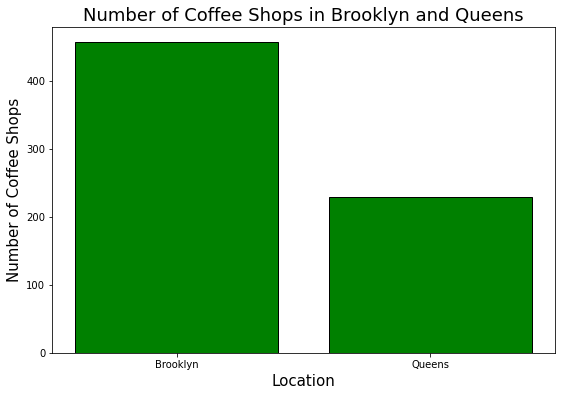

In [188]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.bar(business_count.index, business_count.values, color='green', edgecolor='black', align='center')
ax.set_title('Number of Coffee Shops in Brooklyn and Queens', size=18)
ax.set_ylabel('Number of Coffee Shops', size=15)
ax.set_xlabel('Location', size=15)
plt.show()

In [125]:
queens_zip_bus_count = df[df['zip_code'].isin(zip_queens)].groupby('zip_code')['zip_code'].count()

In [190]:
bus_count_zip_queens = df[df['city'] == 'Queens'].groupby('zip_code')['zip_code'].count()

In [192]:
zip_pop_count_queens = zip_population_queens.rename(columns={'Zip Code':'zip_code'}).set_index('zip_code').join(bus_count_zip_queens).rename(columns={'zip_code':'Business_count'}).dropna()

In [194]:
zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['Population']/zip_pop_count_queens['Business_count']

In [195]:
zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['customers_per_business'].map(lambda x : int(x))

In [196]:
zip_pop_count_queens = zip_pop_count_queens.sort_values(by ='customers_per_business')

In [197]:
zip_pop_count_queens['customers_per_business'] = zip_pop_count_queens['customers_per_business'].map(lambda x : int(x))

In [198]:
zip_pop_count_queens.reset_index(inplace=True)

In [199]:
rating_mean = dfb.groupby('zip_code')['rating'].mean().round(2)

In [200]:
zip_pop_count_queens = zip_pop_count_queens.join(rating_mean, how='left', on = 'zip_code')

In [201]:
zip_pop_count_queens['zip_code'] = zip_pop_count_queens['zip_code'].map(lambda x: str(x))

<ipython-input-202-7cfec0a3b1d8>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(set(zip_pop_count_queens['zip_code']), rotation =45)


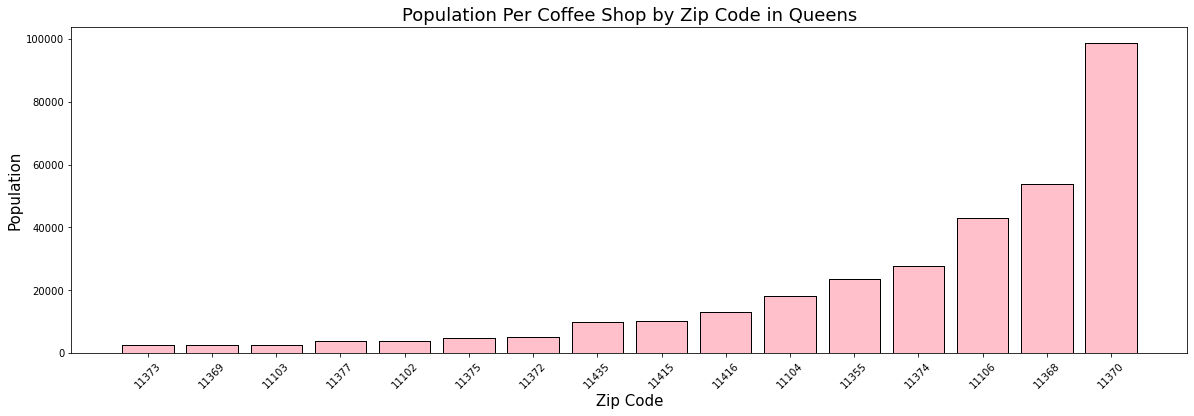

In [202]:
fig, ax = plt.subplots(figsize=(20,6))

bars = ax.bar(zip_pop_count_queens['zip_code'] , zip_pop_count_queens['customers_per_business'], color='pink', edgecolor= 'black', align='center')
ax.set_title('Population Per Coffee Shop by Zip Code in Queens', size=18)
ax.set_ylabel('Population', size=15)
ax.set_xlabel('Zip Code', size= 15)
ax.set_xticklabels(set(zip_pop_count_queens['zip_code']), rotation =45)

plt.show()

Creating a analyzer for weighted features

In [225]:
zip_pop_count_queens['score'] = None
zip_pop_count_queens = zip_pop_count_queens.rename(columns={'rating':'avg_rwiev_rating'})

In [226]:
pop_coef = 0.80
rate_coef = 0.20
mean_rate = 4

def calculate_score(row):
    if int(row['avg_rwiev_rating']) < mean_rate:
        row['score'] = row['customers_per_business'] * pop_coef + row ['avg_rwiev_rating'] * rate_coef
        row['score'] = round(row['score'])
    else:
        row['score'] = 0
    return row

In [227]:
scored_bus = zip_pop_count_queens.apply(calculate_score,axis=1).sort_values(['score'],ascending=False)
scored_bus[['zip_code','avg_rwiev_rating','score']]

zip_code  avg_rwiev_rating  score
255    11368              3.50  79074
247    11368              3.50  79074
240    11368              3.50  79074
241    11368              3.50  79074
242    11368              3.50  79074
243    11368              3.50  79074
245    11368              3.50  79074
246    11368              3.50  79074
244    11368              3.50  79074
248    11368              3.50  79074
249    11368              3.50  79074
250    11368              3.50  79074
251    11368              3.50  79074
252    11368              3.50  79074
253    11368              3.50  79074
254    11368              3.50  79074
231    11435              3.50  43102
224    11435              3.50  43102
225    11435              3.50  43102
226    11435              3.50  43102
227    11435              3.50  43102
228    11435              3.50  43102
229    11435              3.50  43102
230    11435              3.50  43102
236    11435              3.50  43102
232    11435              3.50  43102
233    11435              3.50  43102
234    11435              3.50  43102
235    11435              3.50  43102
237    11435              3.50  43102
238    11435              3.50  43102
239    11435              3.50  43102
199    11355              3.67  22209
192    11355              3.67  22209
193    11355              3.67  22209
194    11355              3.67  22209
195    11355              3.67  22209
196    11355              3.67  22209
197    11355              3.67  22209
198    11355              3.67  22209
201    11355              3.67  22209
200    11355              3.67  22209
202    11355              3.67  22209
203    11355              3.67  22209
204    11355              3.67  22209
205    11355              3.67  22209
206    11355              3.67  22209
207    11355              3.67  22209
168    11369              2.75  14445
160    11369              2.75  14445
161    11369              2.75  14445
162    11369              2.75  14445
163    11369              2.75  14445
165    11369              2.75  14445
166    11369              2.75  14445
167    11369              2.75  14445
164    11369              2.75  14445
169    11369              2.75  14445
171    11369              2.75  14445
172    11369              2.75  14445
173    11369              2.75  14445
174    11369              2.75  14445
175    11369              2.75  14445
170    11369              2.75  14445
137    11372              3.79   8150
131    11372              3.79   8150
132    11372              3.79   8150
133    11372              3.79   8150
134    11372              3.79   8150
135    11372              3.79   8150
136    11372              3.79   8150
140    11372              3.79   8150
138    11372              3.79   8150
139    11372              3.79   8150
141    11372              3.79   8150
142    11372              3.79   8150
143    11372              3.79   8150
129    11372              3.79   8150
130    11372              3.79   8150
128    11372              3.79   8150
80     11374              3.72   3928
89     11374              3.72   3928
81     11374              3.72   3928
95     11374              3.72   3928
94     11374              3.72   3928
93     11374              3.72   3928
91     11374              3.72   3928
90     11374              3.72   3928
92     11374              3.72   3928
88     11374              3.72   3928
87     11374              3.72   3928
86     11374              3.72   3928
85     11374              3.72   3928
84     11374              3.72   3928
83     11374              3.72   3928
82     11374              3.72   3928
35     11106              4.19      0
42     11106              4.19      0
41     11106              4.19      0
40     11106              4.19      0
39     11106              4.19      0
38     11106              4.19      0
37     11106              4.19      0
36     11106              4.19      0
212    11370  